# <a name="Resampler"></a>Resampler

[Hugues Hoppe](https://hhoppe.com/)
&nbsp;&nbsp; Aug 2022.

[**[Open in Colab]**](https://colab.research.google.com/github/hhoppe/resampler/blob/main/resampler.ipynb)
&nbsp; [**[in Kaggle]**](https://www.kaggle.com/notebooks/welcome?src=https://github.com/hhoppe/resampler/blob/main/resampler.ipynb)
&nbsp; [**[in MyBinder]**](https://mybinder.org/v2/gh/hhoppe/resampler/main?filepath=resampler.ipynb)
&nbsp; [**[in DeepNote]**](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2Fhhoppe%2Fresampler%2Fblob%2Fmain%2Fresampler.ipynb)
&nbsp; [**[GitHub source]**](https://github.com/hhoppe/resampler)
&nbsp; [**[API docs]**](https://hhoppe.github.io/resampler/)
&nbsp; [**[PyPI package]**](https://pypi.org/project/resampler/)

This Python notebook has several roles:
- Source code for the `resampler` library in PyPI.
- Illustrated documentation and usage examples.
- Unit tests, lint, build, and export.
- Signal-processing experiments to justify choices.

# <a name="Overview"></a>Overview

<!--
resize, warp, or interpolate arbitrary data arrays

A general-purpose library for resizing, scaling, transforming, and warping data sampled
on regular grids.

flexible, differentiable resampling of arbitrary grids for efficient resizing and warping.
-->

The `resampler` library enables fast differentiable resizing and warping of arbitrary grids.
It supports:

- grids of arbitrary dimension (e.g., 1D audio, 2D images, 3D video, 4D batches of videos),
  containing

- sample values of arbitrary shape
  (e.g., scalars, RGB colors, motion vectors, Jacobian matrices) and

- arbitrary numeric type (integer, floating, and complex);

- either `dual` ("half-integer") or `primal` [**grid-type**](#Grid-types--dual-and-primal-)
  for each dimension;

- many [**boundary**](#Boundary-rules) rules,
  specified per dimension, extensible via subclassing;

- an extensible set of parameterized [**filter**](#Filter-kernels) kernels,
  selectable per dimension;

- optional [**gamma**](#Gamma-correction) transfer functions
  for correct linear-space filtering;

- prefiltering for accurate antialiasing when downsampling;

- processing within several [**array libraries**](#Array-libraries)
  (`numpy`, `tensorflow`, and `torch`);

- efficient backpropagation of [**gradients**](#Gradient-backpropagation)
  for both `tensorflow` and `torch`;

- easy installation, without any native-code extension module, yet

- [**faster resizing**](#Test-other-libraries) than the C++ implementations
  in `tf.image`, `torch.nn`, and `torchvision`.

## Example usage

```python
!pip install -q mediapy resampler
import mediapy as media
import numpy as np
import resampler
```

```python
rng = np.random.default_rng(seed=1)
array = rng.random((4, 6, 3))  # 4x6 RGB image.
upsampled = resampler.resize(array, (128, 192))  # To 128x192 resolution.
media.show_images({'4x6': array, '128x192': upsampled}, height=128)
```
> <img src="https://drive.google.com/uc?export=download&id=1tXm7Z8_ILYpTOsW1a5Z4S-Dvd1vcn7Q5"/>

```python
image = media.read_image('https://github.com/hhoppe/data/raw/main/image.png')
downsampled = resampler.resize(image, (32, 32))
media.show_images({'128x128': image, '32x32': downsampled}, height=128)
```
> <img src="https://drive.google.com/uc?export=download&id=1OiVNvszGZP3COh8mhI0dd2v00cMw2TA0"/>

```python
import matplotlib.pyplot as plt
```

```python
array = [3.0, 5.0, 8.0, 7.0]  # 4 source samples in 1D.
new_dual = resampler.resize(array, (32,))  # (default gridtype='dual') 8x resolution.
new_primal = resampler.resize(array, (25,), gridtype='primal')  # 8x resolution.
_, axs = plt.subplots(1, 2, figsize=(7, 1.5))
axs[0].set_title('gridtype dual')
axs[0].plot((np.arange(len(array)) + 0.5) / len(array), array, 'o')
axs[0].plot((np.arange(len(new_dual)) + 0.5) / len(new_dual), new_dual, '.')
axs[1].set_title('gridtype primal')
axs[1].plot(np.arange(len(array)) / (len(array) - 1), array, 'o')
axs[1].plot(np.arange(len(new_primal)) / (len(new_primal) - 1), new_primal, '.')
plt.show()
```
> <img src="https://drive.google.com/uc?export=download&id=1VGjyX2nvBKaWyGbrMt3g0Nd3G1YdtFjg"/>

```python
batch_size = 4
batch_of_images = media.moving_circle((16, 16), batch_size)
upsampled = resampler.resize(batch_of_images, (batch_size, 64, 64))
spacer = np.ones((64, 16, 3))
media.show_images([*batch_of_images, spacer, *upsampled], border=True, height=64)
```
> <img src="https://drive.google.com/uc?export=download&id=1PLHu5mCpmb-_54ybvfr6kLUUTHD6l73t"/>

```python
media.show_videos({'original': batch_of_images, 'upsampled': upsampled}, fps=1)
```
> original
<img src="https://drive.google.com/uc?export=download&id=1WCwwbgYZordX14-XvHiV2Gc_60I1KD39"/>
upsampled
<img src="https://drive.google.com/uc?export=download&id=11Of3Gbv6p2BTxJD2rO0zAWEEv4w3BIe5"/>

Most examples above use the default
[`resize()`](#Resize) settings:
- [`gridtype='dual'`](#Grid-types--dual-and-primal-) for both source and destination arrays,
- [`boundary='auto'`](#Boundary-rules)
  which uses `'reflect'` for upsampling and `'clamp'` for downsampling,
- [`filter='lanczos3'`](#Filter-kernels)
  (a [Lanczos](https://en.wikipedia.org/wiki/Lanczos_resampling) kernel with radius 3),
- [`gamma=None`](#Gamma-correction) which by default uses the `'power2'`
  transfer function for the `uint8` image in the second example,
- `scale=1.0, translate=0.0` (no domain transformation),
- default `precision` and output `dtype`.

**Advanced usage:**

Map an image to a wider grid using custom `scale` and `translate` vectors,
with horizontal `'reflect'` and vertical `'natural'` boundary rules,
providing a constant value for the exterior,
using different filters (Lanczos and O-MOMS) in the two dimensions,
disabling gamma correction, performing computations in double-precision,
and returning an output array in single-precision:

```python
new = resampler.resize(
    image, (128, 512), boundary=('natural', 'reflect'), cval=(0.2, 0.7, 0.3),
    filter=('lanczos3', 'omoms5'), gamma='identity', scale=(0.8, 0.25),
    translate=(0.1, 0.35), precision='float64', dtype='float32')
media.show_images({'image': image, 'new': new})
```
> <img src="https://drive.google.com/uc?export=download&id=1WUsrghao2Py9hSCPWfinVYg6Lga55h1X"/>

Warp an image by transforming it using
[polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system):

```python
shape = image.shape[:2]
yx = ((np.indices(shape).T + 0.5) / shape - 0.5).T  # [-0.5, 0.5]^2
radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5
resampled = resampler.resample(image, coords, boundary='constant')
media.show_images({'image': image, 'resampled': resampled})
```
> <img src="https://drive.google.com/uc?export=download&id=1vqnNGeAw5uTNvMEt8hzQY3uXOJugMtJY"/>

**Limitations:**

- Filters are assumed to be [separable](https://en.wikipedia.org/wiki/Separable_filter).
For rotation equivariance (e.g., bandlimit the signal uniformly in all directions),
it would be nice to support the (non-separable) 2D rotationally symmetric
[sombrero function](https://en.wikipedia.org/wiki/Sombrero_function)
$f(\textbf{x}) = \text{jinc}(\|\textbf{x}\|)$,
where $\text{jinc}(r) = 2J_1(\pi r)/(\pi r)$.
(The Fourier transform of a circle
[involves the first-order Bessel function of the first kind](
  https://en.wikipedia.org/wiki/Airy_disk).)

## Signal-processing concepts

In [digital signal processing](https://en.wikipedia.org/wiki/Digital_signal_processing),
a [scalar field](https://en.wikipedia.org/wiki/Scalar_field)
\(defined over a [Euclidean space](https://en.wikipedia.org/wiki/Euclidean_space)\)
is represented using discrete
[samples](https://en.wikipedia.org/wiki/Sampling_(signal_processing))
\(defined over a [regular grid](https://en.wikipedia.org/wiki/Regular_grid)\).
Converting between the field and samples involves
[*reconstruction*](https://en.wikipedia.org/wiki/Sinc_interpolation)
and [*sampling*](https://en.wikipedia.org/wiki/Sampling_(signal_processing)) (Figure 1).

<center>
<!-- Edit from Google Drive or https://docs.google.com/drawings/d/1XJWGNd8qRZloUryKZyGNmJZbbDARNNdpbCV8yNJQB2k/edit -->
<img style="margin: 15px 0px 0px 0px;" src="https://docs.google.com/drawings/d/e/2PACX-1vQ4RPXRkDabmjuNUvzi5XQwZsfH9eDiChsSjNbqOp8Du96_xNNkwM-fwZ800fLq3uE85wDVfb4oQd1D/pub?h=400" width="600"/>
<br/>
Figure 1: Reconstruction of an RGB color field from a 2D grid of pixel samples,
and sampling of the field to obtain pixel values.
</center>

- The **domain** is the region of interest:
  e.g., a 1D time interval, the 2D extent of an image, or a 3D cuboid of volumetric data.
  For simplicity, we let this domain be the unit
  [hypercube](https://en.wikipedia.org/wiki/Hypercube) $[0, 1]^d$.

- A [*regular grid*](https://en.wikipedia.org/wiki/Regular_grid) distributes samples
  within the domain according to the
  [**grid-type**](#Grid-types--dual-and-primal-) (*dual* or *primal*):
  <center><img style="margin: 15px 0px 15px 0px;" src="https://docs.google.com/drawings/d/e/2PACX-1vRPbU2t6ylO9WfyDUO3SEyHkc2tppSjbis0kb9RGGIU6jPPe9PqA2JNUjBSnVdf47ITsQIlLpmrsImg/pub?h=100"></center>

- [*Reconstruction*](https://en.wikipedia.org/wiki/Sinc_interpolation)
  creates an interpolating function (e.g., a 2D color field)
  from a sample grid (e.g., image pixels).
  The function is obtained as a sum along each dimension of translated *reconstruction filters*
  [weighted](https://en.wikipedia.org/wiki/Lanczos_resampling)
  by the sample values:
  <center><img style="margin: 15px 0px 15px 0px;" src="https://drive.google.com/uc?export=download&id=1PwxaQ-lVsseukCGlRShUaUHH5qt3ke-6" width="500"/></center>

- Common [**filter**](#Filter-kernels) choices include:
  <center><img style="margin: 15px 0px 15px 0px;" src="https://drive.google.com/uc?export=download&id=1WmyF2fbxuVpQAqCgCVXg6jOCRAUCC5NK"/></center>


- [**Boundary**](#Boundary-rules) rules determine the behavior of the
  reconstruction near and beyond the domain extent.  Choices include:
  <center><img style="margin: 15px 0px 15px 0px;" src="https://drive.google.com/uc?export=download&id=1MDsWXRfdBTwZVWeTceq4gqjHBVCQbR4K"/></center>

- [*Sampling*](https://en.wikipedia.org/wiki/Sampling_(signal_processing))
  determines sample values given a field.
  To prevent [aliasing](https://en.wikipedia.org/wiki/Aliasing) artifacts,
  we convolve the field with a *prefilter*
  to remove frequencies larger than the destination grid's
  [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency)
  before evaluating the grid samples.
  Sampling does not involve boundary rules because the reconstructed field
  is already defined over the full space $\mathbb{R}^d$.

- [**Gamma**](#Gamma-correction) correction uses
  [nonlinear transfer functions](https://en.wikipedia.org/wiki/Gamma_correction)
  \(e.g., [sRGB](https://en.wikipedia.org/wiki/SRGB)\)
  to decode/encode sample values, especially quantized `uint8` values.

- The [**resize**](#Resize) operation converts a *source grid* to
  a *destination grid* as the composition of reconstruction and sampling (Figure 1).
  Such [sample rate conversion](https://en.wikipedia.org/wiki/Sample-rate_conversion)
  enables # [downsampling](https://en.wikipedia.org/wiki/Downsampling_(signal_processing))
  and [upsampling](https://en.wikipedia.org/wiki/Upsampling).
  The operation also supports translation and non-uniform scaling
  from the source to the destination domain.

- The [**resample_affine**](#resample-affine-function) operation allows an
  [affine map](https://en.wikipedia.org/wiki/Affine_transformation)
  (i.e., including rotation and shear) from the source to the destination domain.

- The [**resample**](#Resample) operation is a generalization in which
  the destination samples are mapped to *arbitrary* coordinates in the source domain:
  <center><img style="margin: 15px 0px 15px 0px;" src="https://drive.google.com/uc?export=download&id=1EWFR8dE3VpDICC98qD5NWgTQi-cttOEz"/></center>
  <!--TODO: antialias this result!-->

- Efficient implementation of resize/resample is enabled by [two key
  observations](http://www2.eecs.berkeley.edu/Pubs/TechRpts/1989/CSD-89-516.pdf):

  (1) For upsampling (magnification), the sampling prefilter is *unnecessary*
      because the reconstructed field is already
      [bandlimited](https://en.wikipedia.org/wiki/Bandlimiting).

  (2) For downsampling (minification), the reconstruction filter
      can be replaced by a trivial *impulse* function because the
      reconstructed field is subsequently bandlimited by the sampling prefilter.

[extra notes]
<!--
  However, the *intermediate function* is impractical to represent on a computer.
  Most computations involve discretized representations.

  One can approximate the intermediate function using a high-resolution grid as was done
  in the previous figure.

  But in practice, it is possible to take a shortcut.

  - Magnification -> omit the prefilter kernel.

  - Minification -> omit the reconstruction kernel.

  To avoid the shortcut and obtain a higher-quality resampling, one can manually apply two
  successive resizing operations, where the intermediate grid has higher-resolution than
  either the source or destination grid.

Computer graphics: supersampling.
Given a procedural vector graphics or computer graphics rendering.

Unused:

https://en.wikipedia.org/wiki/Multidimensional_sampling

https://en.wikipedia.org/wiki/Multivariate_interpolation

-->

# <a name="Imports"></a>Imports

In [1]:
"""resampler: efficient, flexible, differentiable resizing and warping of grids.

&nbsp; [**[Open in Colab]**](https://colab.research.google.com/github/hhoppe/resampler/blob/main/resampler.ipynb)
&nbsp; [**[GitHub source]**](https://github.com/hhoppe/resampler)
&nbsp; [**[API docs]**](https://hhoppe.github.io/resampler/)
&nbsp; [**[PyPI package]**](https://pypi.org/project/resampler/)
""";

In [2]:
# TODO:
# - Plot frequency responses of filters.
#   (Magnitude (dB) vs Normalized frequency (\pi radians/sample) [0, 1]).
#   See example analysis in https://numpy.org/doc/stable/reference/generated/numpy.kaiser.html.
# - Compare trapezoid with opencv resize INTER_AREA.
# - instead use default prefilter='trapezoid'.
#   but then even more discontinuous at transition from minification to magnification?
# - Optimize the case of an affine map:
#   convolve the source grid with a prefilter using FFT (if any dim is downsampling),
#   then proceed as before.  Slow!
# - Let resample handle minification;
#   create anisotropic footprint of destination within source domain.
#   Use jacobian and prefilter in resample().
# - Is lightness-space upsampling justified using experiments on natural images?
#   (is linear-space downsampling justified using such experiments? it should be obvious.)

In [3]:
# Useful resources:
# https://legacy.imagemagick.org/Usage/filter/

In [4]:
# Export: none.
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)

In [5]:
# Export: none.
!pip install -qU hhoppe-tools
!pip install -q hhoppe-tools jupytext matplotlib mediapy 'numba>=0.55.1' opencv-python 'Pillow>=9' scipy scikit-image tensorflow-cpu torch torchvision

In [6]:
__docformat__ = 'google'
__version__ = '0.3.0'
__version_info__ = tuple(int(num) for num in __version__.split('.'))

In [7]:
import dataclasses
import functools
import math
import typing
from typing import Any, Callable, Dict, Iterable, List
from typing import Optional, Sequence, Tuple, Union

import numpy as np
import scipy.interpolate
import scipy.linalg
import scipy.ndimage
import scipy.sparse.linalg

In [8]:
try:
  import numba
except ModuleNotFoundError:
  pass

In [9]:
# Export: outside library.
import copy
import collections
import glob
import itertools
import os
import pathlib
from typing import Mapping
import warnings

import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import IPython
import matplotlib          # pylint: disable=unused-import
import matplotlib.pyplot as plt
import mediapy as media  # https://github.com/google/mediapy
import scipy.signal
import skimage.metrics
import skimage.transform
# End-of-notebook-imports.

In [10]:
# Export: none.
import re
from typing import Iterator

In [11]:
_DType = Any
_NDArray = Any  # To document np.ndarray[Any, Any] without enforcement.
_TensorflowTensor = Any  # To document tf.Tensor without enforcement.
_TorchTensor = Any  # To document torch.Tensor without enforcement.
_Array = Any  # To document any array class supported by _Arraylib.

In [12]:
def check_eq(a: Any, b: Any) -> None:
  """If the two values or arrays are not equal, raise an exception with a useful message."""
  equal = np.all(a == b) if isinstance(a, np.ndarray) else a == b
  if not equal:
    raise AssertionError(f'{a!r} == {b!r}')

# Notebook definitions

In [13]:
# Export: begin notebook definitions.

In [14]:
EFFORT = 1  # 0..3: Controls the breadth and precision of the notebook experiments.

In [15]:
_ORIGINAL_GLOBALS = list(globals())
_: Any = np.seterr(all='raise')  # Let all numpy warnings raise errors.
hh.start_timing_notebook_cells()

In [16]:
# https://stackoverflow.com/a/42121886 : omit "This TensorFlow binary is optimized with oneAPI.."
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [17]:
# ('.../tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets.')
warnings.filterwarnings('ignore', message='IProgress not found')  # category=tqdm.TqdmWarning

In [18]:
_URL_BASE = 'https://github.com/hhoppe/data/raw/main'
EXAMPLE_IMAGE = media.read_image(f'{_URL_BASE}/image.png')  # (128, 128, 3)
EXAMPLE_PHOTO = media.read_image(f'{_URL_BASE}/lillian_640x480.png')  # (480, 640)

In [19]:
@functools.lru_cache(maxsize=None)
def example_tissot_image() -> _NDArray:
  """Return (1000, 2000, 3) image from
  https://commons.wikimedia.org/wiki/File:Tissot_indicatrix_world_map_equirectangular_proj.svg"""
  _TISSOT_URL = ('https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/'
                 'Tissot_indicatrix_world_map_equirectangular_proj.svg/'
                 '2000px-Tissot_indicatrix_world_map_equirectangular_proj.svg.png')
  return media.read_image(_TISSOT_URL)[..., :3]

In [20]:
@functools.lru_cache(maxsize=None)
def example_vector_graphics_image() -> _NDArray:
  """Return (3300, 2550) image."""
  # (We used the https://cloudconvert.com/pdf-to-png service to obtain this vector graphics
  # rasterization, as it antialiases nicely without ringing.)
  return media.read_image(f'{_URL_BASE}/apptexsyn_cloudconvert_page4_300dpi.png')

In [21]:
def display_markdown(s: str) -> None:
  IPython.display.display(IPython.display.Markdown(s))

In [22]:
def display_html(s: str) -> None:
  IPython.display.display(IPython.display.HTML(s))

In [23]:
# Set Markdown width in Jupyterlab to the value used by Colab; https://stackoverflow.com/a/66278615.
display_html('<style>.jp-Cell.jp-MarkdownCell { max-width: 1016px!important; }</style>')

In [24]:
def must_be_int(x: Any) -> _NDArray:
  """Return float cast as int, asserting that there was no fractional part."""
  result: _NDArray = np.array(x).astype(int, copy=False)
  check_eq(result, x)
  return result

check_eq(must_be_int(6 / 2), 3)

In [25]:
def get_rms(a: Any, b: Any) -> float:
  """Return the root-mean-square difference between two arrays."""
  a, b = media.to_float01(a), media.to_float01(b)
  rms: float = np.sqrt(np.mean(np.square(a - b))).item()
  return rms

assert math.isclose(get_rms(0.2, 0.3), 0.1)

In [26]:
def get_psnr(a: Any, b: Any) -> float:
  """Return the Peak-Signal-to-Noise-Ratio (dB) between [0.0, 1.0] values."""
  rms = get_rms(a, b)
  psnr: float = 20 * np.log10(1.0 / (rms + 1e-10)).item()
  return psnr

assert math.isclose(get_psnr(0.2, 0.3), 20.0)

In [27]:
def get_ssim(image1: _NDArray, image2: _NDArray) -> float:
  """Return the structural similarity metric [0.0, 1.0] between two images."""
  assert np.issubdtype(image1.dtype, np.floating)
  assert np.issubdtype(image2.dtype, np.floating)
  if 1:
    # Default win_size=7, no Gaussian weighting.
    kwargs = dict(channel_axis=2) if skimage.__version__ >= '0.19.' else dict(multichannel=True)
    ssim: float = skimage.metrics.structural_similarity(image1, image2, **kwargs).item()
    return ssim

  # Slower but with more functionality.
  import tensorflow as tf
  # Default filter_size=11, filter_sigma=1.5.
  return float(tf.image.ssim(image1, image2, max_val=1.0))

In [28]:
def test_ssim() -> None:
  image1 = media.to_float01(EXAMPLE_IMAGE)
  image2 = image1 * np.float32(0.9)
  ssim = get_ssim(image1, image2)
  assert 0.99 < ssim < 1.0  # Change in mean value does not change structure.
  filter = np.ones((3, 3, 1)) / 9
  image3 = scipy.ndimage.convolve(image1, filter, mode='reflect')
  ssim = get_ssim(image1, image3)
  assert 0.75 < ssim < 0.9  # Blurring causes loss of structural detail.

if EFFORT >= 1:
  test_ssim()

In [29]:
def crop_array(array: Any, width: Any, cval: Any = 0) -> _NDArray:
  """Return array cropped (or padded) along each dimension.

  Args:
    array: Input data.
    width: Crop widths (or pad widths if negative) before each dimension and after each dimension.
      Must be broadcastable onto (2, array.ndim).
    cval: Value to use when padding.
  """
  # https://stackoverflow.com/questions/66846983
  array = np.asarray(array)
  width = np.broadcast_to(width, (2, array.ndim))
  if (width > 0).any():
    array = array[tuple(slice(before, (-after if after else None))
                        for (before, after) in np.maximum(width, 0).T)]
  if (width < 0).any():
    array = np.pad(array, -np.minimum(width, 0).T, constant_values=cval)
  return array

In [30]:
def test_crop_array() -> None:
  array1 = np.arange(15).reshape(3, 5)
  check_eq(crop_array(array1, 1), [[6, 7, 8]])
  check_eq(crop_array(array1, (1, 2)), [[7]])
  check_eq(crop_array(array1, ((2, 1), (-1, 2))), [[11, 12], [0, 0]])
  check_eq(crop_array([1], -3, cval=5), [5, 5, 5, 1, 5, 5, 5])
  check_eq(crop_array([1], [[-2], [-1]], cval=5), [5, 5, 1, 5])

test_crop_array()

In [31]:
def show_grid_values(array, figsize=(14, 4), cmap='gray', **kwargs) -> None:
  """Show the values of a 2D grayscale array."""
  array = np.asarray(array)
  check_eq(array.ndim, 2)
  _, ax = plt.subplots(figsize=figsize)
  ax.matshow(array, cmap=cmap, **kwargs)
  for yx in np.ndindex(array.shape):
    value = array[yx]
    s = f'{value}' if np.issubdtype(array.dtype, np.integer) else f'{value:.3f}'
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html
    ax.text(*yx[::-1], s, va='center', ha='center',
            bbox=dict(boxstyle='square,pad=0.1', fc='white', lw=0))
  _ = ax.xaxis.set_ticks([]), ax.yaxis.set_ticks([])
  plt.show()

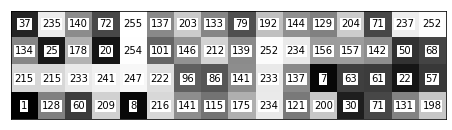

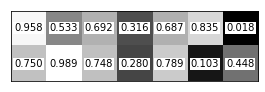

In [32]:
def test_show_grid_values() -> None:
  np.random.seed(1)
  show_grid_values(np.random.randint(0, 256, size=(4, 16)), figsize=(14, 2), vmin=0, vmax=255)
  show_grid_values(np.random.random((2, 7)), figsize=(8, 1.3))

if EFFORT >= 1:
  test_show_grid_values()

In [33]:
def create_checkerboard(output_shape, block_shape=(1, 1), dtype=np.float32) -> _NDArray:
  indices = np.moveaxis(np.indices(output_shape), 0, -1)
  return ((indices // block_shape).sum(axis=-1) % 2).astype(dtype)

In [34]:
def test_checkerboard(shape=(5, 7), debug=False) -> None:
  image = create_checkerboard(shape)
  check_eq(image.dtype, np.float32)
  check_eq(image.shape, shape)
  check_eq(image.sum(), np.prod(shape) // 2)
  if debug:
    media.show_image(image, border=True, height=image.shape[0] * 8)

test_checkerboard()

In [35]:
# Export: end notebook definitions.

# Library

## Helper functions

In [36]:
def _real_precision(dtype: _DType) -> _DType:
  """Return the type of the real part of a complex number."""
  return np.array([], dtype=dtype).real.dtype

In [37]:
def _get_precision(precision: Any, dtypes: List[_DType], weight_dtypes: List[_DType]) -> _DType:
  """Return dtype based on desired precision or on data and weight types."""
  precision = np.dtype(precision if precision is not None else
                       np.find_common_type([], [np.float32, *dtypes, *weight_dtypes]))
  if not np.issubdtype(precision, np.inexact):
    raise ValueError(f'Precision {precision} is not floating or complex.')
  check_complex = [precision, *dtypes]
  is_complex = [np.issubdtype(dtype, np.complexfloating) for dtype in check_complex]
  if len(set(is_complex)) != 1:
    raise ValueError(f'Types {",".join(str(dtype) for dtype in check_complex)}'
                     ' must be all real or all complex.')
  return precision

In [38]:
def test_precision() -> None:
  check_eq(_real_precision(np.dtype(np.float32)), np.float32)
  check_eq(_real_precision(np.dtype(np.float64)), np.float64)
  check_eq(_real_precision(np.dtype(np.complex64)), np.float32)
  check_eq(_real_precision(np.dtype(np.complex128)), np.float64)

  check_eq(_get_precision(None, [np.dtype(np.complex64)], [np.dtype(np.float64)]), np.complex128)

test_precision()

In [39]:
def _sinc(x: Any) -> _NDArray:
  """Return the value `np.sinc(x)` but improved to:
  (1) ignore underflow that occurs at 0.0 for np.float32, and
  (2) output exact zero for integer input values.
  """
  x = np.asarray(x)
  x_is_scalar = x.ndim == 0
  with np.errstate(under='ignore'):
    result = np.sinc(np.atleast_1d(x))
    result[x == np.floor(x)] = 0.0
    result[x == 0] = 1.0
    return result.item() if x_is_scalar else result

In [40]:
def test_sinc() -> None:
  check_eq(_sinc(np.array([-3, -2, -1, 0], dtype=np.float32)), [0, 0, 0, 1])
  check_eq(_sinc(0), 1.0)

test_sinc()

In [41]:
def _is_symmetric(matrix: Any, tol: float = 1e-10) -> bool:
  """Return True if the sparse matrix is symmetric."""
  norm: float = scipy.sparse.linalg.norm(matrix - matrix.T, np.inf)
  return norm <= tol

In [42]:
def _spline_filter1d(*args: Any, mode: Optional[str] = None, **kwargs: Any) -> _NDArray:
  """Wrapper to use 'grid-wrap' if scipy is a recent version."""
  if mode == 'wrap':
    scipy_version = tuple(int(num) for num in scipy.__version__.split('.'))
    mode = 'grid-wrap' if scipy_version >= (1, 6) else 'wrap'
  return scipy.ndimage.spline_filter1d(*args, mode=mode, **kwargs)

In [43]:
def _cache_sampled_1d_function(
    xmin: float, xmax: float, *, num_samples: int = 3_600, enable: bool = True,
) -> Callable[[Callable[[Any], _NDArray]], Callable[..., _NDArray]]:
  """Function decorator to linearly interpolate cached function values."""
  # Speed unchanged up to num_samples=12_000, then slow decrease until 100_000.

  def wrap_it(func: Callable[[Any], _NDArray]) -> Callable[..., _NDArray]:
    if not enable:
      @functools.wraps(func)
      def original_func(x: Any, *, mode: str = '') -> _NDArray:
        check_eq(mode, '')
        return func(x)
      return original_func

    dx = (xmax - xmin) / num_samples
    x = np.linspace(xmin, xmax + dx, num_samples + 2, dtype=np.float32)
    samples_func = func(x)
    assert np.all(samples_func[[0, -1, -2]] == 0.0)

    @functools.wraps(func)
    def interpolate_using_cached_samples(x: Any, *, mode: str = 'linear') -> _NDArray:
      if mode == 'exact':
        return func(x)
      index_float = np.clip((x - xmin) / dx, 0.0, num_samples)
      index = index_float.astype(np.int64)
      if mode == 'nearest':
        return samples_func[index]
      if mode == 'linear':
        frac = np.subtract(index_float, index, dtype=np.float32)
        return (1 - frac) * samples_func[index] + frac * samples_func[index + 1]
      raise ValueError(f'Mode {mode} is not one of: exact, nearest, linear.')

    return interpolate_using_cached_samples

  return wrap_it

In [44]:
def test_cached_sampling_of_1d_function(radius=2.0) -> None:

  def func(x: Any) -> _NDArray:  # Lanczos kernel
    x = np.abs(x)
    return np.where(x < radius, _sinc(x) * _sinc(x / radius), 0.0)

  @_cache_sampled_1d_function(xmin=-radius, xmax=radius)
  def func2(x: Any) -> _NDArray:
    return func(x)

  def create_scipy_interpolant(func, xmin, xmax,
                               num_samples=3_600) -> Callable[[_NDArray], _NDArray]:
    samples_x = np.linspace(xmin, xmax, num_samples + 1, dtype=np.float32)
    samples_func = func(samples_x)
    assert np.all(samples_func[[0, -1]] == 0.0)
    interpolator: Callable[[Any], Any] = scipy.interpolate.interp1d(
        samples_x, samples_func, kind='linear', bounds_error=False, fill_value=0)
    return interpolator

  scipy_interp = create_scipy_interpolant(func, -radius, radius)

  shape = 2, 8_000
  np.random.seed(6)
  array = np.random.random(shape).astype(np.float32) * 2 * radius - radius
  result = {'expected': func(array), 'scipy': scipy_interp(array)}
  for mode in 'exact linear nearest'.split():
    result[mode] = func2(array, mode=mode)

  assert all(a.dtype == np.float32 for a in result.values())
  assert all(a.shape == shape for a in result.values())
  assert np.allclose(result['exact'], result['expected'], rtol=0, atol=0)
  assert np.allclose(result['linear'], result['expected'], rtol=0, atol=1e-6)
  assert np.allclose(result['nearest'], result['expected'], rtol=0, atol=1e-2)
  assert np.allclose(result['scipy'], result['expected'], rtol=0, atol=1e-6)

  if EFFORT >= 2:
    shape = 1000, 1000
    array = np.random.random(shape) * 8.0 - 4.0
    hh.print_time(lambda: func(array))
    hh.print_time(lambda: func2(array, mode='exact'))
    hh.print_time(lambda: func2(array, mode='linear'))
    hh.print_time(lambda: func2(array, mode='nearest'))
    # 0.091 s
    # 0.094 s
    # 0.019 s
    # 0.010 s
    hh.prun(lambda: func2(array), top=4)  # The bottleneck is the array lookup.
    # Prun: tottime    0.033 overall_cumtime
    #         0.026    0.033 interpolate_using_cached_samples
    #         0.004    0.004 _clip_dep_invoke_with_casting (/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:106)
    #         0.002    0.002 numpy.ndarray.astype
    #         0.000    0.033 <lambda>

test_cached_sampling_of_1d_function()

In [45]:
class _DownsampleIn2dUsingBoxFilter:
  """Fast 2D box-filter downsampling using cached numba-jitted functions."""

  def __init__(self) -> None:
    # Downsampling function for params (dtype, block_height, block_width, ch).
    self._jitted_function: Dict[Tuple[_DType, int, int, int], Callable[[_NDArray], _NDArray]] = {}

  def __call__(self, array: _NDArray, shape: Tuple[int, int]) -> _NDArray:
    assert 'numba' in globals()
    assert array.ndim in (2, 3), array.ndim
    check_eq(len(shape), 2)
    dtype = array.dtype
    a = array[..., None] if array.ndim == 2 else array
    height, width, ch = a.shape
    new_height, new_width = shape
    if height % new_height != 0 or width % new_width != 0:
      raise ValueError(f'Shape {array.shape} not a multiple of {shape}.')
    block_height, block_width = height // new_height, width // new_width

    def func(array: _NDArray) -> _NDArray:  # pylint: disable=too-many-branches
      new_height = array.shape[0] // block_height
      new_width = array.shape[1] // block_width
      result = np.empty((new_height, new_width, ch), dtype)
      totals = np.empty(ch, dtype)
      scale = dtype.type(1.0 / (block_height * block_width))
      for y in range(new_height):  # pylint: disable=too-many-nested-blocks
        for x in range(new_width):
          # y2, x2 = y * block_height, x * block_width ?
          if ch == 1:  # All the branches involve compile-time constants.
            total = dtype.type(0.0)
            for yy in range(block_height):
              for xx in range(block_width):
                total += array[y * block_height + yy, x * block_width + xx, 0]
            result[y, x, 0] = total * scale
          elif ch == 3:
            total0 = total1 = total2 = dtype.type(0.0)
            for yy in range(block_height):
              for xx in range(block_width):
                # pixel = array[y2 + yy, x2 + xx] ?
                total0 += array[y * block_height + yy, x * block_width + xx, 0]
                total1 += array[y * block_height + yy, x * block_width + xx, 1]
                total2 += array[y * block_height + yy, x * block_width + xx, 2]
            result[y, x, 0] = total0 * scale
            result[y, x, 1] = total1 * scale
            result[y, x, 2] = total2 * scale
          elif block_height * block_width >= 9:
            for c in range(ch):
              totals[c] = 0.0
            for yy in range(block_height):
              for xx in range(block_width):
                for c in range(ch):
                  totals[c] += array[y * block_height + yy, x * block_width + xx, c]
            for c in range(ch):
              result[y, x, c] = totals[c] * scale
          else:
            for c in range(ch):
              total = dtype.type(0.0)
              for yy in range(block_height):
                for xx in range(block_width):
                  total += array[y * block_height + yy, x * block_width + xx, c]
              result[y, x, c] = total * scale
      return result

    signature = dtype, block_height, block_width, ch
    jitted_function = self._jitted_function.get(signature)
    if not jitted_function:
      if 0:
        print(f'Creating numba jit-wrapper for {signature}.')
      jitted_function = self._jitted_function[signature] = numba.njit(func)
    result = jitted_function(a)
    return result[..., 0] if array.ndim == 2 else result


_downsample_in_2d_using_box_filter = _DownsampleIn2dUsingBoxFilter()

In [46]:
def test_downsample_in_2d_using_box_filter() -> None:
  for shape in [(6, 6), (4, 4)]:
    for ch in [1, 2, 3, 4]:
      array = np.ones((*shape, ch), dtype=np.float32)
      new = _downsample_in_2d_using_box_filter(array, (2, 2))
      check_eq(new.shape, (2, 2, ch))
      assert np.allclose(new, 1.0)
  for shape in [(6, 6), (4, 4)]:
    array = np.ones(shape, dtype=np.float32)
    new = _downsample_in_2d_using_box_filter(array, (2, 2))
    check_eq(new.shape, (2, 2))
    assert np.allclose(new, 1.0)

if EFFORT >= 1:
  test_downsample_in_2d_using_box_filter()

In [47]:
def test_profile_downsample_in_2d_using_box_filter() -> None:
  pass  # hh.print_time(..), hh.prun() ?

test_profile_downsample_in_2d_using_box_filter()

## <a name="Array-libraries"></a>Array libraries

The [`resize`](#resize-function) and [`resample`](#Resample)
functions operate transparently on multidimensional arrays from several libraries:
```python
list(ARRAYLIBS)  # ['numpy', 'tensorflow', 'torch']
```

- The library is selected automatically based on the type of the `array` parameter.

- The class `_Arraylib` provides library-specific implementations of needed basic functions.

- The `_arr_*()` functions dispatch the `_Arraylib` methods based on the array type.

- Function `_make_array()` creates an array of a specified `arraylib`.

(See also https://github.com/jonasrauber/eagerpy for a more complete
but less specialized library.)

In [48]:
@dataclasses.dataclass
class _Arraylib:
  """Abstract base class for abstraction of array libraries."""

  arraylib: str
  """Name of array library (e.g., 'numpy', 'tensorflow', 'torch')."""

  array: _Array

  @staticmethod
  def recognize(array: Any) -> bool:
    """Return True if `array` is recognized by this array library."""

  def numpy(self) -> _NDArray:
    """Return a `numpy` version of this array."""

  def dtype(self) -> _DType:
    """Return the numpy dtype of the array."""

  def astype(self, dtype: Any) -> _Array:
    """Return the array with values cast as numpy dtype."""

  def clip(self, low: Any, high: Any, dtype: Any = None) -> _Array:
    """Return the array with values clipped to the range [low, high]."""

  def square(self) -> _Array:
    """Return a new array with values squared."""

  def sqrt(self) -> _Array:
    """Return a new array with values square-rooted."""

  def gather(self, table: Any) -> _Array:
    """Return `table[array]`."""

  def where(self, if_true: Any, if_false: Any) -> _Array:
    """Return `where(array, if_true, if_false)`."""

  def transpose(self, axes: Sequence[int]) -> _Array:
    """Return the array with its axes permuted."""

  def concatenate(self, arrays: Sequence[_Array], axis: int) -> _Array:
    """Return the concatenation of arrays; uses self only to determine arraylib!"""

In [49]:
class _NumpyArraylib(_Arraylib):
  """Numpy implementation of the array abstraction."""

  def __init__(self, array: Any) -> None:
    super().__init__(arraylib='numpy', array=np.asarray(array))

  @staticmethod
  def recognize(array: Any) -> bool:
    return isinstance(array, np.ndarray)

  def numpy(self) -> _NDArray:
    return self.array

  def dtype(self) -> _DType:
    return self.array.dtype

  def astype(self, dtype: Any) -> _Array:
    return self.array.astype(dtype, copy=False)

  def clip(self, low: Any, high: Any, dtype: Any = None) -> _Array:
    return self.array.clip(low, high, dtype=dtype)

  def square(self) -> _Array:
    return np.square(self.array)

  def sqrt(self) -> _Array:
    return np.sqrt(self.array)

  def gather(self, table: Any) -> _Array:
    indices = self.array
    return table[indices]

  def where(self, if_true: Any, if_false: Any) -> _Array:
    condition = self.array
    return np.where(condition, if_true, if_false)

  def transpose(self, axes: Sequence[int]) -> _Array:
    return np.transpose(self.array, tuple(axes))

  def concatenate(self, arrays: Sequence[_Array], axis: int) -> _Array:
    return np.concatenate(arrays, axis)

In [50]:
class _TensorflowArraylib(_Arraylib):
  """Tensorflow implementation of the array abstraction."""

  def __init__(self, array: Any) -> None:
    import tensorflow as tf
    super().__init__(arraylib='tensorflow', array=tf.convert_to_tensor(array))

  @staticmethod
  def recognize(array: Any) -> bool:
    # Eager: tensorflow.python.framework.ops.Tensor
    # Non-eager: tensorflow.python.ops.resource_variable_ops.ResourceVariable
    return type(array).__module__.startswith('tensorflow.')

  def numpy(self) -> _NDArray:
    return self.array.numpy()

  def dtype(self) -> _DType:
    return np.dtype(self.array.dtype.as_numpy_dtype)

  def astype(self, dtype: Any) -> _Array:
    import tensorflow as tf
    return tf.cast(self.array, dtype)

  def clip(self, low: Any, high: Any, dtype: Any = None) -> _Array:
    import tensorflow as tf
    array = self.array
    if dtype is not None:
      array = tf.cast(array, dtype)
    return tf.clip_by_value(array, low, high)

  def square(self) -> _Array:
    import tensorflow as tf
    return tf.square(self.array)

  def sqrt(self) -> _Array:
    import tensorflow as tf
    return tf.sqrt(self.array)

  def gather(self, table: Any) -> _Array:
    import tensorflow as tf
    indices = self.array
    if _arr_dtype(indices) in (np.uint8, np.uint16):
      indices = tf.cast(indices, np.int32)
    return tf.gather(table, indices, axis=None)

  def where(self, if_true: Any, if_false: Any) -> _Array:
    import tensorflow as tf
    condition = self.array
    return tf.where(condition, if_true, if_false)

  def transpose(self, axes: Sequence[int]) -> _Array:
    import tensorflow as tf
    return tf.transpose(self.array, perm=tuple(axes))

  def concatenate(self, arrays: Sequence[_Array], axis: int) -> _Array:
    import tensorflow as tf
    return tf.concat(arrays, axis)

In [51]:
class _TorchArraylib(_Arraylib):
  """Torch implementation of the array abstraction."""

  def __init__(self, array: Any) -> None:
    import torch
    super().__init__(arraylib='torch', array=torch.as_tensor(array))

  @staticmethod
  def recognize(array: Any) -> bool:
    return type(array).__module__ == 'torch'

  def numpy(self) -> _NDArray:
    return self.array.numpy()

  def dtype(self) -> _DType:
    import torch
    numpy_type = {
        torch.float32: np.float32,
        torch.float64: np.float64,
        torch.complex64: np.complex64,
        torch.complex128: np.complex128,
        torch.uint8: np.uint8,  # No uint16, uint32, uint64.
        torch.int16: np.int16,
        torch.int32: np.int32,
        torch.int64: np.int64,
    }[self.array.dtype]
    return np.dtype(numpy_type)

  def astype(self, dtype: Any) -> _Array:
    import torch
    torch_type = {
        np.float32: torch.float32,
        np.float64: torch.float64,
        np.complex64: torch.complex64,
        np.complex128: torch.complex128,
        np.uint8: torch.uint8,  # No uint16, uint32, uint64.
        np.int16: torch.int16,
        np.int32: torch.int32,
        np.int64: torch.int64,
    }[np.dtype(dtype).type]
    return self.array.type(torch_type)

  def clip(self, low: Any, high: Any, dtype: Any = None) -> _Array:
    array = self.array
    array = _arr_astype(array, dtype) if dtype is not None else array
    return array.clip(low, high)

  def square(self) -> _Array:
    return self.array.square()

  def sqrt(self) -> _Array:
    return self.array.sqrt()

  def gather(self, table: Any) -> _Array:
    import torch
    indices = self.array
    return torch.as_tensor(table)[indices.type(torch.int64)]

  def where(self, if_true: Any, if_false: Any) -> _Array:
    condition = self.array
    return if_true.where(condition, if_false)

  def transpose(self, axes: Sequence[int]) -> _Array:
    import torch
    return torch.permute(self.array, tuple(axes))

  def concatenate(self, arrays: Sequence[_Array], axis: int) -> _Array:
    import torch
    return torch.cat(tuple(arrays), axis)

In [52]:
# Extension to jax would be great?
# The jax package just received some experimental support for sparse matrices:
# https://jax.readthedocs.io/en/latest/jax.experimental.sparse.html
# has jax.numpy.einsum() too.

In [53]:
def _as_arr(array: _Array) -> _Arraylib:
  """Return array wrapped as an `_Arraylib` for dispatch of functions."""
  for class_ in ARRAYLIBS.values():
    if class_.recognize(array):
      return class_(array)
  raise AssertionError(
      f'{array} {type(array)} {type(array).__module__} unrecognized by {list(ARRAYLIBS)}.')


def _arr_arraylib(array: _Array) -> str:
  """Return the name of the arraylib representing the array."""
  return _as_arr(array).arraylib


def _arr_numpy(array: _Array) -> _NDArray:
  """Return a `numpy` version of this array."""
  return _as_arr(array).numpy()


def _arr_dtype(array: _Array) -> _DType:
  """Return the numpy dtype of the array."""
  return _as_arr(array).dtype()


def _arr_astype(array: _Array, dtype: Any) -> _Array:
  """Return the array with values cast as numpy dtype."""
  return _as_arr(array).astype(dtype)


def _arr_clip(array: _Array, low: Any, high: Any, dtype: Any = None) -> _Array:
  """Return the array with values clipped to the range [low, high]."""
  return _as_arr(array).clip(low, high, dtype)


def _arr_square(array: _Array) -> _Array:
  """Return a new array with values squared."""
  return _as_arr(array).square()


def _arr_sqrt(array: _Array) -> _Array:
  """Return a new array with values square-rooted."""
  return _as_arr(array).sqrt()


def _arr_gather(table: Any, indices: Any) -> _Array:
  """Return `table[indices]`."""
  return _as_arr(indices).gather(table)


def _arr_where(condition: Any, if_true: Any, if_false: Any) -> _Array:
  """Return `where(condition, if_true, if_false)`."""
  return _as_arr(condition).where(if_true, if_false)


def _arr_transpose(array: _Array, axes: Sequence[int]) -> _Array:
  """Return the array with its axes permuted."""
  return _as_arr(array).transpose(axes)


def _arr_concatenate(arrays: Sequence[Any], axis: int) -> _Array:
  """Return the concatenation of arrays."""
  return _as_arr(arrays[0]).concatenate(arrays, axis)


def _arr_swapaxes(array: _Array, axis0: int, axis1: int) -> _Array:
  """Return the array with its axes swapped."""
  ndim = array.ndim
  assert 0 <= axis0 < ndim and 0 <= axis1 < ndim, (axis0, axis1, ndim)
  axes = list(range(ndim))
  axes[axis0] = axis1
  axes[axis1] = axis0
  return _arr_transpose(array, axes)


def _make_array(array: Any, arraylib: str) -> _Array:
  """Create an array defined in the library `arraylib`."""
  return ARRAYLIBS[arraylib](array).array

In [54]:
ARRAYLIBS = {
    'numpy': _NumpyArraylib,
    'tensorflow': _TensorflowArraylib,
    'torch': _TorchArraylib,
}
"""Supported array libraries ('numpy', 'tensorflow', and 'torch').""";

In [55]:
def experiment_preload_arraylibs_for_accurate_timings() -> None:
  for arraylib in ARRAYLIBS:
    _make_array(np.ones(1), arraylib=arraylib)

if EFFORT >= 1:
  experiment_preload_arraylibs_for_accurate_timings()

**Array partitioning**

In [56]:
def _block_shape_with_min_size(shape: Tuple[int, ...], min_size: int,
                               compact: bool = True) -> Tuple[int, ...]:
  """Return shape of block (of size at least `min_size`) to subdivide shape."""
  if np.prod(shape) < min_size:
    raise ValueError(f'Shape {shape} smaller than min_size {min_size}.')
  if compact:
    root = int(math.ceil(min_size**(1 / len(shape))))
    block_shape = np.minimum(shape, root)
    for dim in range(len(shape)):
      if block_shape[dim] == 2 and block_shape.prod() >= min_size * 2:
        block_shape[dim] = 1
    for dim in range(len(shape) - 1, -1, -1):
      if block_shape.prod() < min_size:
        block_shape[dim] = shape[dim]
  else:
    block_shape = np.ones_like(shape)
    for dim in range(len(shape) - 1, -1, -1):
      if block_shape.prod() < min_size:
        block_shape[dim] = min(shape[dim], math.ceil(min_size / block_shape.prod()))
  return tuple(block_shape)

In [57]:
def test_block_shape_with_min_size(debug=False, **kwargs) -> None:
  shape = 2, 3, 4
  for min_size in range(1, np.prod(shape) + 1):
    block_shape = _block_shape_with_min_size(shape, min_size, **kwargs)
    if debug:
      print(min_size, block_shape)
    assert np.all(np.array(block_shape) >= 1)
    assert np.all(block_shape <= shape)
    assert min_size <= np.prod(block_shape) <= np.prod(shape)

test_block_shape_with_min_size(compact=True)
test_block_shape_with_min_size(compact=False)

In [58]:
def _array_split(array: _Array, axis: int, num_sections: int) -> List[Any]:
  """Split `array` into `num_sections` along `axis`."""
  assert 0 <= axis < array.ndim
  assert 1 <= num_sections <= array.shape[axis]

  if 0:
    split = np.array_split(array, num_sections, axis=axis)  # Numpy-specific.

  else:
    # Adapted from https://github.com/numpy/numpy/blob/main/numpy/lib/shape_base.py#L739-L792.
    num_total = array.shape[axis]
    num_each, num_extra = divmod(num_total, num_sections)
    section_sizes = [0] + num_extra * [num_each + 1] + (num_sections - num_extra) * [num_each]
    div_points = np.array(section_sizes).cumsum()
    split = []
    tmp = _arr_swapaxes(array, axis, 0)
    for i in range(num_sections):
      split.append(_arr_swapaxes(tmp[div_points[i]:div_points[i + 1]], axis, 0))

  return split


def _split_array_into_blocks(array: _Array, block_shape: Sequence[int],
                             start_axis: int = 0) -> Any:
  """Split an array into nested lists of blocks of size at most block_shape."""
  # See https://stackoverflow.com/a/50305924.  (If the block_shape is known to
  # exactly partition the array, see https://stackoverflow.com/a/16858283.)
  if len(block_shape) > array.ndim:
    raise ValueError(f'Block ndim {len(block_shape)} > array ndim {array.ndim}.')
  if start_axis == len(block_shape):
    return array

  num_sections = math.ceil(array.shape[start_axis] / block_shape[start_axis])
  split = _array_split(array, start_axis, num_sections)
  return [_split_array_into_blocks(split_a, block_shape, start_axis + 1) for split_a in split]


def _map_function_over_blocks(blocks: Any, func: Callable[[Any], Any]) -> Any:
  """Apply `func` to each block in the nested lists of blocks."""
  if isinstance(blocks, list):
    return [_map_function_over_blocks(block, func) for block in blocks]
  return func(blocks)


def _merge_array_from_blocks(blocks: Any, axis: int = 0) -> _NDArray:
  """Merge an array from nested lists of array blocks."""
  # More general than np.block() because the blocks can have additional dims.
  if isinstance(blocks, list):
    new_blocks = [_merge_array_from_blocks(block, axis + 1) for block in blocks]
    return _arr_concatenate(new_blocks, axis)
  return blocks

In [59]:
def test_split_2d() -> None:
  numpy_array = np.random.choice([1, 2, 3, 4], (5, 8))
  for arraylib in ARRAYLIBS:
    array = _make_array(numpy_array, arraylib)
    blocks = _split_array_into_blocks(array, [2, 3])
    blocks = _map_function_over_blocks(blocks, lambda x: 2 * x)
    new = _merge_array_from_blocks(blocks)
    check_eq(_arr_arraylib(new), arraylib)
    check_eq(np.sum(_map_function_over_blocks(blocks, lambda _: 1)), 9)
    check_eq(_arr_numpy(new), 2 * numpy_array)

test_split_2d()

In [60]:
def test_split_3d() -> None:
  shape = 4, 3, 2
  numpy_array = np.random.choice([1, 2, 3, 4], shape)

  for arraylib in ARRAYLIBS:
    array = _make_array(numpy_array, arraylib)
    for min_size in range(1, np.prod(shape) + 1):
      block_shape = _block_shape_with_min_size(shape, min_size)
      blocks = _split_array_into_blocks(array, block_shape)
      blocks = _map_function_over_blocks(blocks, lambda x: x**2)
      new = _merge_array_from_blocks(blocks)
      check_eq(_arr_arraylib(new), arraylib)
      check_eq(_arr_numpy(new), numpy_array**2)

      def check_block_shape(block) -> None:
        assert np.all(np.array(block.shape) >= 1)
        assert np.all(np.array(block.shape) <= shape)

      _map_function_over_blocks(blocks, check_block_shape)

test_split_3d()

In [61]:
def test_split_prefix_dims() -> None:
  shape = 2, 3, 2
  array = np.arange(np.prod(shape)).reshape(shape)

  for min_size in range(1, np.prod(shape[:2]) + 1):
    block_shape = _block_shape_with_min_size(shape[:2], min_size)
    blocks = _split_array_into_blocks(array, block_shape)

    new_blocks = _map_function_over_blocks(blocks, lambda x: x**2)
    new = _merge_array_from_blocks(new_blocks)
    check_eq(new, array**2)

    new_blocks = _map_function_over_blocks(blocks, lambda x: x.sum(axis=-1))
    new = _merge_array_from_blocks(new_blocks)
    check_eq(new, array.sum(axis=-1))

test_split_prefix_dims()

## <a name="Grid-types--dual-and-primal-"></a>Grid-types (dual and primal)

Digital signal processing is commonly described with
[samples at integer coordinates](https://en.wikipedia.org/wiki/Sinc_interpolation).
However, this becomes cumbersome when a field is sampled at several resolutions,
for example in an [image pyramid](https://en.wikipedia.org/wiki/Pyramid_(image_processing)).
Indeed, the standard in computer graphics (including GPU hardware) is to let image pixels
correspond to sample points at the center of grid cells, as shown in the
*dual* grid-structure below.
Each pyramid resolution level has a power-of-two number of pixels.
Notably, sample locations are *different* at each resolution level.

The alternative is the *primal* grid structure,
in which samples have a nice nesting property.
However, representing a domain at power-of-two scales requires a
sequence of grids with non-power-of-two samples,
which complicates data structures and algorithms
(e.g. the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)).

| `gridtype=` | `dual` (default) | `primal` |
| --- |:---:|:---:|
| Sample positions in 2D and 1D | ![Dual](https://docs.google.com/drawings/d/e/2PACX-1vRbex6vhC3qe4tSfpnd6jy5AW07hLitZP27B0k1iNDfiNxiWEZTcjGZVrLqHbFAUv5eXD6-w2NYKdKx/pub?h=100) | ![Primal](https://docs.google.com/drawings/d/e/2PACX-1vQFcIpcQO-vskezYZL-Vb42yc2Ab7qsfMJ7Wr8kanRK4efhIdk0HwYSMPLq8k3OkloQd1ysuKukN-OK/pub?h=100) |
| Nesting of samples across pyramid resolutions | The samples positions do *not* nest. | The *even* samples remain at coarser scale. |
| Number $N_\ell$ of samples (per-dimension) at pyramid level $\ell$ | $N_\ell=2^\ell$ | $N_\ell=2^\ell+1$ |
| Position of sample index $i$ within domain $[0, 1]$ | $\frac{i + 0.5}{N}$ ("half-integer" coordinates) | $\frac{i}{N-1}$ |
| Image pyramid resolutions ($N_\ell\!\times\!N_\ell$) for dyadic scales | $1\!\times\!1, ~~2\!\times\!2, ~~4\!\times\!4, ~~8\!\times\!8, ~\ldots$ | $2\!\times\!2, ~~3\!\times\!3, ~~5\!\times\!5, ~~9\!\times\!9, ~\ldots$ |

We support both grid-types, selectable as either `gridtype='dual'` or `gridtype='primal'`.
To avoid confusion, the `coords` parameter in `resample()` refers to coordinates with respect
to the unit domain $[0, 1]^d$ rather than the sample lattice $\mathbb{Z}^d$.

In [62]:
@dataclasses.dataclass
class Gridtype:
  """Abstract base class for grid-types such as 'dual' and 'primal'.

  In resampling operations, the grid-type may be specified separately as `src_gridtype` for the
  source domain and `dst_gridtype` for the destination domain.  Moreover, the grid-type may be
  specified per domain dimension.

  Examples:
    resize(source, shape, gridtype='primal')  # Sets both src and dst.
    resize(source, shape, src_gridtype=['dual', 'primal'],
           dst_gridtype='dual')  # Source is dual in dim0 and primal in dim1.
  """

  name: str
  """Gridtype name."""

  def min_size(self) -> int:
    """Return the necessary minimum number of grid samples."""

  def size_in_samples(self, size: int) -> int:
    """Return the size of the domain in units of inter-sample spacing."""

  def point_from_index(self, index: Any, size: int) -> _NDArray:
    """Return [0.0, 1.0] coordinates given [0, size - 1] indices."""

  def index_from_point(self, point: Any, size: int) -> _NDArray:
    """Return location x given coordinates [0.0, 1.0], where x == 0.0 is the
    first grid sample and x == size - 1.0 is the last grid sample."""

  def reflect(self, index: Any, size: int) -> _NDArray:
    """Map integer sample indices to interior ones using boundary reflection."""

  def wrap(self, index: Any, size: int) -> _NDArray:
    """Map integer sample indices to interior ones using wrapping."""

  def reflect_clamp(self, index: Any, size: int) -> _NDArray:
    """Map integer sample indices to interior ones using reflect-clamp."""


class DualGridtype(Gridtype):
  """Samples are at the center of cells in a uniform partition of the domain.

  For a unit-domain dimension with N samples, each sample 0 <= i <= N has position (i + 0.5) / N,
  e.g., [0.125, 0.375, 0.625, 0.875] for N = 4.
  """

  def __init__(self) -> None:
    super().__init__(name='dual')

  def min_size(self) -> int:
    return 1

  def size_in_samples(self, size: int) -> int:
    return size

  def point_from_index(self, index: Any, size: int) -> _NDArray:
    return (index + 0.5) / size

  def index_from_point(self, point: Any, size: int) -> _NDArray:
    return point * size - 0.5

  def reflect(self, index: Any, size: int) -> _NDArray:
    index = np.mod(index, size * 2)
    return np.where(index < size, index, 2 * size - 1 - index)

  def wrap(self, index: Any, size: int) -> _NDArray:
    return np.mod(index, size)

  def reflect_clamp(self, index: Any, size: int) -> _NDArray:
    return np.minimum(np.where(index < 0, -1 - index, index), size - 1)


class PrimalGridtype(Gridtype):
  """Samples are at the vertices of cells in a uniform partition of the domain.

  For a unit-domain dimension with N samples, each sample 0 <= i <= N has position i / (N - 1),
  e.g., [0, 1/3, 2/3, 1] for N = 4.
  """

  def __init__(self) -> None:
    super().__init__(name='primal')

  def min_size(self) -> int:
    return 2

  def size_in_samples(self, size: int) -> int:
    return size - 1

  def point_from_index(self, index: Any, size: int) -> _NDArray:
    return index / (size - 1)

  def index_from_point(self, point: Any, size: int) -> _NDArray:
    return point * (size - 1)

  def reflect(self, index: Any, size: int) -> _NDArray:
    index = np.mod(index, size * 2 - 2)
    return np.where(index < size, index, 2 * size - 2 - index)

  def wrap(self, index: Any, size: int) -> _NDArray:
    return np.mod(index, size - 1)

  def reflect_clamp(self, index: Any, size: int) -> _NDArray:
    return np.minimum(np.abs(index), size - 1)

In [63]:
GRIDTYPES: Dict[str, Gridtype] = {
    'dual': DualGridtype(),
    'primal': PrimalGridtype(),
}
"""Shortcut names for some predefined grid types, specified per dimension.
The two entries are 'dual' and 'primal'.""";

In [64]:
def _get_gridtypes(
    gridtype: Union[None, str, Gridtype],
    src_gridtype: Union[None, str, Gridtype, Iterable[Union[str, Gridtype]]],
    dst_gridtype: Union[None, str, Gridtype, Iterable[Union[str, Gridtype]]],
    src_ndim: int, dst_ndim: int) -> Tuple[List[Gridtype], List[Gridtype]]:
  """Return per-dim source and destination grid types given all parameters."""
  if gridtype is None and src_gridtype is None and dst_gridtype is None:
    gridtype = 'dual'
  if gridtype is not None:
    if src_gridtype is not None:
      raise ValueError('Cannot have both gridtype and src_gridtype.')
    if dst_gridtype is not None:
      raise ValueError('Cannot have both gridtype and dst_gridtype.')
    src_gridtype = dst_gridtype = gridtype
  src_gridtype2 = [g if isinstance(g, Gridtype) else GRIDTYPES[g]
                   for g in np.broadcast_to(np.array(src_gridtype), src_ndim)]
  dst_gridtype2 = [g if isinstance(g, Gridtype) else GRIDTYPES[g]
                   for g in np.broadcast_to(np.array(dst_gridtype), dst_ndim)]
  return src_gridtype2, dst_gridtype2

## <a name="Boundary-rules"></a>Boundary rules


Reconstruction creates a field as a sum of filters
weighted by the sample values.
However, the source samples are within a finite domain grid.

<table><tr>
<td><img src="https://drive.google.com/uc?export=download&id=1PwxaQ-lVsseukCGlRShUaUHH5qt3ke-6" width="400"/></td>
<td>$\hspace{20mm}$</td>
<td><img src="https://docs.google.com/drawings/d/e/2PACX-1vTcttrI22EFrE_n4_TOHxY-ue-TVzA7674-hGc9IsdiDWFEQ6Y4GGaa7Mez0VAyZH8EltM5ca2A2IS-/pub?h=150" width="350"/></td>
</tr></table>

Boundary rules let us define the reconstructed function
both near the domain boundary and beyond it.

For a multidimensional domain $\mathbb{R}^d$,
we can specify a separate boundary rule for each dimension.

Given a point $p=(x_1,\ldots,x_d)\in \mathbb{R}^d$,
the boundary rules affect its reconstructed value $f(p)$ as follows:

1. Optionally remap the coordinate $x_i$ to the domain interior $[0, 1]$.

2. Assign values to exterior grid samples, particularly those whose basis functions overlap
   the domain interior.
   These exterior samples may be assigned linear combinations of interior
   samples and/or some special constant value `cval`.

3. Compute the weighted interpolation $f(p)$.

4. Optionally override the reconstructed function $f(p)$ as an affine combination with the
   special constant value `cval` near or outside the domain boundary.

Steps 1, 2, and 4 are specified by the classes `RemapCoordinates`, `ExtendSamples`,
and `OverrideExteriorValue`, all of which are components of the class `Boundary`.

Here are some [predefined `boundary` settings](#Predefined-boundary-rules),
visualized in 1D on dual and primal grid-types:

<center>
<!-- at https://drive.google.com/file/d/1Sve5qDZbJGVDUgDqJEQSM2PJ-ciH8myw/view?usp=sharing -->
<img src="https://drive.google.com/uc?export=download&id=1Sve5qDZbJGVDUgDqJEQSM2PJ-ciH8myw"/>
Figure ?: Boundary rules illustrated in 1D.
</center>
<br/>

Here is a visualization of the same boundary rules applied in 2D,
using different grid types for each dimension (`dual` in $y$ and `primal` in $x$):

<center>
<img src="https://drive.google.com/uc?export=download&id=1rOgOyMvpKRszGknt_QDC-TAvxJXi9cj-"/>
Figure ?: Boundary rules illustrated in 2D.
</center>

Component `RemapCoordinates` of `Boundary`:

In [65]:
class RemapCoordinates:
  """Abstract base class for modifying the specified coordinates prior to evaluating the
  reconstruction kernels."""

  def __call__(self, point: _NDArray) -> _NDArray:
    pass


class NoRemapCoordinates(RemapCoordinates):
  """The coordinates are not remapped."""

  def __call__(self, point: _NDArray) -> _NDArray:
    return point


class MirrorRemapCoordinates(RemapCoordinates):
  """The coordinates are reflected across the domain boundaries so that they lie in the unit
  interval.  The resulting function is continuous but not smooth across the boundaries."""

  def __call__(self, point: _NDArray) -> _NDArray:
    point = np.mod(point, 2.0)
    return np.where(point >= 1.0, 2.0 - point, point)


class TileRemapCoordinates(RemapCoordinates):
  """The coordinates are mapped to the unit interval using a "modulo 1.0" operation.  The resulting
  function is generally discontinuous across the domain boundaries."""

  def __call__(self, point: _NDArray) -> _NDArray:
    return np.mod(point, 1.0)

Component `ExtendSamples` of `Boundary`:

In [66]:
@dataclasses.dataclass
class ExtendSamples:
  """Abstract base class for replacing references to grid samples exterior to the unit domain by
  affine combinations of interior sample(s) and possibly the constant value (cval)."""

  uses_cval: bool = False
  """True if some exterior samples are defined in terms of `cval`, i.e., if the computed weight
  is non-affine."""

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    """Detect references to exterior samples, i.e., entries of `index` that lie outside the
    interval [0, size), and update these indices (and possibly their associated weights) to
    reference only interior samples.  Return `new_index, new_weight`."""


class ReflectExtendSamples(ExtendSamples):
  """Find the interior sample by reflecting across domain boundaries."""

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    index = gridtype.reflect(index, size)
    return index, weight


class WrapExtendSamples(ExtendSamples):
  """Wrap the interior samples periodically.  For a 'primal' grid, the last
  sample is ignored as its value is replaced by the first sample."""

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    index = gridtype.wrap(index, size)
    return index, weight


class ClampExtendSamples(ExtendSamples):
  """Use the nearest interior sample."""

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    index = index.clip(0, size - 1)
    return index, weight


class ReflectClampExtendSamples(ExtendSamples):
  """Extend the grid samples from [0, 1] into [-1, 0] using reflection and then define grid
  samples outside [-1, 1] as that of the nearest sample."""

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    index = gridtype.reflect_clamp(index, size)
    return index, weight


class BorderExtendSamples(ExtendSamples):
  """Let all exterior samples have the constant value (`cval`)."""

  def __init__(self) -> None:
    super().__init__(uses_cval=True)

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    low = index < 0
    weight[low] = 0.0
    index[low] = 0
    high = index >= size
    weight[high] = 0.0
    index[high] = size - 1
    return index, weight


class ValidExtendSamples(ExtendSamples):
  """Assign all domain samples weight 1 and all outside samples weight 0.
  Compute a weighted reconstruction and divide by the reconstructed weight."""

  def __init__(self) -> None:
    super().__init__(uses_cval=True)

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    low = index < 0
    weight[low] = 0.0
    index[low] = 0
    high = index >= size
    weight[high] = 0.0
    index[high] = size - 1
    sum_weight = weight.sum(axis=-1)
    nonzero_sum = sum_weight != 0.0
    np.divide(weight, sum_weight[..., None], out=weight, where=nonzero_sum[..., None])
    return index, weight


class LinearExtendSamples(ExtendSamples):
  """Linearly extrapolate beyond boundary samples."""

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    if size < 2:
      index = gridtype.reflect(index, size)
      return index, weight
    # For each boundary, define new columns in index and weight arrays to represent the last and
    # next-to-last samples.  When we later construct the sparse resize matrix, we will sum the
    # duplicate index entries.
    low = index < 0
    high = index >= size
    w = np.empty((*weight.shape[:-1], weight.shape[-1] + 4), dtype=weight.dtype)
    x = index
    w[..., -4] = ((1 - x) * weight).sum(where=low, axis=-1)
    w[..., -3] = ((x) * weight).sum(where=low, axis=-1)
    x = (size - 1) - index
    w[..., -2] = ((x) * weight).sum(where=high, axis=-1)
    w[..., -1] = ((1 - x) * weight).sum(where=high, axis=-1)
    weight[low] = 0.0
    index[low] = 0
    weight[high] = 0.0
    index[high] = size - 1
    w[..., :-4] = weight
    weight = w
    new_index = np.empty(w.shape, dtype=index.dtype)
    new_index[..., :-4] = index
    # Let matrix (including zero values) be banded.
    new_index[..., -4:] = np.where(w[..., -4:] != 0.0, [0, 1, size - 2, size - 1], index[..., :1])
    index = new_index
    return index, weight


class QuadraticExtendSamples(ExtendSamples):
  """Quadratically extrapolate beyond boundary samples."""

  def __call__(self, index: _NDArray, weight: _NDArray, size: int,
               gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    # [Keys 1981] suggests this as x[-1] = 3*x[0] - 3*x[1] + x[2], calling it "cubic precision",
    # but it seems just quadratic.
    if size < 3:
      index = gridtype.reflect(index, size)
      return index, weight
    low = index < 0
    high = index >= size
    w = np.empty((*weight.shape[:-1], weight.shape[-1] + 6), dtype=weight.dtype)
    x = index
    w[..., -6] = (((0.5 * x - 1.5) * x + 1) * weight).sum(where=low, axis=-1)
    w[..., -5] = (((-x + 2) * x) * weight).sum(where=low, axis=-1)
    w[..., -4] = (((0.5 * x - 0.5) * x) * weight).sum(where=low, axis=-1)
    x = (size - 1) - index
    w[..., -3] = (((0.5 * x - 0.5) * x) * weight).sum(where=high, axis=-1)
    w[..., -2] = (((-x + 2) * x) * weight).sum(where=high, axis=-1)
    w[..., -1] = (((0.5 * x - 1.5) * x + 1) * weight).sum(where=high, axis=-1)
    weight[low] = 0.0
    index[low] = 0
    weight[high] = 0.0
    index[high] = size - 1
    w[..., :-6] = weight
    weight = w
    new_index = np.empty(w.shape, dtype=index.dtype)
    new_index[..., :-6] = index
    # Let matrix (including zero values) be banded.
    new_index[..., -6:] = np.where(
        w[..., -6:] != 0.0, [0, 1, 2, size - 3, size - 2, size - 1], index[..., :1])
    index = new_index
    return index, weight

Component `OverrideExteriorValue` of `Boundary`:

In [67]:
@dataclasses.dataclass
class OverrideExteriorValue:
  """Abstract base class to set the value outside some domain extent to a
  constant value (`cval`)."""

  boundary_antialiasing: bool = True
  """Antialias the pixel values adjacent to the boundary of the extent."""

  uses_cval: bool = False
  """Modify some weights to introduce references to `cval` constant value."""

  def __call__(self, weight: _NDArray, point: _NDArray) -> None:
    """For all `point` outside some extent, modify the weight to be zero."""

  def override_using_signed_distance(self, weight: _NDArray, point: _NDArray,
                                     signed_distance: _NDArray) -> None:
    """Reduce sample weights for "outside" values based on the signed distance function,
    to effectively assign the constant value `cval`."""
    all_points_inside_domain = np.all(signed_distance <= 0.0)
    if all_points_inside_domain:
      return
    if self.boundary_antialiasing and min(point.shape) >= 2:
      # For discontinuous coordinate mappings, we may need to somehow ignore
      # the large finite differences computed across the map discontinuities.
      gradient = np.gradient(point)
      gradient_norm = np.linalg.norm(np.atleast_2d(gradient), axis=0)
      signed_distance_in_samples = signed_distance / (gradient_norm + 1e-20)
      # Opacity is in linear space, which is correct if Gamma is set.
      opacity = (0.5 - signed_distance_in_samples).clip(0.0, 1.0)
      weight *= opacity[..., None]
    else:
      is_outside = signed_distance > 0.0
      weight[is_outside, :] = 0.0


class NoOverrideExteriorValue(OverrideExteriorValue):
  """The function value is not overridden."""

  def __call__(self, weight: _NDArray, point: _NDArray) -> None:
    pass


class UnitDomainOverrideExteriorValue(OverrideExteriorValue):
  """Values outside the unit interval [0, 1] are replaced by constant `cval`."""

  def __init__(self, **kwargs: Any) -> None:
    super().__init__(uses_cval=True, **kwargs)

  def __call__(self, weight: _NDArray, point: _NDArray) -> None:
    signed_distance = abs(point - 0.5) - 0.5  # Boundaries at 0.0 and 1.0.
    self.override_using_signed_distance(weight, point, signed_distance)


class PlusMinusOneOverrideExteriorValue(OverrideExteriorValue):
  """Values outside the interval [-1, 1] are replaced by the constant `cval`."""

  def __init__(self, **kwargs: Any) -> None:
    super().__init__(uses_cval=True, **kwargs)

  def __call__(self, weight: _NDArray, point: _NDArray) -> None:
    signed_distance = abs(point) - 1.0  # Boundaries at -1.0 and 1.0.
    self.override_using_signed_distance(weight, point, signed_distance)

In [68]:
@dataclasses.dataclass
class Boundary:
  """Domain boundary rules.  These define the reconstruction over the source domain near and beyond
  the domain boundaries.  The rules may be specified separately for each domain dimension."""

  name: str = ''
  """Boundary rule name."""

  coord_remap: RemapCoordinates = NoRemapCoordinates()
  """Modify specified coordinates prior to evaluating the reconstruction kernels."""

  extend_samples: ExtendSamples = ReflectExtendSamples()
  """Define the value of each grid sample outside the unit domain as an affine combination of
  interior sample(s) and possibly the constant value (cval)."""

  override_value: OverrideExteriorValue = NoOverrideExteriorValue()
  """Set the value outside some extent to a constant value (cval)."""

  uses_cval: bool = dataclasses.field(init=False)
  """True if weights may be non-affine, involving the constant value (cval)."""

  def __post_init__(self) -> None:
    self.uses_cval = self.extend_samples.uses_cval or self.override_value.uses_cval

  def preprocess_coordinates(self, point: _NDArray) -> _NDArray:
    """Modify coordinates prior to evaluating the filter kernels."""
    # Antialiasing across the tile boundaries may be feasible but seems hard.
    point = self.coord_remap(point)
    return point

  def apply(self, index: _NDArray, weight: _NDArray, point: _NDArray,
            size: int, gridtype: Gridtype) -> Tuple[_NDArray, _NDArray]:
    """Replace exterior samples by combinations of interior samples."""
    index, weight = self.extend_samples(index, weight, size, gridtype)
    self.override_reconstruction(weight, point)
    return index, weight

  def override_reconstruction(self, weight: _NDArray, point: _NDArray) -> None:
    """For points outside an extent, modify weight to zero to assign `cval`."""
    self.override_value(weight, point)

<a name="Predefined-boundary-rules" id="Predefined-boundary-rules"></a> Predefined boundary rules:

In [69]:
_OFTUSED_BOUNDARIES = {
    'reflect':  # (a.k.a. reflected, symm, symmetric, mirror, grid-mirror.)
        Boundary('reflect', extend_samples=ReflectExtendSamples()),
    'wrap':  # (a.k.a. periodic, repeat, grid-wrap.)
        Boundary('wrap', extend_samples=WrapExtendSamples()),
    'tile':  # (a.k.a. wrap.)
        Boundary('title', coord_remap=TileRemapCoordinates(),
                 extend_samples=ReflectExtendSamples()),
    'clamp':  # (a.k.a. clamped, nearest, edge, clamp-to-edge.)
        Boundary('clamp', extend_samples=ClampExtendSamples()),
    'border':  # (a.k.a. grid-constant.)
        Boundary('border', extend_samples=BorderExtendSamples()),
    'natural':  # (a.k.a. IgnoreOutside, renormalize.)
        Boundary('natural', extend_samples=ValidExtendSamples(),
                 override_value=UnitDomainOverrideExteriorValue()),
    'linear_constant':
        Boundary('linear_constant', extend_samples=LinearExtendSamples(),
                 override_value=UnitDomainOverrideExteriorValue()),
    'quadratic_constant':
        Boundary('quadratic_constant', extend_samples=QuadraticExtendSamples(),
                 override_value=UnitDomainOverrideExteriorValue()),
}
"""A useful subset of `BOUNDARIES` for visualization in figures."""

_ADDITIONAL_BOUNDARIES = {
    'reflect_clamp':  # (a.k.a. mirror-clamp-to-edge)
        Boundary('reflect_clamp', extend_samples=ReflectClampExtendSamples()),
    'constant':  # (a.k.a. constant, reflect-constant.)
        Boundary('constant', extend_samples=ReflectExtendSamples(),
                 override_value=UnitDomainOverrideExteriorValue()),
    'linear':
        Boundary('linear', extend_samples=LinearExtendSamples()),
    'quadratic':
        Boundary('quadratic', extend_samples=QuadraticExtendSamples()),
}

BOUNDARIES: Dict[str, Boundary] = {**_OFTUSED_BOUNDARIES, **_ADDITIONAL_BOUNDARIES}
"""Shortcut names for some predefined boundary rules.
Examples include: 'reflect', 'wrap', 'tile', 'clamp', 'border', etc.""";

In [70]:
def test_linear_boundary() -> None:
  index = np.array([[-3], [-2], [-1], [0], [1], [2], [3], [2], [3]])
  weight = np.array([[1.], [1.], [1.], [1.], [1.], [1.], [1.], [0.], [0.]])
  size = 2
  index, weight = LinearExtendSamples()(index, weight, size, DualGridtype())
  assert np.allclose(
      weight,
      [
       [0, 4, -3, 0, 0],
       [0, 3, -2, 0, 0],
       [0, 2, -1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, -1, 2],
       [0, 0, 0, -2, 3],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
      ])
  assert np.all(
      index ==
      [
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
      ])

test_linear_boundary()

In [71]:
def test_sparse_csr_matrix_duplicate_entries_are_summed() -> None:
  indptr = np.array([0, 2, 3, 6])
  indices = np.array([0, 2, 2, 0, 1, 0])
  data = np.array([1, 2, 3, 4, 5, 3])
  new = scipy.sparse.csr_matrix((data, indices, indptr), shape=(3, 3)).toarray()
  check_eq(new, [[1, 0, 2], [0, 0, 3], [7, 5, 0]])

test_sparse_csr_matrix_duplicate_entries_are_summed()

## <a name="Filter-kernels"></a>Filter kernels

In 1D, the reconstructed field
$f(x) = \sum_{i\in\mathbb{Z}} \,a_i\, \phi(x - \frac{i+0.5}{N})$
is a sum of the grid samples $\{a_i\}$ weighted by a reconstruction
[*filter kernel*](https://en.wikipedia.org/wiki/Kernel_(statistics))
$\phi$.
<!--(A kernel is a # [window function](https://en.wikipedia.org/wiki/Window_function),
i.e., it has value zero outside of some some radius.)-->

The [Nyquist-Shannon sampling
theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)
states that a function $f$ is exactly reconstructed
from its samples $a_i = f(\frac{i+0.5}{N})$ if # $\phi(x)$ is the
[*sinc function*](https://en.wikipedia.org/wiki/Sinc_function)
$\text{sinc}(x) = \frac{sin(\pi x)}{\pi x}$
and $f$ has no frequencies higher than twice the sample rate ($2N$).

Because the sinc function has infinite support,
in practice it is approximated by multiplying it with a window function $w(x)$.
A frequently used approximation is the
[Lanczos filter](https://en.wikipedia.org/wiki/Lanczos_resampling),
whose radius parameter trades off speed and accuracy.

A filter kernel is also used to prefilter the reconstructed field prior to sampling.
By default, in this library we assign this filter to be the same as the reconstruction filter.

Here is a subset of predefined `filter` choices:
<center><img style="margin: 15px 0px 15px 0px;"
 src="https://drive.google.com/uc?export=download&id=1WmyF2fbxuVpQAqCgCVXg6jOCRAUCC5NK"/></center>

The `trapezoid` filter is an antialiased version of the `box` filter.
Its implementation is special in that its parameterized shape (edge slope)
is made to adapt to the scaling factor in a `resize` operation.

A more extensive set is presented [here](#Visualization-of-filters),
together with an analysis of the filter properties.

[Experiments](#Best-filter-for-resize) show that `'lanczos3'` is generally an effective filter,
except when *downsampling vector graphics content*,
in which case the `'trapezoid'` filter is favored because it minimizes
[*ringing*](https://en.wikipedia.org/wiki/Ringing_artifacts) artifacts.

In [72]:
@dataclasses.dataclass
class Filter:
  """Abstract base class for filter kernel functions.

  Each kernel is assumed to be zero-phase filter, i.e., to be symmetric in a support
  interval [-radius, radius].  (Some sites instead define kernels over the interval [0, N]
  where N = 2 * radius.)

  Portions of this code are adapted from the C++ library in
  https://github.com/hhoppe/Mesh-processing-library/blob/master/libHh/Filter.cpp
  See also http://hhoppe.com/proj/filtering/.
  """

  name: str
  """Filter kernel name."""

  radius: float
  """Max absolute value of x for which self(x) is nonzero."""

  interpolating: bool = True
  """True if self(0) == 1.0 and self(i) == 0.0 for all nonzero integers i."""

  continuous: bool = True
  """True if the kernel function has C^0 continuity."""

  partition_of_unity: bool = True
  """True if the convolution of the kernel with a Dirac comb reproduces the
  unity function."""

  unit_integral: bool = True
  """True if the integral of the kernel function is 1."""

  requires_digital_filter: bool = False
  """True if the filter needs a pre/post digital filter for interpolation."""

  def __call__(self, x: Any) -> _NDArray:
    """Return evaluation of filter kernel at locations x."""


class ImpulseFilter(Filter):
  """See https://en.wikipedia.org/wiki/Dirac_delta_function."""

  def __init__(self) -> None:
    super().__init__(name='impulse', radius=1e-20, continuous=False, partition_of_unity=False)

  def __call__(self, x: Any) -> _NDArray:
    raise AssertionError('The Impulse is infinitely narrow, so cannot be directly evaluated.')


class BoxFilter(Filter):
  """See https://en.wikipedia.org/wiki/Box_function.

  The kernel function has value 1.0 over the half-open interval [-.5, .5).
  """

  def __init__(self) -> None:
    super().__init__(name='box', radius=0.5, continuous=False)

  def __call__(self, x: Any) -> _NDArray:
    return np.where((-0.5 <= x) & (x < 0.5), 1.0, 0.0)
    # An alternative definition is symmetric with values 0.5 at the endpoints:
    # x = np.abs(x)
    # return np.where(x < 0.5, 1.0, np.where(x == 0.5, 0.5, 0.0))


class TrapezoidFilter(Filter):
  """Filter for antialiased "area-based" filtering.

  This filter is similar to the BoxFilter but with linear sloped sides.
  Given 0.5 < radius <= 1.0, the filter has support [-radius, radius].
  It has value 1.0 in the interval abs(x) <= 1.0 - radius and decreases
  linearly to value 0.0 in the interval 1.0 - radius <= abs(x) <= radius,
  always with value 0.5 at x = 0.5.

  The special case of `radius = None` is a placeholder that indicates that the filter will be
  replaced by a trapezoid of the appropriate radius (based on scaling) for correct antialiasing
  in both minification and magnification.
  """

  def __init__(self, *, radius: Optional[float] = None) -> None:
    if radius is None:
      super().__init__(name='trapezoid', radius=0.0)
      return
    if not 0.5 < radius <= 1.0:
      raise ValueError(f'Radius {radius} is outside the range (0.5, 1.0].')
    super().__init__(name=f'trapezoid_{radius}', radius=radius)

  def __call__(self, x: Any) -> _NDArray:
    x = np.abs(x)
    assert 0.5 < self.radius <= 1.0
    return ((0.5 + 0.25 / (self.radius - 0.5)) - (0.5 / (self.radius - 0.5)) * x).clip(0.0, 1.0)


class TriangleFilter(Filter):
  """See https://en.wikipedia.org/wiki/Triangle_function.

  Also known as the hat or tent function.  It is used for piecewise-linear
  (or bilinear, or trilinear, ...) interpolation.
  """

  def __init__(self) -> None:
    super().__init__(name='triangle', radius=1.0)

  def __call__(self, x: Any) -> _NDArray:
    return (1.0 - np.abs(x)).clip(0.0, 1.0)


class CubicFilter(Filter):
  """Parameterized family of cubic filters.

  See https://en.wikipedia.org/wiki/Mitchell%E2%80%93Netravali_filters and
  https://doi.org/10.1145/378456.378514.
  [D. P. Mitchell and A. N. Netravali. Reconstruction filters in computer graphics.
  Computer Graphics (Proceedings of ACM SIGGRAPH 1988), 22(4):221-228, 1988.]

  The filter is parameterized by two scalar parameters: (b, c).

  - The filter has quadratic precision iff b + 2*c == 1.
  - The filter is interpolating iff b == 0.
  - (b=1, c=0) is the (non-interpolating) cubic B-spline basis;
  - (b=1/3, c=1/3) is the Mitchell filter;
  - (b=0, c=0.5) is the Catmull-Rom spline (which has cubic precision);
  - (b=0, c=0.75) is the "sharper cubic" used in Photoshop and OpenCV.
  """

  def __init__(self, *, b: float, c: float, name: Optional[str] = None) -> None:
    name = f'cubic_b{b}_c{c}' if name is None else name
    super().__init__(name=name, radius=2.0, interpolating=(b == 0))
    self.b, self.c = b, c

  def __call__(self, x: Any) -> _NDArray:
    x = np.abs(x)
    b, c = self.b, self.c
    f3, f2, f0 = 2 - 9/6*b - c, -3 + 2*b + c, 1 - 1/3*b
    g3, g2, g1, g0 = -b/6 - c, b + 5*c, -2*b - 8*c, 8/6*b + 4*c
    # (np.polynomial.polynomial.polyval(x, [f0, 0, f2, f3]) is almost
    # twice as slow; see also https://stackoverflow.com/questions/24065904)
    v01 = ((f3 * x + f2) * x) * x + f0
    v12 = ((g3 * x + g2) * x + g1) * x + g0
    return np.where(x < 1.0, v01, np.where(x < 2.0, v12, 0.0))


class CatmullRomFilter(CubicFilter):
  """Cubic filter with cubic precision.  Also known as Keys filter.

  [E. Catmull, R. Rom.  A class of local interpolating splines.  Computer aided geometric
  design, 1974]
  https://en.wikipedia.org/wiki/Cubic_Hermite_spline#Catmull%E2%80%93Rom_spline
  [R. G. Keys.  Cubic convolution interpolation for digital image processing.
  IEEE Trans. on Acoustics, Speech, and Signal Processing, 29(6), 1981.]
  https://ieeexplore.ieee.org/document/1163711/.
  """

  def __init__(self) -> None:
    super().__init__(b=0, c=0.5, name='cubic')


class MitchellFilter(CubicFilter):
  """See https://doi.org/10.1145/378456.378514.

  [D. P. Mitchell and A. N. Netravali.  Reconstruction filters in computer graphics.  Computer
  Graphics (Proceedings of ACM SIGGRAPH 1988), 22(4):221-228, 1988.]
  """

  def __init__(self) -> None:
    super().__init__(b=1/3, c=1/3, name='mitchell')


class SharpCubicFilter(CubicFilter):
  """Cubic filter that is sharper than Catmull-Rom filter.

  Used by some tools including OpenCV and Photoshop.
  See https://en.wikipedia.org/wiki/Mitchell%E2%80%93Netravali_filters and
  http://entropymine.com/resamplescope/notes/photoshop/.
  """

  def __init__(self) -> None:
    super().__init__(b=0, c=0.75, name='sharpcubic')


class LanczosFilter(Filter):
  """High-quality filter: sinc function modulated by a sinc window.

  See https://en.wikipedia.org/wiki/Lanczos_kernel.
  """

  def __init__(self, *, radius: int, sampled: bool = True) -> None:
    super().__init__(name=f'lanczos_{radius}', radius=radius, partition_of_unity=False,
                     unit_integral=False)

    @_cache_sampled_1d_function(xmin=-radius, xmax=radius, enable=sampled)
    def _eval(x: Any) -> _NDArray:
      x = np.abs(x)
      # Note that window[n] = sinc(2*n/N - 1), with 0 <= n <= N.
      # But, x = n - N/2, or equivalently, n = x + N/2, with -N/2 <= x <= N/2.
      window = _sinc(x / radius)  # Zero-phase function w_0(x).
      return np.where(x < radius, _sinc(x) * window, 0.0)

    self.function = _eval

  def __call__(self, x: Any) -> _NDArray:
    return self.function(x)


class GeneralizedHammingFilter(Filter):
  """Sinc function modulated by a Hamming window.

  See https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows and hamming() in
  https://github.com/scipy/scipy/blob/master/scipy/signal/windows/windows.py.
  Generalized version of np.hamming() and np.hanning().
  """

  def __init__(self, *, radius: int, a0: float) -> None:
    super().__init__(
        name=f'hamming_{radius}',
        radius=radius,
        partition_of_unity=False,  # 1:1.00242  av=1.00188  sd=0.00052909
        unit_integral=False,       # 1.00188
    )
    assert 0.0 < a0 < 1.0
    self.a0 = a0

  def __call__(self, x: Any) -> _NDArray:
    x = np.abs(x)
    # Note that window[n] = a0 - (1 - a0) * cos(2 * pi * n / N), 0 <= n <= N.
    # With n = x + N/2, we get the zero-phase function w_0(x):
    window = self.a0 + (1.0 - self.a0) * np.cos(np.pi / self.radius * x)
    return np.where(x < self.radius, _sinc(x) * window, 0.0)


class KaiserFilter(Filter):
  """Sinc function modulated by a Kaiser-Bessel window.

  See https://en.wikipedia.org/wiki/Kaiser_window, and e.g. use in:
  [Karras et al. 20201.  Alias-free generative adversarial networks.
  https://arxiv.org/pdf/2106.12423.pdf].  Use np.kaiser()?

  radius: Value L/2 in the definition.  It may be fractional for a (digital) resizing filter
    (sample spacing s != 1) with an even number of samples (dual grid), e.g., Eq. (6)
    in [Karras et al. 2021] --- this effects the precise shape of the window function.
  beta: Determines the trade-off between main-lobe width and side-lobe level.
  """

  def __init__(self, *, radius: float, beta: float, sampled: bool = True) -> None:
    assert beta >= 0.0
    super().__init__(name=f'kaiser_{radius}_{beta}', radius=radius, partition_of_unity=False,
                     unit_integral=False)

    @_cache_sampled_1d_function(xmin=-math.ceil(radius), xmax=math.ceil(radius), enable=sampled)
    def _eval(x: Any) -> _NDArray:
      x = np.abs(x)
      window = np.i0(beta * np.sqrt((1.0 - np.square(x / radius)).clip(0.0, 1.0))) / np.i0(beta)
      return np.where(x <= radius + 1e-6, _sinc(x) * window, 0.0)

    self.function = _eval

  def __call__(self, x: Any) -> _NDArray:
    return self.function(x)


class BsplineFilter(Filter):
  """B-spline of a non-negative degree.

  - With `degree=0`, it should be `BoxFilter`; however, f(0.5) = f(-0.5) = 0.
  - With `degree=1`, reproduces `TriangleFilter`.
  - With `degree >= 2`, it is no longer interpolating.

  See [Carl de Boor.  A practical guide to splines.  Springer, 2001.]
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BSpline.html
  """

  def __init__(self, *, degree: int) -> None:
    if degree < 0:
      raise ValueError(f'Bspline of degree {degree} is invalid.')
    radius = (degree + 1) / 2
    super().__init__(name=f'bspline{degree}', radius=radius, interpolating=(degree <= 1))
    t = list(range(degree + 2))
    self.bspline = scipy.interpolate.BSpline.basis_element(t)

  def __call__(self, x: Any) -> _NDArray:
    x = np.abs(x)
    return np.where(x < self.radius, self.bspline(x + self.radius), 0.0)


class CardinalBsplineFilter(Filter):
  """Interpolating B-spline, achieved with aid of digital pre or post filter.

  See [Hou and Andrews.  Cubic splines for image interpolation and digital filtering, 1978] and
  [Unser et al.  Fast B-spline transforms for continuous image representation and interpolation,
  1991].
  """

  def __init__(self, *, degree: int, sampled: bool = True) -> None:
    if degree < 0:
      raise ValueError(f'Bspline of degree {degree} is invalid.')
    radius = (degree + 1) / 2
    super().__init__(name=f'cardinal{degree}', radius=radius, requires_digital_filter=True)
    t = list(range(degree + 2))
    bspline = scipy.interpolate.BSpline.basis_element(t)

    @_cache_sampled_1d_function(xmin=-radius, xmax=radius, enable=sampled)
    def _eval(x: Any) -> _NDArray:
      x = np.abs(x)
      return np.where(x < radius, bspline(x + radius), 0.0)

    self.function = _eval

  def __call__(self, x: Any) -> _NDArray:
    return self.function(x)


class OmomsFilter(Filter):
  """OMOMS interpolating filter, with aid of digital pre or post filter.

  Optimal MOMS (maximal-order-minimal-support) function; see [Blu and Thevenaz, MOMS: Maximal-order
  interpolation of minimal support, 2001].
  https://infoscience.epfl.ch/record/63074/files/blu0101.pdf
  """

  def __init__(self, *, degree: int) -> None:
    if degree not in (3, 5):
      raise ValueError(f'Degree {degree} not supported.')
    super().__init__(name=f'omoms{degree}', radius=(degree + 1) / 2, requires_digital_filter=True)
    self.degree = degree

  def __call__(self, x: Any) -> _NDArray:
    x = np.abs(x)
    if self.degree == 3:
      v01 = ((0.5 * x - 1.0) * x + 3/42) * x + 26/42
      v12 = ((-7/42 * x + 1.0) * x - 85/42) * x + 58/42
      return np.where(x < 1.0, v01, np.where(x < 2.0, v12, 0.0))
    if self.degree == 5:
      v01 = ((((-1/12 * x + 1/4) * x - 5/99) * x - 9/22) * x - 1/792) * x + 229/440
      v12 = ((((1/24 * x - 3/8) * x + 505/396) * x - 83/44) * x + 1351/1584) * x + 839/2640
      v23 = ((((-1/120 * x + 1/8) * x - 299/396) * x + 101/44) * x - 27811/7920) * x + 5707/2640
      return np.where(x < 1.0, v01, np.where(x < 2.0, v12, np.where(x < 3.0, v23, 0.0)))
    raise AssertionError


class GaussianFilter(Filter):
  """See https://en.wikipedia.org/wiki/Gaussian_function."""

  DEFAULT_STANDARD_DEVIATION = 1.25 / 3.0
  """This value creates a kernel that is as-close-as-possible to a partition of unity; see
  mesh_processing/test/GridOp_test.cpp:
     0.93503:1.06497     av=1           sd=0.0459424
  Another possibility is 0.5, as suggested on p. 4 of [Ken Turkowski.  Filters for common
  resampling tasks, 1990] for kernels with a support of 3 pixels.
  https://cadxfem.org/inf/ResamplingFilters.pdf
  """

  def __init__(self, *, standard_deviation: float = DEFAULT_STANDARD_DEVIATION) -> None:
    super().__init__(name=f'gaussian_{standard_deviation:.3f}',
                     radius=np.ceil(8.0 * standard_deviation),  # Sufficiently large.
                     interpolating=False,
                     partition_of_unity=False)
    self.standard_deviation = standard_deviation

  def __call__(self, x: Any) -> _NDArray:
    x = np.abs(x)
    sdv = self.standard_deviation
    v0r = np.exp(np.square(x / sdv) / -2.0) / (np.sqrt(math.tau) * sdv)
    return np.where(x < self.radius, v0r, 0.0)


class NarrowBoxFilter(Filter):
  """Compact footprint, used for visualization of grid sample location."""

  def __init__(self, *, radius: float = 0.199) -> None:
    super().__init__(name='narrowbox', radius=radius, continuous=False, unit_integral=False,
                     partition_of_unity=False)

  def __call__(self, x: Any) -> _NDArray:
    radius = self.radius
    magnitude = 1.0
    return np.where((-radius <= x) & (x < radius), magnitude, 0.0)

In [73]:
FILTERS: Dict[str, Filter] = {
    'impulse': ImpulseFilter(),  # a.k.a. 'nearest'
    'box': BoxFilter(),  # non-antialiased box, e.g. ImageMagick box.
    'trapezoid': TrapezoidFilter(),  # "area" antialiasing, e.g., cv.INTER_AREA
    'triangle': TriangleFilter(),  # a.k.a. 'linear'  ('bilinear' in 2D)
    'cubic': CatmullRomFilter(),  # a.k.a. 'catmullrom', 'keys', 'bicubic'.
    'sharpcubic': SharpCubicFilter(),  # cv.INTER_CUBIC, torch 'bicubic'.
    'lanczos3': LanczosFilter(radius=3),
    'lanczos5': LanczosFilter(radius=5),  # optionally: sampled=False
    'lanczos10': LanczosFilter(radius=10),
    'cardinal3': CardinalBsplineFilter(degree=3),
    'cardinal5': CardinalBsplineFilter(degree=5),
    'omoms3': OmomsFilter(degree=3),
    'omoms5': OmomsFilter(degree=5),
    'hamming3': GeneralizedHammingFilter(radius=3, a0=25/46),  # (a0 = ~0.54)
    'kaiser3': KaiserFilter(radius=3.0, beta=7.12),
    'gaussian': GaussianFilter(),
    'bspline3': BsplineFilter(degree=3),
    'mitchell': MitchellFilter(),  # a.k.a. 'mitchellcubic'
    'narrowbox': NarrowBoxFilter(),
}
"""Shortcut names for some predefined filter kernels.  These include 'impulse', 'box', 'trapezoid',
'triangle', 'cubic', 'lanczos3', 'lanczos5', etc."""

OTHER_FILTERS = {
    'hann3': GeneralizedHammingFilter(radius=3, a0=0.5),
    'lanczos4': LanczosFilter(radius=4),
}

In [74]:
def get_filter(filter: Union[str, Filter]) -> Filter:
  """Return a `Filter`, optionally creating it from the filter name."""
  return filter if isinstance(filter, Filter) else FILTERS[filter]

## <a name="Gamma-correction"></a>Gamma correction

Quantized values (e.g., `uint8`) often lack sufficient precision,
causing [banding](https://en.wikipedia.org/wiki/Color_banding) artifacts in images.
To reduce this problem it is common to transform physical ("linear-space")
intensities to more perceptual ("lightness space") values using a nonlinear transfer function
(a.k.a. [gamma correction](https://en.wikipedia.org/wiki/Gamma_correction)\)
prior to quantization.

Here is a summary of the predefined schemes in the package:

| `gamma` scheme | Decoding function (linear space from stored value) | Encoding function (stored value from linear space) |
|---|:---:|:---:|
| `'identity'` | $\text{linear} = \text{encoded}$ | $\text{encoded} = \text{linear}$ |
| `'power2'` | $\text{linear} = \text{encoded}^2$ | $\text{encoded} = \text{linear}^{1/2}$ |
| `'power22'` | $\text{linear} = \text{encoded}^{2.2}$ | $\text{encoded} = \text{linear}^{1/2.2}$ |
| `'srgb'` ([sRGB](https://en.wikipedia.org/wiki/SRGB))$^*$ | $\text{linear} = \left(\left(\text{encoded} + 0.055\right) / 1.055\right)^{2.4}$ | $\text{encoded} = \text{linear}^{1/2.4} * 1.055 - 0.055$ |

($^{*}$`gamma='srgb'` also includes a linear map interval
near the (black) zero value.)

For grids with data type `uint8`, the default is `gamma='power2'`
(chosen for its tradeoff of accuracy and efficiency).
Therefore, we square the values when converting them to floating-point, perform resampling,
and take the square-root before quantizing the values back to `uint8`.

For other data types, the default transfer function is `gamma='identity'`.

In [75]:
def _to_float_01(array: _Array, dtype: Any) -> _Array:
  """Scale uint to the range [0.0, 1.0], and clip float to [0.0, 1.0]."""
  array_dtype = _arr_dtype(array)
  dtype = np.dtype(dtype)
  assert np.issubdtype(dtype, np.floating)
  if array_dtype in (np.uint8, np.uint16, np.uint32):
    if _arr_arraylib(array) == 'numpy':
      return np.multiply(array, 1 / np.iinfo(array_dtype).max, dtype=dtype)
    return _arr_astype(array, dtype) / np.iinfo(array_dtype).max
  assert np.issubdtype(array_dtype, np.floating)
  return _arr_clip(array, 0.0, 1.0, dtype=dtype)

In [76]:
def _from_float(array: _Array, dtype: Any) -> _Array:
  """Convert a float in range [0.0, 1.0] to uint or float type."""
  assert np.issubdtype(_arr_dtype(array), np.floating)
  dtype = np.dtype(dtype)
  if dtype.type in (np.uint8, np.uint16):
    return _arr_astype(array * np.float32(np.iinfo(dtype).max) + 0.5, dtype)
  if dtype.type == np.uint32:
    return _arr_astype(array * np.float64(np.iinfo(dtype).max) + 0.5, dtype)
  assert np.issubdtype(dtype, np.floating)
  return _arr_astype(array, dtype)

In [77]:
@dataclasses.dataclass
class Gamma:
  """Abstract base class for transfer functions on sample values.

  Image/video content is often stored using a color component transfer function.
  See https://en.wikipedia.org/wiki/Gamma_correction.

  Converts between integer types and [0.0, 1.0] internal value range.
  """

  name: str
  """Name of component transfer function."""

  def decode(self, array: _Array, dtype: Any = np.float32) -> _Array:
    """Decode source sample values into floating-point, possibly nonlinearly.

    Uint source values are mapped to the range [0.0, 1.0].
    """

  def encode(self, array: _Array, dtype: Any) -> _Array:
    """Encode float signal into destination samples, possibly nonlinearly.

    Uint destination values are mapped from the range [0.0, 1.0].
    """


class IdentityGamma(Gamma):
  """Identity component transfer function."""

  def __init__(self) -> None:
    super().__init__('identity')

  def decode(self, array: _Array, dtype: Any = np.float32) -> _Array:
    dtype = np.dtype(dtype)
    assert np.issubdtype(dtype, np.inexact)
    if np.issubdtype(_arr_dtype(array), np.unsignedinteger):
      return _to_float_01(array, dtype)
    return _arr_astype(array, dtype)

  def encode(self, array: _Array, dtype: Any) -> _Array:
    dtype = np.dtype(dtype)
    assert np.issubdtype(dtype, np.number)
    if np.issubdtype(dtype, np.unsignedinteger):
      return _from_float(_arr_clip(array, 0.0, 1.0), dtype)
    if np.issubdtype(dtype, np.integer):
      return _arr_astype(array + 0.5, dtype)
    return _arr_astype(array, dtype)


class PowerGamma(Gamma):
  """Gamma correction using a power function."""

  def __init__(self, power: float) -> None:
    super().__init__(name=f'power_{power}')
    self.power = power

  def decode(self, array: _Array, dtype: Any = np.float32) -> _Array:
    dtype = np.dtype(dtype)
    assert np.issubdtype(dtype, np.floating)
    if _arr_dtype(array) == np.uint8 and self.power != 2:
      decode_table = self.decode(np.arange(256, dtype=dtype) / 255)
      return _arr_gather(decode_table, array)

    array = _to_float_01(array, dtype)
    return _arr_square(array) if self.power == 2 else array**self.power

  def encode(self, array: _Array, dtype: Any) -> _Array:
    array = _arr_clip(array, 0.0, 1.0)
    array = _arr_sqrt(array) if self.power == 2 else array**(1.0 / self.power)
    return _from_float(array, dtype)


class SrgbGamma(Gamma):
  """Gamma correction using sRGB; see https://en.wikipedia.org/wiki/SRGB."""

  def __init__(self) -> None:
    super().__init__(name='srgb')

  def decode(self, array: _Array, dtype: Any = np.float32) -> _Array:
    dtype = np.dtype(dtype)
    assert np.issubdtype(dtype, np.floating)
    if _arr_dtype(array) == np.uint8:
      decode_table = self.decode(np.arange(256, dtype=dtype) / 255)
      return _arr_gather(decode_table, array)

    x = _to_float_01(array, dtype)
    return _arr_where(x > 0.04045, ((x + 0.055) / 1.055)**2.4, x / 12.92)

  def encode(self, array: _Array, dtype: Any) -> _Array:
    x = _arr_clip(array, 0.0, 1.0)
    # Unfortunately, exponentiation is slow, and np.digitize() is even slower.
    x = _arr_where(x > 0.0031308, x**(1.0 / 2.4) * 1.055 - (0.055 - 1e-17), x * 12.92)
    return _from_float(x, dtype)

In [78]:
GAMMAS: Dict[str, Gamma] = {
    'identity': IdentityGamma(),
    'power2': PowerGamma(2.0),
    'power22': PowerGamma(2.2),
    'srgb': SrgbGamma(),
}
"""Shortcut names for some predefined gamma-correction schemes.  These include 'identity',
'power2', 'power22', and 'srgb'.""";

In [79]:
def test_gamma() -> None:
  for config1 in itertools.product(ARRAYLIBS, GAMMAS, 'uint8 uint16 uint32'.split()):
    arraylib, gamma_name, dtype = config1
    gamma = GAMMAS[gamma_name]
    if arraylib == 'torch' and dtype in ['uint16', 'uint32']:
      continue  # Unsupported in torch.
    int_max = np.iinfo(dtype).max
    precision = 'float32' if np.iinfo(dtype).bits < 32 else 'float64'
    values = list(range(256)) + list(range(int_max - 255, int_max)) + [int_max]
    array_numpy = np.array(values, dtype=dtype)
    array = _make_array(array_numpy, arraylib)
    decoded = gamma.decode(array, np.dtype(precision))
    check_eq(_arr_dtype(decoded), precision)
    decoded_numpy = _arr_numpy(decoded)
    assert decoded_numpy.min() >= 0.0 and decoded_numpy.max() <= 1.0
    encoded = gamma.encode(decoded, dtype=dtype)
    check_eq(_arr_dtype(encoded), dtype)
    encoded_numpy = _arr_numpy(encoded)
    check_eq(encoded_numpy, array_numpy)

  for config2 in itertools.product(
      ARRAYLIBS, GAMMAS, 'float32 float64'.split(), 'float32 float64'.split()):
    arraylib, gamma_name, dtype, precision = config2
    gamma = GAMMAS[gamma_name]
    array_numpy = np.linspace(0.0, 1.0, 100, dtype=dtype)
    array = _make_array(array_numpy, arraylib)
    decoded = gamma.decode(array, np.dtype(precision))
    check_eq(_arr_dtype(decoded), precision)
    encoded = gamma.encode(decoded, dtype=dtype)
    check_eq(_arr_dtype(encoded), dtype)
    assert np.allclose(_arr_numpy(encoded), array_numpy)

if EFFORT >= 1:
  test_gamma()

In [80]:
def test_gamma_conversion_from_and_to_uint8_timings() -> None:
  for config in itertools.product(['float32', 'float64'], GAMMAS, ARRAYLIBS):
    dtype, gamma_name, arraylib = config
    gamma = GAMMAS[gamma_name]
    array_uint8 = _make_array(np.ones((1024, 1024, 3), dtype=np.uint8), arraylib)
    array_float = _make_array(np.ones((1024, 1024, 3), dtype=dtype), arraylib)
    t0 = hh.get_time(lambda: gamma.decode(array_uint8, dtype=dtype))
    t1 = hh.get_time(lambda: gamma.encode(array_float, dtype=np.uint8))
    print(f'# {dtype}  {gamma_name:9} {arraylib:11} decode={t0:5.3f}  encode={t1:5.3f} s')

if EFFORT >= 2:
  test_gamma_conversion_from_and_to_uint8_timings()
# float32  identity  numpy       decode=0.003  encode=0.010 s
# float32  identity  tensorflow  decode=0.006  encode=0.016 s
# float32  identity  torch       decode=0.006  encode=0.015 s
# float32  power2    numpy       decode=0.007  encode=0.012 s
# float32  power2    tensorflow  decode=0.008  encode=0.015 s
# float32  power2    torch       decode=0.009  encode=0.016 s
# float32  power22   numpy       decode=0.011  encode=0.058 s
# float32  power22   tensorflow  decode=0.022  encode=0.064 s
# float32  power22   torch       decode=0.027  encode=0.045 s
# float32  srgb      numpy       decode=0.011  encode=0.073 s
# float32  srgb      tensorflow  decode=0.022  encode=0.100 s
# float32  srgb      torch       decode=0.028  encode=0.065 s
# float64  identity  numpy       decode=0.005  encode=0.023 s
# float64  identity  tensorflow  decode=0.012  encode=0.030 s
# float64  identity  torch       decode=0.013  encode=0.027 s
# float64  power2    numpy       decode=0.013  encode=0.028 s
# float64  power2    tensorflow  decode=0.018  encode=0.035 s
# float64  power2    torch       decode=0.019  encode=0.034 s
# float64  power22   numpy       decode=0.011  encode=0.126 s
# float64  power22   tensorflow  decode=0.022  encode=0.173 s
# float64  power22   torch       decode=0.026  encode=0.089 s
# float64  srgb      numpy       decode=0.011  encode=0.150 s
# float64  srgb      tensorflow  decode=0.022  encode=0.227 s
# float64  srgb      torch       decode=0.026  encode=0.122 s

In [81]:
def _get_src_dst_gamma(gamma: Union[None, str, Gamma],
                       src_gamma: Union[None, str, Gamma], dst_gamma: Union[None, str, Gamma],
                       src_dtype: _DType, dst_dtype: _DType) -> Tuple[Gamma, Gamma]:
  if gamma is None and src_gamma is None and dst_gamma is None:
    src_uint = np.issubdtype(src_dtype, np.unsignedinteger)
    dst_uint = np.issubdtype(dst_dtype, np.unsignedinteger)
    if src_uint and dst_uint:
      # The default might ideally be 'srgb' but that conversion is costlier.
      gamma = 'power2'
    elif not src_uint and not dst_uint:
      gamma = 'identity'
    else:
      raise ValueError('Gamma must be specified given that source is'
                       f' {src_dtype} and destination is {dst_dtype}.')
  if gamma is not None:
    if src_gamma is not None:
      raise ValueError('Cannot specify both gamma and src_gamma.')
    if dst_gamma is not None:
      raise ValueError('Cannot specify both gamma and dst_gamma.')
    src_gamma = dst_gamma = gamma
  assert src_gamma and dst_gamma
  src_gamma = src_gamma if isinstance(src_gamma, Gamma) else GAMMAS[src_gamma]
  dst_gamma = dst_gamma if isinstance(dst_gamma, Gamma) else GAMMAS[dst_gamma]
  return src_gamma, dst_gamma

## <a name="Resize"></a>Resize

Because the reconstruction and prefilter kernels are assumed to be separable functions,
we implement multidimensional resizing by iteratively modifying the sampling resolution
along one dimension at a time.
The order of these 1D resize operations does not affect the final result
(up to machine precision), but it affects total execution time.

In [82]:
def _create_resize_matrix(      # pylint: disable=too-many-statements
    src_size: int,
    dst_size: int,
    src_gridtype: Gridtype,
    dst_gridtype: Gridtype,
    boundary: Boundary,
    filter: Filter,
    prefilter: Optional[Filter] = None,
    scale: float = 1.0,
    translate: float = 0.0,
    dtype: _DType = np.float64,
    arraylib: str = 'numpy') -> Tuple[Any, Any]:
  """Compute affine weights for 1D resampling from `src_size` to `dst_size`.

  Compute a sparse matrix in which each row expresses a destination sample value as a combination
  of source sample values depending on the boundary rule.  If the combination is non-affine,
  the remainder (returned as `cval_weight`) is the contribution of the special constant value
  (cval) defined outside the domain.

  Args:
    src_size: The number of samples within the source 1D domain.
    dst_size: The number of samples within the destination 1D domain.
    src_gridtype: Placement of the samples in the source domain grid.
    dst_gridtype: Placement of the output samples in the destination domain grid.
    boundary: The reconstruction boundary rule.
    filter: The reconstruction kernel (used for upsampling/magnification).
    prefilter: The prefilter kernel (used for downsampling/minification).  If it is None, `filter`
      is used.
    scale: Scaling factor applied when mapping the source domain onto the destination domain.
    translate: Offset applied when mapping the scaled source domain onto the destination domain.
    dtype: Precision of computed resize matrix entries.
    arraylib: Representation of output.  Must be an element of ARRAYLIBS.

  Returns:
    sparse_matrix: Matrix whose rows express output sample values as affine combinations of the
      source sample values.
    cval_weight: Optional vector expressing the additional contribution of the constant value
      (`cval`) to the combination in each row of `sparse_matrix`.  It equals one minus the sum of
      the weights in each matrix row.
  """
  if src_size < src_gridtype.min_size():
    raise ValueError(f'Source size {src_size} is too small for resize.')
  if dst_size < dst_gridtype.min_size():
    raise ValueError(f'Destination size {dst_size} is too small for resize.')
  prefilter = filter if prefilter is None else prefilter
  dtype = np.dtype(dtype)
  assert np.issubdtype(dtype, np.floating)

  scaling = dst_gridtype.size_in_samples(dst_size) / src_gridtype.size_in_samples(src_size) * scale
  is_minification = scaling < 1.0
  filter = prefilter if is_minification else filter
  if filter.name == 'trapezoid':
    filter = TrapezoidFilter(radius=(0.5 + 0.5 * min(scaling, 1.0 / scaling)))
  radius = filter.radius
  num_samples = int(np.ceil(radius * 2 / scaling) if is_minification else np.ceil(radius * 2))

  dst_index = np.arange(dst_size, dtype=dtype)
  # Destination sample locations in unit domain [0, 1].
  dst_position = dst_gridtype.point_from_index(dst_index, dst_size)

  src_position = (dst_position - translate) / scale
  src_position = boundary.preprocess_coordinates(src_position)

  # Sample positions mapped back to source unit domain [0, 1].
  src_float_index = src_gridtype.index_from_point(src_position, src_size)
  src_first_index = np.floor(src_float_index + (0.5 if num_samples % 2 == 1 else 0.0)
                             ).astype(np.int32) - (num_samples - 1) // 2

  sample_index = np.arange(num_samples, dtype=np.int32)
  src_index = src_first_index[:, None] + sample_index  # (dst_size, num_samples)

  def get_weight_matrix() -> _NDArray:
    if filter.name == 'impulse':
      return np.ones(src_index.shape, dtype=dtype)
    if is_minification:
      x = (src_float_index[:, None] - src_index.astype(dtype)) * scaling
      return filter(x) * scaling
    # Either same size or magnification.
    x = src_float_index[:, None] - src_index.astype(dtype)
    return filter(x)

  weight = get_weight_matrix().astype(dtype, copy=False)

  if filter.name != 'narrowbox' and (is_minification or not filter.partition_of_unity):
    weight = weight / weight.sum(axis=-1)[..., None]

  src_index, weight = boundary.apply(src_index, weight, src_position, src_size, src_gridtype)
  shape = dst_size, src_size

  uses_cval = boundary.uses_cval or filter.name == 'narrowbox'
  cval_weight = 1.0 - weight.sum(axis=-1) if uses_cval else None

  # Create the sparse resize matrix.
  if arraylib == 'numpy':

    def numpy_create_sparse_matrix() -> _NDArray:
      data = weight.reshape(-1)
      row_ind = np.arange(dst_size).repeat(src_index.shape[1])
      col_ind = src_index.reshape(-1)
      nonzero = data != 0.0
      data, row_ind, col_ind = data[nonzero], row_ind[nonzero], col_ind[nonzero]
      # Note: csr_matrix automatically reorders and merges duplicate indices.
      return scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=shape)

    resize_matrix = numpy_create_sparse_matrix()

  elif arraylib == 'tensorflow':
    import tensorflow as tf

    def tensorflow_create_sparse_matrix() -> _TensorflowTensor:
      linearized = (src_index + np.indices(src_index.shape)[0] * src_size).reshape(-1)
      values = weight.reshape(-1)
      # Remove the zero weights.
      nonzero = values != 0.0
      linearized, values = linearized[nonzero], values[nonzero]
      # Sort and merge the duplicate indices.
      unique, unique_inverse = np.unique(linearized, return_inverse=True)
      data = np.ones(len(linearized), dtype=np.float32)
      row_ind = unique_inverse
      col_ind = np.arange(len(linearized))
      shape2 = len(unique), len(linearized)
      csr = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=shape2)
      merged_values = csr * values
      merged_indices = np.vstack((unique // src_size, unique % src_size))
      return tf.sparse.SparseTensor(merged_indices.T, merged_values, shape)

    resize_matrix = tensorflow_create_sparse_matrix()
    if cval_weight is not None:
      cval_weight = tf.convert_to_tensor(cval_weight)

  elif arraylib == 'torch':
    import torch

    def torch_create_sparse_matrix() -> torch.Tensor:
      indices = np.vstack((np.arange(dst_size).repeat(src_index.shape[1]),
                           src_index.reshape(-1))).T
      values = weight.reshape(-1)
      # Remove the zero weights, then coalesce the duplicate indices.
      nonzero = values != 0.0
      indices, values = indices[nonzero], values[nonzero]
      return torch.sparse_coo_tensor(indices.T, values, shape).coalesce()  # type: ignore[arg-type]

    resize_matrix = torch_create_sparse_matrix()
    if cval_weight is not None:
      cval_weight = torch.as_tensor(cval_weight)

  else:
    raise AssertionError(f'{arraylib} is unrecognized.')

  return resize_matrix, cval_weight

In [83]:
def test_create_resize_matrix_for_trapezoid_filter(src_size, dst_size, debug=False) -> None:
  filter = TrapezoidFilter()
  if 0:
    scaling = dst_size / src_size
    radius = 0.5 + 0.5 * min(scaling, 1.0 / scaling)
    print(radius)
    filter = TrapezoidFilter(radius=radius)
  resize_matrix, unused_cval_weight = _create_resize_matrix(
      src_size, dst_size, src_gridtype=DualGridtype(), dst_gridtype=DualGridtype(),
      boundary=BOUNDARIES['reflect'], filter=filter)
  resize_matrix = resize_matrix.toarray()
  if debug:
    print(resize_matrix)
    print(resize_matrix.sum(axis=0))
    print(resize_matrix.sum(axis=1))
  assert resize_matrix.sum(axis=0).var() < 1e-10
  assert resize_matrix.sum(axis=1).var() < 1e-10

if 1:
  test_create_resize_matrix_for_trapezoid_filter(src_size=6, dst_size=2)
  test_create_resize_matrix_for_trapezoid_filter(src_size=7, dst_size=3)
  test_create_resize_matrix_for_trapezoid_filter(src_size=7, dst_size=6)
  test_create_resize_matrix_for_trapezoid_filter(src_size=14, dst_size=13)
if 1:
  test_create_resize_matrix_for_trapezoid_filter(src_size=3, dst_size=6)
  test_create_resize_matrix_for_trapezoid_filter(src_size=3, dst_size=12)
  test_create_resize_matrix_for_trapezoid_filter(src_size=3, dst_size=11)
  test_create_resize_matrix_for_trapezoid_filter(src_size=3, dst_size=16)

In [84]:
def test_that_resize_matrices_are_equal_across_arraylib() -> None:
  import tensorflow as tf

  for config in itertools.product(range(1, 6), range(1, 6)):
    src_size, dst_size = config

    def resize_matrix(arraylib: str) -> _TensorflowTensor:
      return _create_resize_matrix(
          src_size, dst_size, src_gridtype=DualGridtype(), dst_gridtype=DualGridtype(),
          boundary=BOUNDARIES['reflect'], filter=FILTERS['lanczos3'], translate=0.8,
          dtype=np.float32, arraylib=arraylib)[0]

    numpy_array = resize_matrix('numpy').toarray()
    tensorflow_array = tf.sparse.to_dense(resize_matrix('tensorflow')).numpy()
    torch_array = resize_matrix('torch').to_dense().numpy()
    assert np.allclose(tensorflow_array, numpy_array)
    assert np.allclose(torch_array, numpy_array)

if EFFORT >= 1:
  test_that_resize_matrices_are_equal_across_arraylib()

In [85]:
def test_that_resize_combinations_are_affine() -> None:
  dst_sizes = 1, 2, 3, 4, 9, 20, 21, 22, 31
  for config in itertools.product(BOUNDARIES, dst_sizes):
    boundary, dst_size = config
    resize_matrix, cval_weight = _create_resize_matrix(
        21, dst_size, src_gridtype=DualGridtype(), dst_gridtype=DualGridtype(),
        boundary=BOUNDARIES[boundary], filter=TriangleFilter(), scale=0.5, translate=0.3)
    if cval_weight is None:
      row_sum = np.asarray(resize_matrix.sum(axis=1)).reshape(-1)
      assert np.allclose(row_sum, 1.0, rtol=0, atol=1e-6), (
          config, resize_matrix.todense(), row_sum)


test_that_resize_combinations_are_affine()

In [86]:
def test_that_very_large_cval_causes_numerical_noise_to_appear(debug: bool = False) -> None:
  resize_matrix, _ = _create_resize_matrix(
      2, 3, src_gridtype=DualGridtype(), dst_gridtype=DualGridtype(),
      boundary=BOUNDARIES['linear_constant'], filter=CatmullRomFilter())
  diff = resize_matrix.toarray().sum(axis=-1) - 1.0
  if debug:
    print(diff)  # [8.8817842e-16 0.0000000e+00 8.8817842e-16]
  assert 1e-17 < abs(diff).max() < 1e-15
  # Note that setting cval=1e20 will cause this numerical noise to appear!

test_that_very_large_cval_causes_numerical_noise_to_appear()

In [87]:
def _best_order_in_which_to_process_dimensions(
    array: _Array, dst_shape: Tuple[int, ...]) -> List[int]:
  """Return the best order in which to process dimensions when resizing `array` to `dst_shape`.

  For numpy: (1) a dimension with small scaling (especially minification) gets priority, and
             (2) timings show preference to resizing dimensions with larger strides first.

  For tensorflow: process dimension 1 first iff dimension 0 is upsampling.

  For torch: same as numpy.
  """
  # The optimal ordering might be related to the logic in np.einsum_path().  (Unfortunately,
  # np.einsum() does not support the sparse multiplications that we require here.)
  src_shape: Tuple[int, ...] = array.shape[:len(dst_shape)]
  arraylib = _arr_arraylib(array)
  strides: Sequence[int] = (array.strides if arraylib == 'numpy' else
                            list(reversed(range(len(dst_shape)))) if arraylib == 'tensorflow' else
                            array.stride() if arraylib == 'torch' else
                            1/0)
  largest_stride_dim = max(range(len(src_shape)), key=lambda dim: strides[dim])

  def priority(dim: int) -> float:
    scaling = dst_shape[dim] / src_shape[dim]
    if arraylib == 'numpy':
      return scaling * ((0.49 if scaling < 1.0 else 0.65) if dim == largest_stride_dim else 1.0)
    if arraylib == 'tensorflow':
      return 2.0 if scaling > 1.0 and dim == largest_stride_dim else 1.0
    if arraylib == 'torch':
      return scaling * ((0.49 if scaling < 1.0 else 0.65) if dim == largest_stride_dim else 1.0)
    raise AssertionError(f'{arraylib} is unrecognized.')

  dim_order = sorted(range(len(src_shape)), key=priority)
  return dim_order

In [88]:
def _apply_potential_digital_filter_1d(  # pylint: disable=too-many-statements
    array: _Array, gridtype: Gridtype, boundary: Boundary, cval: Any, filter: Filter,
    axis: int = 0, compute_backward: bool = False) -> _Array:
  """Apply inverse convolution to the specified dimension of the array.

  Find the array coefficients such that convolution with the (continuous) filter (given
  gridtype and boundary) interpolates the original array values.
  """
  if not filter.requires_digital_filter:
    return array
  arraylib = _arr_arraylib(array)

  if arraylib == 'tensorflow':
    import tensorflow as tf

    def forward(x: _NDArray) -> _NDArray:
      return _apply_potential_digital_filter_1d(x, gridtype, boundary, cval, filter, axis)

    def backward(grad_output: _NDArray) -> _NDArray:
      return _apply_potential_digital_filter_1d(grad_output, gridtype, boundary, cval, filter,
                                                axis, compute_backward=True)

    @tf.custom_gradient
    def inverse_convolution(x: Any) -> _TensorflowTensor:
      y = tf.numpy_function(forward, [x], x.dtype)

      def grad(dy: Any) -> _TensorflowTensor:
        return tf.numpy_function(backward, [dy], x.dtype)

      return y, grad

    return inverse_convolution(array)

  if arraylib == 'torch':
    import torch

    class InverseConvolution(torch.autograd.Function):
      """Differentiable wrapper for _apply_potential_digital_filter_1d."""

      @staticmethod
      def forward(unused_ctx: Any, x: Any) -> torch.Tensor:  # type: ignore[override]
        return torch.as_tensor(_apply_potential_digital_filter_1d(
            x.detach().numpy(), gridtype, boundary, cval, filter, axis))

      @staticmethod
      def backward(unused_ctx: Any, grad_output: Any) -> torch.Tensor:  # type: ignore[override]
        return torch.as_tensor(_apply_potential_digital_filter_1d(
            grad_output.detach().numpy(), gridtype, boundary, cval, filter,
            axis, compute_backward=True))

    return InverseConvolution().apply(array)  # type: ignore[no-untyped-call]

  assert np.issubdtype(array.dtype, np.inexact)
  cval = np.asarray(cval).astype(array.dtype, copy=False)

  # Use faster code if compatible dtype, gridtype, boundary, and filter:
  if (filter.name in ('cardinal3', 'cardinal5') and
      not np.issubdtype(array.dtype, np.complexfloating) and (
          boundary.name == 'reflect' or (gridtype.name == 'dual' and boundary.name == 'wrap'))):
    order = int(filter.name[len('cardinal'):])
    mode = ({'dual': 'reflect', 'primal': 'mirror'}[gridtype.name]
            if boundary.name == 'reflect' else 'wrap')
    # compute_backward=True is same: matrix is symmetric and cval is unused.
    return _spline_filter1d(array, axis=axis, order=order, mode=mode, output=array.dtype)

  array_dim = np.moveaxis(array, axis, 0)
  l = original_l = math.ceil(filter.radius) - 1
  x = np.arange(-l, l + 1, dtype=array.real.dtype)
  values = filter(x)
  size = array_dim.shape[0]
  src_index = np.arange(size)[:, None] + np.arange(len(values)) - l
  weight = np.full((size, len(values)), values)
  src_position = np.broadcast_to(0.5, len(values))
  src_index, weight = boundary.apply(src_index, weight, src_position, size, gridtype)
  if gridtype.name == 'primal' and boundary.name == 'wrap':
    # Overwrite redundant last row to preserve unreferenced last sample and thereby make the
    # matrix non-singular.
    src_index[-1] = [size - 1] + [0] * (src_index.shape[1] - 1)
    weight[-1] = [1.0] + [0.0] * (weight.shape[1] - 1)
  bandwidth = abs(src_index - np.arange(size)[:, None]).max()
  is_banded = bandwidth <= l + 1  # Add one for quadratic boundary and l == 1.
  # Currently, matrix is always banded unless boundary.name == 'wrap'.

  data = weight.reshape(-1).astype(array.dtype, copy=False)
  row_ind = np.arange(size).repeat(src_index.shape[1])
  col_ind = src_index.reshape(-1)
  matrix = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=(size, size))
  if compute_backward:
    matrix = matrix.T

  if boundary.uses_cval and not compute_backward:
    cval_weight = 1.0 - np.asarray(matrix.sum(axis=-1))[:, 0]
    if array_dim.ndim == 2:  # Handle the case that we have array_flat.
      cval = np.tile(cval.reshape(-1), array_dim[0].size // cval.size)
    array_dim = array_dim - cval_weight.reshape(-1, *(1,) * array_dim[0].ndim) * cval

  if is_banded:
    matrix = matrix.todia()
    assert np.all(np.diff(matrix.offsets) == 1)  # Consecutive, often [-l, l].
    l, u = -matrix.offsets[0], matrix.offsets[-1]
    assert l <= original_l + 1 and u <= original_l + 1, (l, u, original_l)
    options = dict(check_finite=False, overwrite_ab=True, overwrite_b=False)
    if _is_symmetric(matrix):
      array_dim = scipy.linalg.solveh_banded(matrix.data[-1:l-1:-1], array_dim, **options)
    else:
      array_dim = scipy.linalg.solve_banded((l, u), matrix.data[::-1], array_dim, **options)

  else:
    lu = scipy.sparse.linalg.splu(matrix.tocsc(), permc_spec='NATURAL')
    assert all(s <= size * len(values) for s in (lu.L.nnz, lu.U.nnz))  # Sparse.
    array_dim = lu.solve(array_dim.reshape(array_dim.shape[0], -1)).reshape(array_dim.shape)

  return np.moveaxis(array_dim, 0, axis)

In [89]:
def test_apply_potential_digital_filter_1d_quick() -> None:
  for boundary in 'reflect linear border'.split():

    def inverse_convolution(array: _NDArray) -> _NDArray:
      return _apply_potential_digital_filter_1d(
          array, GRIDTYPES['dual'], BOUNDARIES[boundary], 20.0, FILTERS['cardinal3'])

    array_np = np.array([1.0, 2.0, 5.0, 7.0], np.float32)
    reference = inverse_convolution(array_np)

    for arraylib in set(ARRAYLIBS) - {'numpy'}:
      array = _make_array(array_np, arraylib)
      result = inverse_convolution(array)
      assert np.allclose(result, reference)

    import torch
    shape = 5, 7
    array_np = np.random.random(shape).astype('float64', copy=False)
    array = torch.tensor(array_np, requires_grad=True)
    assert torch.autograd.gradcheck(inverse_convolution, [array], rtol=0, atol=1e-6), boundary


if EFFORT >= 1:
  test_apply_potential_digital_filter_1d_quick()

### <a name="resize-function"></a>resize() function

In [90]:
def resize(                     # pylint: disable=too-many-branches disable=too-many-statements
    array: _Array,
    shape: Iterable[int],
    *,
    gridtype: Union[None, str, Gridtype] = None,
    src_gridtype: Union[None, str, Gridtype, Iterable[Union[str, Gridtype]]] = None,
    dst_gridtype: Union[None, str, Gridtype, Iterable[Union[str, Gridtype]]] = None,
    boundary: Union[str, Boundary, Iterable[Union[str, Boundary]]] = 'auto',
    cval: Any = 0,
    filter: Union[str, Filter, Iterable[Union[str, Filter]]] = 'lanczos3',
    prefilter: Union[None, str, Filter, Iterable[Union[str, Filter]]] = None,
    gamma: Union[None, str, Gamma] = None,
    src_gamma: Union[None, str, Gamma] = None,
    dst_gamma: Union[None, str, Gamma] = None,
    scale: Union[float, Iterable[float]] = 1.0,
    translate: Union[float, Iterable[float]] = 0.0,
    precision: Any = None,
    dtype: Any = None,
    dim_order: Optional[Iterable[int]] = None,
    internal_torch_contiguous: bool = True,
) -> _Array:
  """Resample a grid of sample values onto a grid of different resolution.

  The source `array` may be an np.ndarray, tf.Tensor, or torch.Tensor.  The array is interpreted
  as a grid with `len(shape)` domain coordinate dimensions, where each grid sample value has
  shape `array.shape[len(shape):]`.

  For example:

  - A grayscale image has `array.shape = height, width` and resizing it with `len(shape) == 2`
    produces a new image of scalar values.
  - An RGB image has `array.shape = height, width, 3` and resizing it with `len(shape) == 2`
    produces a new image of RGB values.
  - An 3D grid of 3x3 Jacobians has `array.shape = Z, Y, X, 3, 3` and resizing it with
    `len(shape) == 3` produces a new 3D grid of Jacobians.

  This function also allows scaling and translation from the source domain to the output domain
  through the parameters `scale` and `translate`.  For more general transforms, see `resample`.

  Args:
    array: Grid of source sample values.  It must be an array-like object from a library in
      `ARRAYLIBS`.  The array must have numeric type.  Its first `len(shape)` dimensions are the
      domain coordinate dimensions.  Each grid dimension must be at least 1 for a `dual` grid or
      at least 2 for a `primal` grid.
    shape: The number of grid samples in each coordinate dimension of the output array.  The source
      `array` must have at least as many dimensions as `len(shape)`.
    gridtype: Placement of samples on both the source and output domain grids, specified as either
      a name in `GRIDTYPES` or a `Gridtype` instance.  The default is 'dual'.
    src_gridtype: Placement of the samples in the source domain grid for each dimension.
      Parameters `gridtype` and `src_gridtype` cannot both be set.
    dst_gridtype: Placement of the samples in the output domain grid for each dimension.
      Parameters `gridtype` and `dst_gridtype` cannot both be set.
    boundary: The reconstruction boundary rule for each dimension in `shape`, specified as either
      a name in `BOUNDARIES` or a `Boundary` instance.  The special value 'auto' uses 'reflect'
      for upsampling and 'clamp' for downsampling.
    cval: Constant value used beyond the samples by some boundary rules.  It must be broadcastable
      onto `array.shape[len(shape):]`.
    filter: The reconstruction kernel for each dimension in `shape`, specified as either a filter
      name in `FILTERS` or a `Filter` instance.  It is used during upsampling (i.e., magnification).
    prefilter: The prefilter kernel for each dimension in `shape`, specified as either a filter
      name in `FILTERS` or a `Filter` instance.  It is used during downsampling
      (i.e., minification).  If None, it inherits the value of `filter`.
    gamma: Component transfer functions (e.g., gamma correction) applied when reading samples from
      `array` and when creating output grid samples.  It is specified as either a name in `GAMMAS`
      or a `Gamma` instance.  If both `array.dtype` and `dtype` are `uint`, the default is `power2`.
      If both are non-`uint`, the default is `identity`.  Otherwise, `gamma` or
      `src_gamma`/`dst_gamma` must be set.   Gamma correction assumes that float values are in the
      range [0.0, 1.0].
    src_gamma: Component transfer function used to "decode" `array` samples.
      Parameters `gamma` and `src_gamma` cannot both be set.
    dst_gamma: Component transfer function used to "encode" the output samples.
      Parameters `gamma` and `dst_gamma` cannot both be set.
    scale: Scaling factor applied to each dimension of the source domain when it is mapped onto
      the destination domain.
    translate: Offset applied to each dimension of the scaled source domain when it is mapped onto
      the destination domain.
    precision: Inexact precision of intermediate computations.  If None, it is determined based
      on `array.dtype` and `dtype`.
    dtype: Desired data type of the output array.  If None, it is taken to be `array.dtype`.
      If it is a uint type, the intermediate float values are rescaled from the [0.0, 1.0] range
      to the uint range.
    dim_order: Override the automatically selected order in which the grid dimensions are resized.
      Must contain a permutation of `range(len(shape))`.

  Returns:
    An array of the same class (`np.ndarray`, `tf.Tensor`, or `torch.Tensor`) as the source `array`,
    with shape `shape + array.shape[len(shape):]` and data type `dtype`.

  >>> result = resize([1.0, 4.0, 5.0], shape=(4,))
  >>> assert np.allclose(result, [0.74240461, 2.88088827, 4.68647155, 5.02641199]), result
  """
  if isinstance(array, (tuple, list)):
    array = np.asarray(array)
  arraylib = _arr_arraylib(array)
  array_dtype = _arr_dtype(array)
  if not np.issubdtype(array_dtype, np.number):
    raise ValueError(f'Type {array.dtype} is not numeric.')
  shape = tuple(shape)
  array_ndim = len(array.shape)
  if not 0 < len(shape) <= array_ndim:
    raise ValueError(f'Shape {array.shape} cannot be resized to {shape}.')
  src_shape = array.shape[:len(shape)]
  src_gridtype2, dst_gridtype2 = _get_gridtypes(
      gridtype, src_gridtype, dst_gridtype, len(shape), len(shape))
  boundary2 = np.broadcast_to(np.array(boundary), len(shape))
  cval = np.broadcast_to(cval, array.shape[len(shape):])
  prefilter = filter if prefilter is None else prefilter
  filter2 = [get_filter(f) for f in np.broadcast_to(np.array(filter), len(shape))]
  prefilter2 = [get_filter(f) for f in np.broadcast_to(np.array(prefilter), len(shape))]
  dtype = array_dtype if dtype is None else np.dtype(dtype)
  src_gamma2, dst_gamma2 = _get_src_dst_gamma(gamma, src_gamma, dst_gamma, array_dtype, dtype)
  scale2 = np.broadcast_to(np.array(scale), len(shape))
  translate2 = np.broadcast_to(np.array(translate), len(shape))
  del src_gridtype, dst_gridtype, boundary, filter, prefilter
  del src_gamma, dst_gamma, scale, translate
  precision = _get_precision(precision, [array_dtype, dtype], [])
  weight_precision = _real_precision(precision)
  if dim_order is None:
    dim_order = _best_order_in_which_to_process_dimensions(array, shape)
  else:
    dim_order = tuple(dim_order)
    if sorted(dim_order) != list(range(len(shape))):
      raise ValueError(f'{dim_order} not a permutation of {list(range(len(shape)))}.')

  array = src_gamma2.decode(array, precision)

  can_use_fast_box_downsampling = (
      'numba' in globals() and arraylib == 'numpy' and len(shape) == 2 and array_ndim in (2, 3) and
      all(src > dst for src, dst in zip(src_shape, shape)) and
      all(src % dst == 0 for src, dst in zip(src_shape, shape)) and
      all(gridtype.name == 'dual' for gridtype in src_gridtype2) and
      all(gridtype.name == 'dual' for gridtype in dst_gridtype2) and
      all(f.name in ('box', 'trapezoid') for f in prefilter2) and
      np.all(scale2 == 1.0) and np.all(translate2 == 0.0))
  if can_use_fast_box_downsampling:
    array = _downsample_in_2d_using_box_filter(array, typing.cast(Tuple[int, int], shape))
    array = dst_gamma2.encode(array, dtype=dtype)
    return array

  for dim in dim_order:
    skip_resize_on_this_dim = (shape[dim] == array.shape[dim] and scale2[dim] == 1.0 and
                               translate2[dim] == 0.0 and filter2[dim].interpolating)
    if skip_resize_on_this_dim:
      continue

    is_minification = (dst_gridtype2[dim].size_in_samples(shape[dim]) /
                       src_gridtype2[dim].size_in_samples(array.shape[dim])) * scale2[dim] < 1.0
    boundary_dim = boundary2[dim]
    if boundary_dim == 'auto':
      boundary_dim = 'clamp' if is_minification else 'reflect'
    boundary_dim = boundary_dim if isinstance(boundary_dim, Boundary) else BOUNDARIES[boundary_dim]
    resize_matrix, cval_weight = _create_resize_matrix(
        array.shape[dim],
        shape[dim],
        src_gridtype=src_gridtype2[dim],
        dst_gridtype=dst_gridtype2[dim],
        boundary=boundary_dim,
        filter=filter2[dim],
        prefilter=prefilter2[dim],
        scale=scale2[dim],
        translate=translate2[dim],
        dtype=weight_precision,
        arraylib=arraylib)

    def potential_pre_digital_filter(array_flat: Any) -> _Array:
      if not is_minification:
        array_flat = _apply_potential_digital_filter_1d(
            array_flat, src_gridtype2[dim], boundary_dim, cval, filter2[dim])
      return array_flat

    def potential_post_digital_filter(array_flat: Any) -> _Array:
      if is_minification:  # use prefilter2[dim]?
        array_flat = _apply_potential_digital_filter_1d(
            array_flat, dst_gridtype2[dim], boundary_dim, cval, filter2[dim])
      return array_flat

    if arraylib == 'numpy':

      def resize_numpy_dim() -> _NDArray:
        # Because np.ndarray supports strides, np.moveaxis() and np.permute() are constant-time.
        # However, ndarray.reshape() often creates a copy of the array if the data is
        # non-contiguous, e.g. dim=1 in an RGB image.
        array_dim = np.moveaxis(array, dim, 0)
        array_flat = array_dim.reshape(array_dim.shape[0], -1)
        array_flat = potential_pre_digital_filter(array_flat)

        # The dot() calls scipy.sparse._sparsetools.csr_matvecs() in
        # https://github.com/scipy/scipy/blob/master/scipy/sparse/sparsetools/csr.h
        # which iteratively calls the LEVEL 1 BLAS function axpy().
        array_flat = resize_matrix.dot(array_flat)
        if cval_weight is not None:
          cval_flat = np.broadcast_to(cval, array_dim.shape[1:]).reshape(-1)
          array_flat += cval_weight[:, None] * cval_flat

        array_flat = potential_post_digital_filter(array_flat)
        array_dim = array_flat.reshape(array_flat.shape[0], *array_dim.shape[1:])
        return np.moveaxis(array_dim, 0, dim)

      array = resize_numpy_dim()

    elif arraylib == 'tensorflow':

      def resize_tensorflow_dim() -> _TensorflowTensor:
        import tensorflow as tf
        # Because tf.Tensor does not support strides, tf.transpose() returns a
        # new permuted tensor.  However, tf.reshape() is always efficient.
        perm = [dim] + list(range(dim)) + list(range(dim + 1, array_ndim))
        array_dim = tf.transpose(array, perm)
        array_flat = tf.reshape(array_dim, [array_dim.shape[0], -1])
        array_flat = potential_pre_digital_filter(array_flat)

        array_flat = tf.sparse.sparse_dense_matmul(resize_matrix, array_flat)
        if cval_weight is not None:
          cval_flat = np.broadcast_to(cval, array_dim.shape[1:]).reshape(-1)
          array_flat += cval_weight[:, None] * cval_flat

        array_flat = potential_post_digital_filter(array_flat)
        array_dim = tf.reshape(array_flat, [array_flat.shape[0], *array_dim.shape[1:]])
        perm = list(range(1, dim + 1)) + [0] + list(range(dim + 1, array_ndim))
        return tf.transpose(array_dim, perm)

      if np.issubdtype(array_dtype, np.complexfloating):
        resize_matrix = resize_matrix.with_values(_arr_astype(resize_matrix.values, array_dtype))
        if cval_weight is not None:
          cval_weight = _arr_astype(cval_weight, array_dtype)
      array = resize_tensorflow_dim()

    elif arraylib == 'torch':

      def resize_torch_dim() -> _TorchTensor:
        import torch
        # No sparse complex: https://github.com/pytorch/pytorch/issues/50690.
        assert not np.issubdtype(array_dtype, np.complexfloating)
        array_dim = array.moveaxis(dim, 0)
        array_flat: torch.Tensor = array_dim.reshape(array_dim.shape[0], -1)
        if internal_torch_contiguous:  # Greatly improves timings in some cases.
          array_flat = array_flat.contiguous()
        array_flat = potential_pre_digital_filter(array_flat)

        array_flat = torch.mm(resize_matrix, array_flat)
        if cval_weight is not None:
          cval_flat = np.broadcast_to(cval, array_dim.shape[1:]).reshape(-1)
          array_flat += cval_weight[:, None] * cval_flat

        array_flat = potential_post_digital_filter(array_flat)
        array_dim = array_flat.reshape(array_flat.shape[0], *array_dim.shape[1:])
        return array_dim.moveaxis(0, dim)

      array = resize_torch_dim()

    else:
      AssertionError(f'{arraylib} is unrecognized.')

  array = dst_gamma2.encode(array, dtype=dtype)
  return array

In [91]:
_original_resize = resize

In [92]:
def resize_in_numpy(array: _NDArray, *args: Any, **kwargs: Any) -> _NDArray:
  """Just like `resize()` but asserts that the source is a numpy array."""
  check_eq(_arr_arraylib(array), 'numpy')
  return _original_resize(array, *args, **kwargs)

In [93]:
def resize_in_tensorflow(array: _NDArray, *args: Any, **kwargs: Any) -> _NDArray:
  """Evaluate the `resize()` operation using Tensorflow's Tensor representation and operations.

  Args:
    array: Grid of source samples, represented as a numpy array.
    *args: Parameters for `resize()`.
    **kwargs: Parameters for `resize()`.

  Returns:
    A numpy array.
  """
  check_eq(_arr_arraylib(array), 'numpy')
  array = _make_array(array, arraylib='tensorflow')
  return _original_resize(array, *args, **kwargs).numpy()

In [94]:
def resize_in_torch(array: _NDArray, *args: Any, **kwargs: Any) -> _NDArray:
  """Evaluate the `resize()` operation using Torch's Tensor representation and operations.

  Args:
    array: Grid of source samples, represented as a numpy array.
    *args: Parameters for `resize()`.
    **kwargs: Parameters for `resize()`.

  Returns:
    A numpy array.
  """
  check_eq(_arr_arraylib(array), 'numpy')
  array = _make_array(array, arraylib='torch')
  return _original_resize(array, *args, **kwargs).numpy()

In [95]:
# Export: outside library.
if 0:  # For testing.
  resize = resize_in_torch

In [96]:
# Export: outside library.

def resize_showing_domain_boundary(array: _NDArray, shape, *,
                                   translate=0.2, scale=0.6, **kwargs) -> _NDArray:
  array = np.asarray(resize(array, shape, translate=translate, scale=scale, **kwargs))
  yx_low = (np.array(shape) * translate + 0.5).astype(int)
  yx_high = (np.array(shape) * (translate + scale) + 0.5).astype(int)
  yx = np.indices(shape)
  on_boundary = np.logical_or.reduce(
      [((t == l) | (t == h)) & (t2 >= l2) & (t2 <= h2)
       for t, l, h, t2, l2, h2 in zip(yx, yx_low, yx_high, yx[::-1], yx_low[::-1], yx_high[::-1])])
  line_color = np.mod(yx.sum(axis=0), 8) < 4  # Dashed black-and-white line.
  array = np.where(on_boundary, line_color.T, array.T).T
  return array

In [97]:
def test_linear_precision_of_1d_primal_upsampling() -> None:
  array = np.arange(7.0)
  new = resize(array, (13,), gridtype='primal', filter='triangle')
  with np.printoptions(linewidth=300):
    check_eq(new, np.arange(13) / 2)

test_linear_precision_of_1d_primal_upsampling()

In [98]:
def test_linear_precision_of_2d_primal_upsampling() -> None:
  shape = 3, 5
  new_shape = 5, 9
  array = np.moveaxis(np.indices(shape, dtype=np.float32), 0, -1) @ [10, 1]
  new = resize(array, new_shape, gridtype='primal', filter='triangle')
  with np.printoptions(linewidth=300):
    expected = np.moveaxis(np.indices(new_shape, dtype=np.float32), 0, -1) @ [10, 1] / 2
    check_eq(new, expected)

test_linear_precision_of_2d_primal_upsampling()

In [99]:
def test_resize_of_complex_value_type() -> None:
  for arraylib in ARRAYLIBS:
    if arraylib == 'torch':
      continue  # Unsupported; https://github.com/pytorch/pytorch/issues/50690.
    array = _make_array([1 + 2j, 3 + 6j], arraylib)
    new = _original_resize(array, (4,), filter='triangle')
    assert np.allclose(new, [1 + 2j, 1.5 + 3j, 2.5 + 5j, 3 + 6j])

if EFFORT >= 1:
  test_resize_of_complex_value_type()

In [100]:
def test_resize_of_integer_type() -> None:
  array = np.array([1, 6])
  new = resize(array, (4,), filter='triangle')
  assert np.allclose(new, [1, 2, 5, 6])

test_resize_of_integer_type()

In [101]:
def test_order_of_dimensions_does_not_affect_resize_results(step=3) -> None:
  shapes = [(3, 4, 5), (3, 2, 4), (6, 2, 2), (1, 1, 1)]
  boundaries = 'reflect tile border natural linear_constant'.split()
  filters = 'impulse box trapezoid lanczos3'.split()
  configs: List[Sequence[Any]] = [
      shapes, shapes, list(GRIDTYPES), list(GRIDTYPES), boundaries, filters]
  assert all(len(elem) % step != 0 for elem in configs)
  for config in itertools.islice(itertools.product(*configs), 0, None, step):
    src_shape, dst_shape, src_gridtype, dst_gridtype, boundary, filter = config
    if ((src_gridtype == 'primal' and min(src_shape) < 2) or
        (dst_gridtype == 'primal' and min(dst_shape) < 2)):
      continue
    np.random.seed(1)
    array = np.random.random(src_shape)
    reference = None
    for dim_order in itertools.permutations(range(3)):
      result = resize(array, dst_shape, src_gridtype=src_gridtype, dst_gridtype=dst_gridtype,
                      boundary=boundary, filter=filter, dim_order=dim_order)
      if reference is None:
        reference = result
      else:
        assert np.allclose(result, reference), config

if EFFORT >= 1:
  test_order_of_dimensions_does_not_affect_resize_results()

In [102]:
def test_filters_on_checkerboard(src_shape=(12, 8), boundary='wrap') -> None:
  original = create_checkerboard(src_shape)
  for dst_shape in [(11, 7), (9, 6), (7, 5), (6, 4), (5, 3), (15, 14)]:
    filters = 'impulse box trapezoid triangle cubic lanczos3 lanczos5 lanczos10'.split()
    display_markdown(f'Resizing checkerboard from shape `{src_shape}`'
                     f' to `{dst_shape}` with boundary=`{boundary}`:')
    images = {f'{filter}': resize(original, dst_shape, filter=filter, boundary=boundary)
              for filter in filters}
    images = {'original': original, **images}
    media.show_images(images, border=True, vmin=0, vmax=1, width=64)

if EFFORT >= 1:
  test_filters_on_checkerboard()

Resizing checkerboard from shape `(12, 8)` to `(11, 7)` with boundary=`wrap`:

Resizing checkerboard from shape `(12, 8)` to `(9, 6)` with boundary=`wrap`:

Resizing checkerboard from shape `(12, 8)` to `(7, 5)` with boundary=`wrap`:

Resizing checkerboard from shape `(12, 8)` to `(6, 4)` with boundary=`wrap`:

Resizing checkerboard from shape `(12, 8)` to `(5, 3)` with boundary=`wrap`:

Resizing checkerboard from shape `(12, 8)` to `(15, 14)` with boundary=`wrap`:

In [103]:
def test_apply_potential_digital_filter_1d(cval=-10.0, shape=(7, 8)) -> None:
  original = np.arange(np.prod(shape), dtype=np.float32).reshape(shape) + 10
  array1 = original.copy()
  filters = ['cardinal3', 'cardinal5']
  for config in itertools.product(GRIDTYPES, BOUNDARIES, filters):
    gridtype, boundary, filter = config
    if gridtype == 'primal' and boundary in ('wrap', 'tile'):
      continue  # Last value on each dimension is ignored and so will not match.
    array2 = array1
    for dim in range(array2.ndim):
      array2 = _apply_potential_digital_filter_1d(
          array2, GRIDTYPES[gridtype], BOUNDARIES[boundary], cval, FILTERS[filter], axis=dim)
    bspline = BsplineFilter(degree=int(filter[-1:]))
    array3 = resize(array2, array2.shape, gridtype=gridtype, boundary=boundary,
                    cval=cval, filter=bspline)
    assert np.allclose(array3, original), config

test_apply_potential_digital_filter_1d()

In [104]:
def test_apply_resize_to_batch_of_images(num_images=10, shape=(32, 32), new_shape=(128, 128),
                                         debug=False) -> None:
  for arraylib in ARRAYLIBS:
    batch_of_images = media.moving_circle(shape, num_images=num_images)
    batch_of_images = _make_array(batch_of_images, arraylib)
    check_eq(batch_of_images.shape, (num_images, *shape, 3))
    new_batch = _arr_numpy(_original_resize(batch_of_images, (num_images, *new_shape)))
    check_eq(new_batch.shape, (num_images, *new_shape, 3))
    if debug:
      media.show_video(new_batch, fps=5)

if EFFORT >= 1:
  test_apply_resize_to_batch_of_images()

## <a name="Resample"></a>Resample

In [105]:
# General resample:
# Jacobian matrix: of the parametric map from destination pixel coordinates to source pixel
# coordinates.
# Desirable to adjust in 2 ways:
# (1) orthogonalize the column vectors, to avoid interference-pattern artifacts due to
#   interference of x and y kernels with negative lobes.
# (2) if either column vector has norm less than 1, indicating upsampling in that direction,
#   the vector should be normalized so that the filter kernel acts as reconstruction rather
#   than prefiltering.

In [106]:
# Samples the color at a destination image pixel (x, y) given the 'location' (u, v) in a source
# image and the 2x2 Jacobian matrix of the map from the destination to the source:
#
#     [du/dx, du/dy]
#     [dv/dx, dv/dy]
#
# Thus, the two columns of the Jacobian matrix represent the preimages in the source of the
# destination image's unit axis vectors.  I.e., if the norm of the first column is less than 1,
# then the resampling operation from source to destination performs upsampling along the X axis of
# the destination image.  Internally, the column vectors of the Jacobian are orthogonalized and
# rescaled as desired for sampling if the options.adjust_jacobian is set to True.

In [107]:
_MAX_BLOCK_SIZE_RECURSING = -999  # Special value to indicate re-invocation on partitioned blocks.

In [108]:
def resample(                   # pylint: disable=too-many-branches disable=too-many-statements
    array: _Array,
    coords: Any,
    *,
    gridtype: Union[str, Gridtype, Iterable[Union[str, Gridtype]]] = 'dual',
    boundary: Union[str, Boundary, Iterable[Union[str, Boundary]]] = 'auto',
    cval: Any = 0,
    filter: Union[str, Filter, Iterable[Union[str, Filter]]] = 'lanczos3',
    prefilter: Union[None, str, Filter, Iterable[Union[str, Filter]]] = None,
    gamma: Union[None, str, Gamma] = None,
    src_gamma: Union[None, str, Gamma] = None,
    dst_gamma: Union[None, str, Gamma] = None,
    jacobian: Any = None,
    precision: Any = None,
    dtype: Any = None,
    max_block_size: int = 40_000,
    debug: bool = False,
) -> _NDArray:
  """Interpolate a grid of source samples at specified unit-domain coordinates.

  The last dimension of `coords` contains unit-domain coordinates at which to interpolate the
  domain grid samples in `array`.

  The number of coordinates (`coords.shape[-1]`) determines how to interpret `array`: its first
  `coords.shape[-1]` dimensions define the grid, and the remaining dimensions describe each grid
  sample (scalar, vector, tensor).

  Concretely, the grid has shape `array.shape[:coords.shape[-1]]` and each grid sample has shape
  `array.shape[coords.shape[-1]:]`.

  Examples include:

  - Resample a grayscale image with `array.shape = height, width` onto a new grayscale image with
    `new.shape = height2, width2` by using `coords.shape = height2, width2, 2`.

  - Resample an RGB image with `array.shape = height, width, 3` onto a new RGB image with
    `new.shape = height2, width2, 3 by using `coords.shape = height2, width2, 2`.

  - Sample an RGB image at `num` 2D points along a line segment by using `coords.shape = num, 2`.

  - Sample an RGB image at a single 2D point by using `coords.shape = (2,)`.

  - Sample a 3D grid of 3x3 Jacobians with `array.shape = nz, ny, nx, 3, 3` along a 2D plane by
    using `coords.shape = height, width, 3`.

  - Map a grayscale image through a color map by using `array.shape = 256, 3` and
    `coords.shape = height, width`.

  Args:
    array: Grid of source sample values.  It must be an array-like object from a library in
      `ARRAYLIBS`.  The array must have numeric type.  The coordinate dimensions appear first, and
      each grid sample may have an arbitrary shape.  Each grid dimension must be at least 1 for
      a `dual` grid or at least 2 for a `primal` grid.
    coords: Grid of points at which to resample `array`.  The point coordinates are in the last
      dimension of `coords`.  The domain associated with the source grid is a unit hypercube,
      i.e. with a range [0, 1] on each coordinate dimension.  The output grid has shape
      `coords.shape[:-1]` and each of its grid samples has shape `array.shape[coords.shape[-1]:]`.
    gridtype: Placement of the samples in the source domain grid for each dimension, specified as
      either a name in `GRIDTYPES` or a `Gridtype` instance.
    boundary: The reconstruction boundary rule for each dimension in `coords.shape[-1]`, specified
      as either a name in `BOUNDARIES` or a `Boundary` instance.  The special value 'auto' uses
      'reflect' for upsampling and 'clamp' for downsampling.
    cval: Constant value used beyond the samples by some boundary rules.  It must be broadcastable
      onto the shape `array.shape[coords.shape[-1]:]`.
    filter: The reconstruction kernel for each dimension in `coords.shape[-1]`, specified as either
      a filter name in `FILTERS` or a `Filter` instance.
    prefilter: The prefilter kernel for each dimension in `coords.shape[:-1]`, specified as either
      a filter name in `FILTERS` or a `Filter` instance.  It is used during downsampling
      (i.e., minification).  If None, it inherits the value of `filter`.
    gamma: Component transfer functions (e.g., gamma correction) applied when reading samples
      from `array` and when creating output grid samples.  It is specified as either a name in
      `GAMMAS` or a `Gamma` instance.  If both `array.dtype` and `dtype` are `uint`, the default
      is `power2`.  If both are non-`uint`, the default is `identity`.  Otherwise, `gamma` or
      `src_gamma`/`dst_gamma` must be set.   Gamma correction assumes that float values are in the
      range [0.0, 1.0].
    src_gamma: Component transfer function used to "decode" `array` samples.
      Parameters `gamma` and `src_gamma` cannot both be set.
    dst_gamma: Component transfer function used to "encode" the output samples.
      Parameters `gamma` and `dst_gamma` cannot both be set.
    jacobian: Optional array, which must be broadcastable onto the shape
      `coords.shape[:-1] + (coords.shape[-1], coords.shape[-1])`, storing for each point in the
      output grid the Jacobian matrix of the map from the unit output domain to the unit source
      domain.  If omitted, it is estimated by computing finite differences on `coords`.
    precision: Inexact precision of intermediate computations.  If None, it is determined based on
      `array.dtype`, `coords.dtype`, and `dtype`.
    dtype: Desired data type of the output array.  If None, it is taken to be `array.dtype`.
      If it is a uint type, the intermediate float values are rescaled from the [0.0, 1.0] range
      to the uint range.
    max_block_size: If nonzero, maximum number of grid points in `coords` before the resampling
      evaluation gets partitioned into smaller blocks for reduced memory usage and better caching.
    debug: Show internal information.

  Returns:
    A new sample grid of shape `coords.shape[:-1]`, represented as an array of shape
    `coords.shape[:-1] + array.shape[coords.shape[-1]:]`, of the same array library type as
    the source array.

  For reference, the identity resampling for a scalar-valued grid with the default grid-type
  'dual' is:

  >>> array = np.random.rand(5, 7, 3)
  >>> coords = (np.moveaxis(np.indices(array.shape), 0, -1) + 0.5) / array.shape
  >>> new_array = resample(array, coords)
  >>> assert np.allclose(new_array, array)

  It is more efficient to use the function `resize` for the special case where the `coords` are
  obtained as simple scaling and translation of a new regular grid over the source domain:

  >>> scale, translate, new_shape = (1.1, 1.2), (0.1, -0.2), (6, 8)
  >>> coords = (np.moveaxis(np.indices(new_shape), 0, -1) + 0.5) / new_shape
  >>> coords = (coords - translate) / scale
  >>> resampled = resample(array, coords)
  >>> resized = resize(array, new_shape, scale=scale, translate=translate)
  >>> assert np.allclose(resampled, resized)
  """
  if isinstance(array, (tuple, list)):
    array = np.asarray(array)
  arraylib = _arr_arraylib(array)
  if len(array.shape) == 0:
    array = array[None]
  coords = np.atleast_1d(coords)
  if not np.issubdtype(_arr_dtype(array), np.number):
    raise ValueError(f'Type {array.dtype} is not numeric.')
  if not np.issubdtype(coords.dtype, np.floating):
    raise ValueError(f'Type {coords.dtype} is not floating.')
  array_ndim = len(array.shape)
  if coords.ndim == 1 and coords.shape[0] > 1 and array_ndim == 1:
    coords = coords[:, None]
  grid_ndim = coords.shape[-1]
  grid_shape = array.shape[:grid_ndim]
  sample_shape = array.shape[grid_ndim:]
  resampled_ndim = coords.ndim - 1
  resampled_shape = coords.shape[:-1]
  if grid_ndim > array_ndim:
    raise ValueError(f'There are more coordinate dimensions ({grid_ndim}) in'
                     f' coords {coords} than in array.shape {array.shape}.')
  gridtype2 = [g if isinstance(g, Gridtype) else GRIDTYPES[g]
               for g in np.broadcast_to(np.array(gridtype), grid_ndim)]
  boundary2 = np.broadcast_to(np.array(boundary), grid_ndim).tolist()
  cval = np.broadcast_to(cval, sample_shape)
  prefilter = filter if prefilter is None else prefilter
  filter2 = [get_filter(f) for f in np.broadcast_to(np.array(filter), grid_ndim)]
  prefilter2 = [get_filter(f) for f in np.broadcast_to(np.array(prefilter), resampled_ndim)]
  dtype = _arr_dtype(array) if dtype is None else np.dtype(dtype)
  src_gamma2, dst_gamma2 = _get_src_dst_gamma(gamma, src_gamma, dst_gamma, _arr_dtype(array), dtype)
  del gridtype, boundary, filter, prefilter, src_gamma, dst_gamma
  if jacobian is not None:
    jacobian = np.broadcast_to(jacobian, resampled_shape + (coords.shape[-1],) * 2)
  precision = _get_precision(precision, [_arr_dtype(array), dtype], [coords.dtype])
  weight_precision = _real_precision(precision)
  coords = coords.astype(weight_precision, copy=False)
  is_minification = False  # Current limitation; no prefiltering!
  assert max_block_size >= 0 or max_block_size == _MAX_BLOCK_SIZE_RECURSING
  for dim in range(grid_ndim):
    if boundary2[dim] == 'auto':
      boundary2[dim] = 'clamp' if is_minification else 'reflect'
    boundary2[dim] = (boundary2[dim] if isinstance(boundary2[dim], Boundary) else
                      BOUNDARIES[boundary2[dim]])

  if max_block_size != _MAX_BLOCK_SIZE_RECURSING:
    array = src_gamma2.decode(array, precision)
    for dim in range(grid_ndim):
      assert not is_minification
      array = _apply_potential_digital_filter_1d(
          array, gridtype2[dim], boundary2[dim], cval, filter2[dim], axis=dim)

  if np.prod(resampled_shape) > max_block_size > 0:
    block_shape = _block_shape_with_min_size(resampled_shape, max_block_size)
    if debug:
      print(f'(resample: splitting coords into blocks {block_shape}).')
    coord_blocks = _split_array_into_blocks(coords, block_shape)

    def process_block(coord_block: _NDArray) -> _NDArray:
      return resample(
          array, coord_block, gridtype=gridtype2, boundary=boundary2, cval=cval,
          filter=filter2, prefilter=prefilter2, src_gamma='identity', dst_gamma=dst_gamma2,
          jacobian=jacobian, precision=precision, dtype=dtype,
          max_block_size=_MAX_BLOCK_SIZE_RECURSING)

    result_blocks = _map_function_over_blocks(coord_blocks, process_block)
    array = _merge_array_from_blocks(result_blocks)
    return array

  # A concrete example of upsampling:
  #   array = np.ones((5, 7, 3))  # source RGB image has height=5 width=7
  #   coords = np.random.rand(8, 9, 2)  # output RGB image has height=8 width=9
  #   resample(array, coords, filter=('cubic', 'lanczos3'))
  #   grid_shape = 5, 7  grid_ndim = 2
  #   resampled_shape = 8, 9  resampled_ndim = 2
  #   sample_shape = (3,)
  #   src_float_index.shape = 8, 9
  #   src_first_index.shape = 8, 9
  #   sample_index.shape = (4,) for dim == 0, then (6,) for dim == 1
  #   weight = [shape(8, 9, 4), shape(8, 9, 6)]
  #   src_index = [shape(8, 9, 4), shape(8, 9, 6)]

  # Both:[shape(8, 9, 4), shape(8, 9, 6)]
  weight: List[_NDArray] = [np.array([]) for _ in range(grid_ndim)]
  src_index: List[_NDArray] = [np.array([]) for _ in range(grid_ndim)]
  uses_cval = False
  all_num_samples = []  # will be [4, 6]

  for dim in range(grid_ndim):
    src_size = grid_shape[dim]  # scalar
    coords_dim = coords[..., dim]  # (8, 9)
    radius = filter2[dim].radius  # scalar
    num_samples = int(np.ceil(radius * 2))  # scalar
    all_num_samples.append(num_samples)

    boundary_dim = boundary2[dim]
    coords_dim = boundary_dim.preprocess_coordinates(coords_dim)

    # Sample positions mapped back to source unit domain [0, 1].
    src_float_index = gridtype2[dim].index_from_point(coords_dim, src_size)  # (8, 9)
    src_first_index = (
        np.floor(src_float_index + (0.5 if num_samples % 2 == 1 else 0.0)).astype(np.int32)
        - (num_samples - 1) // 2)  # (8, 9)

    sample_index = np.arange(num_samples, dtype=np.int32)  # (4,) then (6,)
    src_index[dim] = src_first_index[..., None] + sample_index  # (8, 9, 4) then (8, 9, 6)
    if filter2[dim].name == 'trapezoid':
      # (It might require changing the filter radius at every sample.)
      raise ValueError('resample() cannot use adaptive `trapezoid` filter.')
    if filter2[dim].name == 'impulse':
      weight[dim] = np.ones_like(src_index[dim], dtype=weight_precision)
    else:
      x = src_float_index[..., None] - src_index[dim].astype(weight_precision)
      weight[dim] = filter2[dim](x).astype(weight_precision, copy=False)
      if (filter2[dim].name != 'narrowbox' and
          (is_minification or not filter2[dim].partition_of_unity)):
        weight[dim] = weight[dim] / weight[dim].sum(axis=-1)[..., None]

    src_index[dim], weight[dim] = boundary_dim.apply(
        src_index[dim], weight[dim], coords_dim, src_size, gridtype2[dim])
    if boundary_dim.uses_cval or filter2[dim].name == 'narrowbox':
      uses_cval = True

  # match arraylib:
  if arraylib == 'tensorflow':
    import tensorflow as tf
    # Recall that src_index = [shape(8, 9, 4), shape(8, 9, 6)].
    gather_shape = resampled_shape + tuple(a.shape[-1] for a in src_index)  # (8, 9, 4, 6)
    src_index_expanded = []
    for dim in range(grid_ndim):
      src_index_dim = np.moveaxis(
          src_index[dim].reshape(src_index[dim].shape + (1,) * (grid_ndim - 1)),
          resampled_ndim, resampled_ndim + dim)
      src_index_expanded.append(np.broadcast_to(src_index_dim, gather_shape))
    # Unfortunately, broadcast expansion seems unavoidable for tf.gather_nd().
    indices = np.moveaxis(np.array(src_index_expanded), 0, -1)  # (8, 9, 4, 6, 2)
    samples = tf.gather_nd(array, indices)  # (8, 9, 4, 6, 3)

  else:  # 'numpy', 'torch'.
    # Recall that src_index = [shape(8, 9, 4), shape(8, 9, 6)].
    src_index_expanded = []  # [(8, 9, 4, 1), (8, 9, 1, 6)]
    for dim in range(grid_ndim):
      src_index_expanded.append(np.moveaxis(
          src_index[dim].reshape(src_index[dim].shape + (1,) * (grid_ndim - 1)),
          resampled_ndim, resampled_ndim + dim))
    # Unfortunately, gathering 'samples' is the memory bottleneck.  It would be ideal if we could
    # defer the array reads until inside the np.einsum() call.
    # For large outputs, splitting the evaluation over output tiles helps a bit.
    samples = array[tuple(src_index_expanded)]  # (8, 9, 4, 6, 3)

  samples_ndim = len(samples.shape)

  # Compute an Einstein summation over the samples and each of the
  # per-dimension weights.

  def label(dims: Iterable[int]) -> str:
    return ''.join(chr(ord('a') + i) for i in dims)

  operands = [samples]  # (8, 9, 4, 6, 3)
  labels = [label(range(samples_ndim))]  # ['abcde']
  for dim in range(grid_ndim):
    operands.append(weight[dim])  # (8, 9, 4), then (8, 9, 6)
    labels.append(label(list(range(resampled_ndim)) + [resampled_ndim + dim]))  # 'abc' then 'abd'
  output_label = label(list(range(resampled_ndim)) +
                       list(range(resampled_ndim + grid_ndim, samples_ndim)))  # 'abe'
  subscripts = ','.join(labels) + '->' + output_label  # 'abcde,abc,abd->abe'

  if arraylib == 'numpy':
    array = np.einsum(subscripts, *operands, optimize=True)  # (8, 9, 3)

  elif arraylib == 'tensorflow':
    import tensorflow as tf
    array = tf.einsum(subscripts, *operands, optimize='greedy')  # (8, 9, 3)

  elif arraylib == 'torch':
    import torch
    operands = [torch.as_tensor(operand) for operand in operands]
    array = torch.einsum(subscripts, *operands)  # (8, 9, 3)

  else:
    raise AssertionError(f'{arraylib} is unrecognized.')

  if uses_cval:
    cval_weight = 1.0 - np.multiply.reduce(
        [weight[dim].sum(axis=-1) for dim in range(resampled_ndim)])  # (8, 9)
    cval_weight_reshaped = cval_weight.reshape(cval_weight.shape + (1,) * len(sample_shape))
    array += _make_array((cval_weight_reshaped * cval).astype(precision, copy=False), arraylib)

  if max_block_size != _MAX_BLOCK_SIZE_RECURSING:
    array = dst_gamma2.encode(array, dtype=dtype)

  return array

In [109]:
def test_resample_small_array(arraylib: str) -> None:
  shape = 2, 3
  new_shape = 3, 4
  array = np.arange(np.prod(shape) * 3, dtype=np.float32).reshape(shape + (3,))
  coords = np.moveaxis(np.indices(new_shape) + 0.5, 0, -1) / new_shape
  array = _make_array(array, arraylib)
  upsampled = resample(array, coords)
  check_eq(upsampled.shape, (*new_shape, 3))
  coords = np.moveaxis(np.indices(shape) + 0.5, 0, -1) / shape
  downsampled = resample(upsampled, coords)
  rms = get_rms(array, downsampled)
  assert 0.07 <= rms <= 0.08, rms

def test_resample_small_arrays() -> None:
  for arraylib in ARRAYLIBS:
    test_resample_small_array(arraylib=arraylib)

if EFFORT >= 1:
  test_resample_small_arrays()

In [110]:
def test_identity_resampling_with_many_boundary_rules(filter: Filter) -> None:
  for boundary in BOUNDARIES:
    array = np.arange(6, dtype=np.float32).reshape(2, 3)
    coords = (np.moveaxis(np.indices(array.shape), 0, -1) + 0.5) / array.shape
    new_array = resample(array, coords, boundary=boundary, cval=10000, filter=filter)
    assert np.allclose(new_array, array), boundary

test_identity_resampling_with_many_boundary_rules(LanczosFilter(radius=5, sampled=False))

In [111]:
def test_resample_scenarios() -> None:
  # Resample a grayscale image with `array.shape = height, width` onto a new grayscale image
  # with `new.shape = height2, width2` by using `coords.shape = height2, width2, 2`.
  array: Any = [[25, 75], [25, 75]]
  coords: Any = (np.moveaxis(np.indices((4, 4)), 0, -1) + 0.5) / 4
  new = resample(array, coords, filter='triangle')
  assert np.allclose(new, [[25, 38, 63, 75]] * 4)

  # Resample an RGB image with `array.shape = height, width, 3` onto a new RGB image with
  # `new.shape = height2, width2, 3` by using `coords.shape = height2, width2, 2`.
  array = [[[25, 125, 225], [75, 175, 275]],
           [[25, 125, 225], [75, 175, 275]]]
  coords = (np.moveaxis(np.indices((4, 4)), 0, -1) + 0.5) / 4
  new = resample(array, coords, filter='triangle')
  assert np.allclose(new, [[[25, 125, 225], [38, 138, 238], [63, 163, 263], [75, 175, 275]]] * 4)

  # Sample an RGB image at `num` 2D points along a line segment by using `coords.shape = num, 2`.
  array = [[[10, 10, 10], [100, 10, 10]],
           [[20, 200, 20], [80, 80, 80]]]
  coords = [[0.2, 0.2], [0.3, 0.5], [0.4, 0.8]]
  new = resample(array, coords, filter='triangle')
  assert np.allclose(new, [[10, 10, 10], [55, 23, 14], [94, 31, 31]])

  # Sample an RGB image at a single 2D point by using `coords.shape = (2,)`.
  array = [[[10, 10, 10], [100, 10, 10]],
           [[20, 200, 20], [80, 80, 80]]]
  new = resample(array, (0.25, 0.25))
  assert np.allclose(new, [10, 10, 10])

  # Sample a 3D grid of 3x3 Jacobians with `array.shape = nz, ny, nx, 3, 3`
  # along a 2D plane by using `coords.shape = height, width, 3`.
  array = np.random.rand(2, 2, 2, 3, 3)
  coords = np.random.rand(2, 2, 3)
  new = resample(array, coords)
  check_eq(new.shape, (2, 2, 3, 3))

  # Map a grayscale image through a color map by using `array.shape = 256, 3` and
  # `coords.shape = height, width`.
  array = [1000, 1100, 1400, 2000]
  coords = [[[0.1], [0.3]],
            [[0.7], [0.9]]]
  new = resample(array, coords)
  assert np.allclose(new, [[998, 1060], [1583, 2040]])

test_resample_scenarios()

In [112]:
def test_identity_resampling() -> None:
  np.random.seed(1)
  shape = 3, 2, 5
  array = np.random.random(shape)
  coords = (np.moveaxis(np.indices(array.shape), 0, -1) + 0.5) / array.shape
  new = resample(array, coords)
  assert np.allclose(new, array, rtol=0, atol=1e-6)
  new = resample(array, coords, filter=LanczosFilter(radius=3, sampled=False))
  assert np.allclose(new, array)

test_identity_resampling()

In [113]:
def test_that_all_resize_and_resample_agree(shape=(3, 2, 2), new_shape=(4, 2, 4),
                                            step=None) -> None:
  assert np.all(np.array(new_shape) >= np.array(shape))
  scale = 1.1
  translate = -0.4, -0.03, 0.4
  # Subsets of ARRAYLIBS, BOUNDARIES, FILTERS, and GAMMAS.
  arraylibs = ['tensorflow', 'torch']
  dtypes = ['float32', 'uint8', 'complex64', 'complex128', 'int32', 'uint32', 'float64']
  boundaries = ['border', 'clamp', 'quadratic', 'reflect', 'wrap']
  filters = ['box', 'bspline3', 'impulse', 'lanczos3', 'narrowbox', 'triangle',
             'cardinal3', 'omoms5']
  gammas = ['identity', 'power2']
  configs = [arraylibs, dtypes, list(GRIDTYPES), boundaries, filters, gammas]
  step = len(filters) * len(gammas) - 1 if step is None else step
  assert all(step == 1 or len(elem) % step != 0 for elem in configs)
  for config in itertools.islice(itertools.product(*configs), 0, None, step):
    arraylib, dtype, gridtype, boundary, filter, gamma = config
    if gamma != 'identity' and not (dtype in ['float32', 'uint8'] and
                                    boundary == 'reflect' and filter == 'lanczos3'):
      continue
    if arraylib == 'torch' and ('complex' in dtype or 'int' in dtype):
      continue
    atol = {'float32': 1e-5, 'float64': 1e-12, 'complex64': 1e-5, 'complex128': 1e-12,
            'uint8': 1, 'uint32': 1, 'int32': 1}[dtype]
    dtype = np.dtype(dtype)
    np.random.seed(1)
    array = (np.random.randint(256, size=shape, dtype=dtype) if np.issubdtype(dtype, np.integer)
             else np.random.random(shape).astype(dtype))
    yx = np.moveaxis(np.indices(new_shape), 0, -1)
    coords = (yx + 0.5) / new_shape if gridtype == 'dual' else yx / (np.array(new_shape) - 1)
    coords = (coords - translate) / scale
    kwargs = dict(gridtype=gridtype, boundary=boundary, filter=filter, gamma=gamma)
    resize_kwargs = dict(scale=scale, translate=translate, **kwargs)
    resized = resize_in_numpy(array, new_shape, **resize_kwargs)
    array2 = _make_array(array, arraylib)
    resized2 = resize(array2, new_shape, **resize_kwargs)
    resampled2 = resample(array2, coords, **kwargs)
    check_eq(_arr_arraylib(resized), 'numpy')
    assert _arr_arraylib(resized2) == _arr_arraylib(resampled2) == arraylib
    assert resized.dtype == _arr_dtype(resized2) == _arr_dtype(resampled2) == dtype
    assert np.allclose(resized2, resized, rtol=0, atol=atol), config
    assert np.allclose(resampled2, resized, rtol=0, atol=atol), config

if EFFORT >= 1:
  test_that_all_resize_and_resample_agree()
if EFFORT >= 2:
  test_that_all_resize_and_resample_agree(step=1)

In [114]:
def test_resample_of_complex_value_type() -> None:
  array = np.array([1 + 2j, 3 + 6j])
  new = resample(array, (0.125, 0.375, 0.625, 0.875,), filter='triangle')
  assert np.allclose(new, [1 + 2j, 1.5 + 3j, 2.5 + 5j, 3 + 6j])

test_resample_of_complex_value_type()

In [115]:
def test_resample_of_integer_type() -> None:
  array = np.array([1, 6])
  new = resample(array, (0.125, 0.375, 0.625, 0.875,), filter='triangle')
  assert np.allclose(new, [1, 2, 5, 6])

test_resample_of_integer_type()

In [116]:
def test_resample_using_coords_of_various_shapes(debug=False) -> None:
  for array in [
      8,
      [7],
      [0, 1, 6, 6],
      [[0, 1], [10, 16]],
      [[0], [1], [6], [6]],
  ]:
    array = np.array(array, dtype=np.float64)
    for shape in [(), (1,), (2,), (1, 1), (1, 2), (3, 1), (2, 2)]:
      coords = np.full(shape, 0.4)
      try:
        new = resample(array, coords, filter='triangle', dtype=np.float32).tolist()
      except ValueError:
        new = None
      if debug:
        print(f'{array.tolist()!s:30} {coords.shape!s:8} {new!s}')
      check_eq(new is None, coords.ndim >= 2 and coords.shape[-1] > max(array.ndim, 1))

test_resample_using_coords_of_various_shapes()

### <a name="resample-affine"></a>resample_affine()

In [117]:
def resample_affine(
    array: _Array,
    shape: Iterable[int],
    matrix: Any,
    *,
    gridtype: Union[None, str, Gridtype] = None,
    src_gridtype: Union[None, str, Gridtype, Iterable[Union[str, Gridtype]]] = None,
    dst_gridtype: Union[None, str, Gridtype, Iterable[Union[str, Gridtype]]] = None,
    filter: Union[str, Filter, Iterable[Union[str, Filter]]] = 'lanczos3',
    prefilter: Union[None, str, Filter, Iterable[Union[str, Filter]]] = None,
    precision: Any = None,
    dtype: Any = None,
    **kwargs: Any,
) -> _NDArray:
  """Resample a source array using an affinely transformed grid of given shape.

  The `matrix` transformation can be linear:
    source_point = matrix @ destination_point.
  or it can be affine where the last matrix column is an offset vector:
    source_point = matrix @ (destination_point, 1.0)

  Args:
    array: Regular grid of source sample values.  The array must have numeric type.  The number of
      grid dimensions is determined from `matrix.shape[0]`; the remaining dimensions are for each
      sample value and are all linearly interpolated.
    shape: Dimensions of the desired destination grid.  The number of destination grid dimensions
      may be different from that of the source grid.
    matrix: 2D array for a linear or affine transform from unit-domain destination points
      (in a space with `len(shape)` dimensions) into unit-domain source points (in a space with
      `matrix.shape[0]` dimensions).  If the matrix has `len(shape) + 1` columns, the last column
      is the affine offset (i.e., translation).
    gridtype: Placement of samples on both the source and output domain grids, specified as either
      a name in `GRIDTYPES` or a `Gridtype` instance.  The default is 'dual'.
    src_gridtype: Placement of samples in the source domain grid for each dimension.
      Parameters `gridtype` and `src_gridtype` cannot both be set.
    dst_gridtype: Placement of samples in the output domain grid for each dimension.
      Parameters `gridtype` and `dst_gridtype` cannot both be set.
    filter: The reconstruction kernel for each dimension in `matrix.shape[0]`, specified as either
      a filter name in `FILTERS` or a `Filter` instance.
    prefilter: The prefilter kernel for each dimension in `len(shape)`, specified as either
      a filter name in `FILTERS` or a `Filter` instance.  It is used during downsampling
      (i.e., minification).  If None, it inherits the value of `filter`.
    precision: Inexact precision of intermediate computations.  If None, it is determined based
      on `array.dtype` and `dtype`.
    dtype: Desired data type of the output array.  If None, it is taken to be `array.dtype`.
      If it is a uint type, the intermediate float values are rescaled from the [0.0, 1.0] range
      to the uint range.
    **kwargs: Additional parameters for `resample` function.

  Returns:
    An array of the same class (`np.ndarray`, `tf.Tensor`, or `torch.Tensor`) as the source `array`,
    representing a grid with specified `shape`, where each grid value is resampled from `array`.
    Thus the shape of the returned array is `shape + array.shape[matrix.shape[0]:]`.
  """
  if isinstance(array, (tuple, list)):
    array = np.asarray(array)
  shape = tuple(shape)
  matrix = np.asarray(matrix)
  dst_ndim = len(shape)
  if matrix.ndim != 2:
    raise ValueError(f'Array {matrix} is not 2D matrix.')
  src_ndim = matrix.shape[0]
  # grid_shape = array.shape[:src_ndim]
  is_affine = matrix.shape[1] == dst_ndim + 1
  if src_ndim > len(array.shape):
    raise ValueError(f'Matrix {matrix} has more rows ({matrix.shape[0]}) than'
                     f' ndim in array.shape={array.shape}.')
  if matrix.shape[1] != dst_ndim and not is_affine:
    raise ValueError(f'Matrix has shape {matrix.shape}, but we expect either'
                     f' {dst_ndim} or {dst_ndim + 1} columns.')
  src_gridtype2, dst_gridtype2 = _get_gridtypes(
    gridtype, src_gridtype, dst_gridtype, src_ndim, dst_ndim)
  prefilter = filter if prefilter is None else prefilter
  filter2 = [get_filter(f) for f in np.broadcast_to(np.array(filter), src_ndim)]
  prefilter2 = [get_filter(f) for f in np.broadcast_to(np.array(prefilter), dst_ndim)]
  del src_gridtype, dst_gridtype, filter, prefilter
  dtype = _arr_dtype(array) if dtype is None else np.dtype(dtype)
  precision = _get_precision(precision, [_arr_dtype(array), dtype], [])
  weight_precision = _real_precision(precision)

  dst_position_list = []  # per dimension
  for dim in range(dst_ndim):
    dst_size = shape[dim]
    dst_index = np.arange(dst_size, dtype=weight_precision)
    dst_position_list.append(dst_gridtype2[dim].point_from_index(dst_index, dst_size))
  dst_position = np.meshgrid(*dst_position_list, indexing='ij')

  linear_matrix = matrix[:, :-1] if is_affine else matrix
  src_position = np.tensordot(linear_matrix, dst_position, 1)
  coords = np.moveaxis(src_position, 0, -1)
  if is_affine:
    coords += matrix[:, -1]

  # TODO: Based on grid_shape, shape, linear_matrix, and prefilter, determine a
  # convolution prefilter and apply it to bandlimit 'array', using boundary for padding.

  return resample(array, coords, gridtype=src_gridtype2, filter=filter2, prefilter=prefilter2,
                  precision=precision, dtype=dtype, **kwargs)

In [118]:
def resize_using_resample(array: _Array, shape: Iterable[int], *,
                          scale: Any = 1.0, translate: Any = 0.0, fallback: bool = False,
                          **kwargs: Any) -> _Array:
  """Use the more general `resample` operation for `resize`, as a debug tool."""
  if isinstance(array, (tuple, list)):
    array = np.asarray(array)
  shape = tuple(shape)
  scale = np.broadcast_to(scale, len(shape))
  translate = np.broadcast_to(translate, len(shape))
  # TODO: let resample() do prefiltering for proper downsampling.
  has_minification = np.any(np.array(shape) < array.shape[:len(shape)]) or np.any(scale < 1.0)
  if fallback and has_minification:
    return _original_resize(array, shape, scale=scale, translate=translate, **kwargs)
  offset = -translate / scale
  matrix = np.concatenate([np.diag(1.0 / scale), offset[:, None]], axis=1)
  return resample_affine(array, shape, matrix, **kwargs)

In [119]:
def test_resize_using_resample(shape=(3, 2, 5), new_shape=(4, 2, 7), step=None) -> None:
  assert np.all(np.array(shape) <= new_shape)
  np.random.seed(1)
  array = np.random.random(shape)
  scale = 1.1
  translate = -0.4, -0.03, 0.4
  gammas = ['identity', 'power2']  # sublist of GAMMAS
  configs = [list(GRIDTYPES), list(BOUNDARIES), list(FILTERS), gammas]
  step = len(FILTERS) * len(gammas) - 1 if step is None else step
  assert all(len(elem) % step != 0 for elem in configs)
  for config in itertools.islice(itertools.product(*configs), 0, None, step):
    gridtype, boundary, filter, gamma = config
    kwargs = dict(gridtype=gridtype, boundary=boundary, filter=filter,
                  gamma=gamma, scale=scale, translate=translate)
    expected = _original_resize(array, new_shape, **kwargs)
    new_array = resize_using_resample(array, new_shape, **kwargs)
    assert np.allclose(new_array, expected, rtol=0, atol=1e-7), config

test_resize_using_resample()

In [120]:
def test_resize_using_resample_of_complex_value_type() -> None:
  array = np.array([1 + 2j, 3 + 6j])
  new = resize_using_resample(array, (4,), filter='triangle')
  assert np.allclose(new, [1 + 2j, 1.5 + 3j, 2.5 + 5j, 3 + 6j])

test_resize_using_resample_of_complex_value_type()

In [121]:
def test_profile_resample() -> None:
  def run(src_shape, dst_shape) -> None:
    hh.prun(lambda: resize_using_resample(np.ones(src_shape), dst_shape), top=5)

  run((8192,) * 2 + (3,), (2048,) * 2)
  run((1024,) * 2 + (3,), (2048,) * 2)


if EFFORT >= 2:
  test_profile_resample()
# The bottleneck is the memory gather:
# Prun: tottime   12.003 overall_cumtime
#         7.614   11.562 resample
#         1.157    1.157 numpy.core._multiarray_umath.c_einsum (built-in)
#         1.138    1.512 interpolate_using_cached_samples
#         0.532    1.976 numpy.core._multiarray_umath.implement_array_function (built-in)
#         0.489    0.584 reflect
# Prun: tottime   11.325 overall_cumtime
#         7.292   11.208 resample
#         1.153    1.506 interpolate_using_cached_samples
#         1.081    1.081 numpy.core._multiarray_umath.c_einsum (built-in)
#         0.488    0.578 reflect
#         0.327    0.327 numpy.ndarray.astype

In [122]:
def rotation_about_center_in_2d(src_shape: Any,
                                angle: float,
                                dst_shape: Any = None,
                                scale: float = 1.0) -> _NDArray:
  """Return the 3x3 matrix mapping destination into a source unit domain.

  The returned matrix accounts for the possibly non-square domain shapes.

  Args:
    src_shape: Resolution (ny, nx) of the source domain grid.
    angle: Angle in radians (positive from x to y axis) applied when mapping the source domain
      onto the destination domain.
    dst_shape: Resolution (ny, nx) of the destination domain grid; it defaults to `src_shape`.
    scale: Scaling factor applied when mapping the source domain onto the destination domain.
  """

  def translation_matrix(vector: Any) -> _NDArray:
    matrix = np.eye(len(vector) + 1)
    matrix[:-1, -1] = vector
    return matrix

  def scaling_matrix(scale: Any) -> _NDArray:
    return np.diag(tuple(scale) + (1.0,))

  def rotation_matrix_2d(angle: float) -> _NDArray:
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, s, 0], [-s, c, 0], [0, 0, 1]])

  src_shape = np.asarray(src_shape)
  dst_shape = src_shape if dst_shape is None else np.asarray(dst_shape)
  check_eq(src_shape.shape, (2,))
  check_eq(dst_shape.shape, (2,))
  half = np.array([0.5, 0.5])
  matrix = (translation_matrix(half) @
            scaling_matrix(min(src_shape) / src_shape) @
            rotation_matrix_2d(angle) @
            scaling_matrix(scale * dst_shape / min(dst_shape)) @
            translation_matrix(-half))
  assert np.allclose(matrix[-1], [0.0, 0.0, 1.0])
  return matrix

In [123]:
def rotate_image_about_center(image: _NDArray,
                              angle: float,
                              new_shape: Any = None,
                              scale: float = 1.0,
                              num_rotations: int = 1,
                              **kwargs: Any) -> _NDArray:
  """Return a copy of `image` rotated about its center.

  Args:
    image: Source grid samples; the first two dimensions are spatial (ny, nx).
    angle: Angle in radians (positive from x to y axis) applied when mapping the source domain
      onto the destination domain.
    new_shape: Resolution (ny, nx) of the output grid; it defaults to `image.shape[:2]`.
    scale: Scaling factor applied when mapping the source domain onto the destination domain.
    num_rotations: Number of rotations (each by `angle`).  Successive resamplings are useful in
      analyzing the filtering quality.
    **kwargs: Additional parameters for `resample_affine`.
  """
  new_shape = image.shape[:2] if new_shape is None else np.asarray(new_shape)
  matrix = rotation_about_center_in_2d(image.shape[:2], angle, new_shape, scale=scale)
  for _ in range(num_rotations):
    image = resample_affine(image, new_shape, matrix[:-1], **kwargs)
  return image

In [124]:
# Export: outside library.
if 0:  # For testing.
  resize = functools.partial(resize_using_resample, fallback=True)

# Other libs (PIL, cv, tf, torch, ...)

In [125]:
def test_resizer_produces_correct_shape(resizer, filter: str = 'lanczos3') -> None:
  np.allclose(resizer(np.ones((11,)), (13,), filter=filter),
              np.ones((13,)), rtol=0, atol=1e-7)
  np.allclose(resizer(np.ones((8, 8)), (5, 20), filter=filter),
              np.ones((5, 20)), rtol=0, atol=1e-7)
  np.allclose(resizer(np.ones((11, 10, 3)), (13, 7), filter=filter),
              np.ones((13, 7, 3)), rtol=0, atol=1e-7)

In [126]:
# Export: outside library.
test_resizer_produces_correct_shape(resize)
test_resizer_produces_correct_shape(resize_in_tensorflow)
test_resizer_produces_correct_shape(resize_in_torch)

**PIL.Image.resize:**

In [127]:
# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize
#  resample=PIL.Image.Resampling.NEAREST  # or BOX, BILINEAR, BICUBIC, HAMMING, LANCZOS.
#  Only 2D float image or 2D 3-or-4-channel uint8 image.
#  Undocumented boundary rule is 'natural'.
#  Undocumented Lanczos has radius=3 and seems imperfectly normalized.
#  Only dual grid.

In [128]:
def pil_image_resize(array: Any, shape: Sequence[int], filter: str) -> _NDArray:
  """Invoke `PIL.Image.resize` using the same parameters as `resize`."""
  array = np.asarray(array)
  assert 1 <= array.ndim <= 3
  assert np.issubdtype(array.dtype, np.floating)
  shape = tuple(shape)
  check_eq(len(shape), 2 if array.ndim >= 2 else 1)
  if array.ndim == 1:
    return pil_image_resize(array[None], (1, *shape), filter=filter)
  import PIL.Image
  pil_resample = {
      'impulse': PIL.Image.Resampling.NEAREST,
      'box': PIL.Image.Resampling.BOX,
      'triangle': PIL.Image.Resampling.BILINEAR,
      'hamming1': PIL.Image.Resampling.HAMMING,  # GeneralizedHammingFilter(1, a0=0.54)
      'cubic': PIL.Image.Resampling.BICUBIC,
      'lanczos3': PIL.Image.Resampling.LANCZOS,
  }[filter]
  if array.ndim == 2:
    return np.array(PIL.Image.fromarray(array).resize(
        shape[::-1], resample=pil_resample), dtype=array.dtype)
  return np.dstack(
      [np.array(PIL.Image.fromarray(channel).resize(
          shape[::-1], resample=pil_resample), dtype=array.dtype)
       for channel in np.moveaxis(array, -1, 0)])

In [129]:
# Export: outside library.
test_resizer_produces_correct_shape(pil_image_resize)

In [130]:
def test_pil_image_resize() -> None:  # others??
  hamming1 = GeneralizedHammingFilter(radius=1, a0=0.54)
  scales = [3.7, 2.0, 1.0, 0.5, 0.41]
  filters = 'impulse box triangle hamming1 cubic lanczos3'.split()
  for config in itertools.product([False, True], scales, filters):
    at_boundary, scale, filter = config
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, dtype=np.float32)
    shape = (int(original.shape[0] * scale),)
    result = pil_image_resize(original, shape, filter)
    filter2: Union[Filter, str] = hamming1 if filter == 'hamming1' else filter
    reference = resize(original, shape, filter=filter2, boundary='natural')
    atol = 2e-7 if scale in (2.0, 1.0, 0.5) else 3e-6
    assert np.allclose(result, reference, rtol=0, atol=atol), (config, result, reference)

test_pil_image_resize()

In [131]:
def test_undocumented_lanczos_in_pil_image() -> None:
  import PIL.Image
  array = np.array([0, 0, 0, 1, 0, 0, 0], dtype=np.float32)
  new_len = len(array) * 2
  new_array = np.array(PIL.Image.fromarray(array[None]).resize(
      (new_len, 1), resample=PIL.Image.Resampling.LANCZOS))[0]
  lanczos = resize(array, (new_len,), filter=LanczosFilter(radius=3))
  if 1:
    print(new_array)
    print(lanczos)
    print(new_array.sum(), lanczos.sum())  # 1.9889746 2.0000002

  array = np.linspace(0.2, 0.8, 13)
  new_len = len(array) * 8
  new_array = np.array(PIL.Image.fromarray(array[None]).resize(
      (new_len, 1), resample=PIL.Image.Resampling.BICUBIC))[0, :8]
  natural = resize(array, (new_len,), boundary='natural', filter='cubic')[:8]
  assert np.allclose(new_array, natural)

if EFFORT >= 2:
  test_undocumented_lanczos_in_pil_image()
# Conclusions: (1) Their radius is 3, but their numbers are slightly off, perhaps because their
# impulse response is not normalized.  (2) The boundary effect is identical to 'natural'.

**cv.resize:**

In [132]:
# https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
# https://docs.opencv.org/master/da/d6e/tutorial_py_geometric_transformations.html
# https://github.com/opencv/opencv/blob/master/modules/imgproc/src/resize.cpp
#  mode=cv.INTER_LINEAR  # or NEAREST, AREA, CUBIC, LANCZOS4 (r=4).
# boundary: BORDER_REFLECT_101!  # or REFLECT, WRAP, REPLICATE, CONSTANT, TRANSPARENT, ISOLATED
# The CUBIC is sharpcubic.
# Only 2D domain.
# Only good downsampling prefilter is AREA, which is not too bad.

In [133]:
def cv_resize(array: Any, shape: Sequence[int], filter: str) -> _NDArray:
  """Invoke `cv.resize` using the same parameters as `resize`."""
  array = np.asarray(array)
  assert 1 <= array.ndim <= 3
  shape = tuple(shape)
  check_eq(len(shape), 2 if array.ndim >= 2 else 1)
  if array.ndim == 1:
    return cv_resize(array[None], (1, *shape), filter=filter)[0]
  import cv2 as cv
  interpolation = {
      'impulse': cv.INTER_NEAREST,  # Consider cv.INTER_NEAREST_EXACT?
      'triangle': cv.INTER_LINEAR_EXACT,  # Or just cv.INTER_LINEAR?
      'trapezoid': cv.INTER_AREA,
      'sharpcubic': cv.INTER_CUBIC,
      'lanczos4': cv.INTER_LANCZOS4,
  }[filter]
  return cv.resize(array, shape[::-1], interpolation=interpolation)

In [134]:
# Export: outside library.
test_resizer_produces_correct_shape(cv_resize, 'lanczos4')

In [135]:
def test_cv_resize() -> None:
  filters = 'impulse triangle trapezoid sharpcubic lanczos4'.split()
  for config in itertools.product([False, True], [2.0, 1.0, 0.5], filters):
    at_boundary, scale, filter = config
    if scale < 1.0 and filter not in ['trapezoid', 'linear']:
      continue  # Downsampling is not behaving well except with AREA filter?
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, dtype=np.float32)
    shape = (int(original.shape[0] * scale),)
    result = cv_resize(original, shape, filter)
    filter2: Union[str, Filter] = LanczosFilter(radius=4) if filter == 'lanczos4' else filter
    reference = resize(original, shape, filter=filter2, boundary='natural')  # natural?
    # Many discrepancies, why?
    atol = (0.15 if at_boundary else 1e-2 if filter == 'lanczos4' else
            3e-6 if scale not in (2.0, 1.0, 0.5) else 2e-7)
    assert np.allclose(result, reference, rtol=0, atol=atol), (config, result, reference)

test_cv_resize()

In [136]:
def test_sharper_cubic_filter_in_opencv() -> None:
  """Confirm that the OpenCV "cubic" is in fact the 'sharpcubic' filter."""
  # https://github.com/opencv/opencv/blob/master/modules/imgproc/src/resize.cpp#L908
  # const float A = -0.75f;
  array = np.array([0, 0, 0, 0, 1, 0, 0, 0], dtype=np.float32)
  new_len = len(array) * 2
  reference = resize(array, (new_len,), filter='sharpcubic')
  new_array = cv_resize(array, (new_len,), filter='sharpcubic')
  if 0:
    with np.printoptions(linewidth=300):
      print(np.vstack([reference, new_array]))
  assert np.allclose(new_array, reference, rtol=0, atol=1e-7)

if EFFORT >= 2:
  test_sharper_cubic_filter_in_opencv()

**scipy.ndimage.map_coordinates:**

In [137]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
#  Uses FFT.  Assumes that signal is periodic.

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html
# https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html#ndimage-interpolation-modes
#  mode='constant'  # or 'reflect', 'nearest', 'mirror', 'wrap', 'grid-wrap',
#                   #  'grid-constant'; grid-* are correct for dual sampling.
#  cval=0  # used for 'constant'.
#  order=3  # cardinal spline interpolation order (0..5), (3=cubic).
#  Only filter is cardinal spline.
#  See cardinal spline digital prefilter in
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.spline_filter.html
#  Boundary conditions are the same for all dimensions.
#  No prefilter for antialiasing.
#  (Their 'prefilter' is the B-spline digital prefilter).

In [138]:
# Export: outside library.
def scipy_ndimage_resize(array: Any, shape: Sequence[int], filter: str,
                         boundary: str = 'reflect', cval: float = 0.0) -> _NDArray:
  """Invoke `scipy.ndimage.map_coordinates` using the same parameters as `resize`."""
  array = np.asarray(array)
  shape = tuple(shape)
  assert 1 <= len(shape) <= array.ndim
  order = {'box': 0, 'triangle': 1, 'cardinal3': 3, 'cardinal5': 5}[filter]
  mode = {'reflect': 'reflect', 'wrap': 'grid-wrap', 'clamp': 'nearest',
          'border': 'constant'}[boundary]
  shape_all = shape + array.shape[len(shape):]
  scale = np.array([array.shape[dim] / shape[dim] if dim < len(shape) else 1.0
                    for dim in range(len(shape_all))])
  coords = ((np.indices(shape_all).T + 0.5) * scale - 0.5).T
  return scipy.ndimage.map_coordinates(array, coords, order=order, mode=mode, cval=cval)

In [139]:
# Export: outside library.
test_resizer_produces_correct_shape(scipy_ndimage_resize, 'cardinal3')

In [140]:
def test_scipy_ndimage_resize() -> None:
  scales = [2.0, 13 / 8, 1.0, 0.5]
  filters = 'box triangle cardinal3 cardinal5'.split()
  boundaries = 'reflect wrap clamp border'.split()
  for config in itertools.product(boundaries, [False, True], scales, filters):
    boundary, at_boundary, scale, filter = config
    if scale < 1.0:
      continue  # Downsampling is aliased because there is no prefilter.
    if boundary in ['clamp', 'border'] and filter in ['cardinal3', 'cardinal5']:
      continue  # The inverse-convolution prefilter is not well-defined in these cases.
    if boundary in ['border'] and filter in ['box', 'triangle']:
      continue  # It produces seemingly incorrect results.
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, dtype=np.float32)
    shape = (int(original.shape[0] * scale),)
    result = scipy_ndimage_resize(original, shape, filter, boundary=boundary)
    reference = resize(original, shape, filter=filter, boundary=boundary)
    assert np.allclose(result, reference, rtol=0, atol=2e-6), (config, result, reference)

test_scipy_ndimage_resize()

**skimage.transform.resize:**

In [141]:
# https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
#  mode='reflect'  # or 'constant', 'edge', 'symmetric' (for dual), 'wrap'.
#  cval=0  # used for 'constant'.
#  order=3  # =='cardinal3'; spline interpolation order (0..5), (3=cubic).
#  anti_aliasing=None  # apply Gaussian prefilter prior to downsampling.

In [142]:
# ??

**tf.image.resize:**

In [143]:
# https://www.tensorflow.org/api_docs/python/tf/image/resize
# It is differentiable.
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/image_ops_impl.py#L1549
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/kernels/image/sampling_kernels.h
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/kernels/image/scale_and_translate_op.cc
# The sparse matrix multiply is in GatherRows() then GatherColumns().
#  method='bilinear'  # or 'area', 'bicubic', 'gaussian', 'lanczos3',
#                     #   'lanczos5', 'mitchellcubic', 'nearest'.
#  Only 2D domain.
#  Only boundary rule is 'natural' (IgnoreOutside).
#  Only dual (half-integer) grid.

In [144]:
_TENSORFLOW_IMAGE_RESIZE_METHOD_FROM_FILTER = {
    'impulse': 'nearest',
    'trapezoid': 'area',
    'triangle': 'bilinear',
    'mitchell': 'mitchellcubic',
    'cubic': 'bicubic',
    'lanczos3': 'lanczos3',
    'lanczos5': 'lanczos5',
    # GaussianFilter(0.5): 'gaussian',  # radius_4 > desired_radius_3.
}

def tfi_resize(array: Any, shape: Sequence[int], filter: str = 'lanczos3',
               antialias: bool = True) -> _TensorflowTensor:
  """Invoke `tf.image.resize` using the same parameters as `resize`."""
  import tensorflow as tf
  array = tf.convert_to_tensor(array)
  assert 1 <= array.ndim <= 3
  shape = tuple(shape)
  check_eq(len(shape), 2 if array.ndim >= 2 else 1)
  if array.ndim == 1:
    return tfi_resize(array[None], (1, *shape), filter=filter, antialias=antialias)[0]
  if array.ndim == 2:
    return tfi_resize(array[..., None], shape, filter=filter, antialias=antialias)[..., 0]
  method = _TENSORFLOW_IMAGE_RESIZE_METHOD_FROM_FILTER[filter]
  return tf.image.resize(array, shape, method=method, antialias=antialias)

In [145]:
# Export: outside library.
test_resizer_produces_correct_shape(tfi_resize)

In [146]:
def test_tfi_resize() -> None:
  # https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/kernels/image/resize_area_op.cc
  original_shape = 32, 32, 1
  array = np.random.random(original_shape)
  filters = list(_TENSORFLOW_IMAGE_RESIZE_METHOD_FROM_FILTER)
  shapes = [(16, 13), (64, 53)]  # Try both downsampling and upsampling.
  for config in itertools.product(filters, shapes, [True, False]):
    filter, shape, antialias = config
    downsampling = np.any(np.array(shape) < np.array(original_shape[:2]))
    if downsampling and not antialias:
      continue  # Avoid comparing against poor (aliased) downsampling.
    if filter == 'cubic' and not antialias:
      continue  # Cubic without `antialias` uses an older, different code path.
    tfi_result = tfi_resize(array, shape, filter=filter, antialias=antialias).numpy()
    reference = resize(array, shape, boundary='natural', filter=filter)
    # atol=4e-6 works most of the time, but fails intermittently, perhaps due to parallelism?
    assert np.allclose(tfi_result, reference, rtol=0, atol=1e-5), config
    rms = np.sqrt(np.mean(np.square(tfi_result - reference)))
    # print(f'{filter:10} antialias={antialias:1}  rms={rms:.2e}')
    assert rms < 1e-6, (config, rms)

if EFFORT >= 1:
  test_tfi_resize()

**torch.nn.functional.interpolate:**

In [147]:
# https://pytorch.org/docs/master/generated/torch.nn.functional.interpolate.html
# It is differentiable.
# It does not apply prefiltering/antialiasing when downsampling:
#  mode='nearest'  # or 'bilinear', 'bicubic' (sharpcubic), 'area'.
#  Domain may be 1D, 2D, or 3D.
#  Boundary rule is undocumented.
#  Dual grid using align_corners=False.
# https://github.com/pytorch/vision/issues/2950#issuecomment-811787820.

In [148]:
_TORCH_INTERPOLATE_MODE_FROM_FILTER = {
    'impulse': 'nearest',
    'trapezoid': 'area',
    'triangle': 'bilinear',
    'sharpcubic': 'bicubic',
}

def torch_nn_resize(array: Any, shape: Sequence[int], filter: str,
                    antialias: bool = False) -> _TorchTensor:
  """Invoke `torch.nn.functional.interpolate` using the same parameters as `resize`."""
  import torch
  array = torch.as_tensor(array)
  assert 1 <= array.ndim <= 3
  shape = tuple(shape)
  check_eq(len(shape), 2 if array.ndim >= 2 else 1)
  mode = _TORCH_INTERPOLATE_MODE_FROM_FILTER[filter]

  def local_resize(array: _TorchTensor) -> _TorchTensor:
    # For upsampling, BILINEAR antialias is same PSNR and slower,
    #  and BICUBIC antialias is worse PSNR and faster.
    # For downsampling, antialias improves PSNR for both BILINEAR and BICUBIC.
    align_corners = False if filter in ['linear', 'cubic'] else None
    return torch.nn.functional.interpolate(
        array, shape, mode=mode, align_corners=align_corners, antialias=antialias)

  if array.ndim == 1:
    shape = (1, *shape)
    return local_resize(array[None, None, None])[0, 0, 0]
  if array.ndim == 2:
    return local_resize(array[None, None])[0, 0]
  return local_resize(array.moveaxis(2, 0)[None])[0].moveaxis(0, 2)

In [149]:
# Export: outside library.
test_resizer_produces_correct_shape(torch_nn_resize, 'sharpcubic')

In [150]:
def test_torch_nn_resize() -> None:
  scales = [3.7, 2.0, 1.0, 0.5, 0.41]
  filters = 'impulse trapezoid triangle sharpcubic'.split()
  for config in itertools.product([False, True], scales, filters):
    at_boundary, scale, filter = config
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, dtype=np.float32)
    if scale not in (2.0, 1.0, 0.5):
      continue   # torch.nn code misbehaves for fractional scales.
    if filter == 'impulse' and scale < 1.0:
      continue  # Alignment of impulse looks incorrect.
    if filter in ['triangle', 'sharpcubic'] and scale < 1.0:
      continue  # torch.nn code misbehaves; maybe align_corners=False ignored for scale < 1.
    shape = (int(original.shape[0] * scale),)
    result = torch_nn_resize(original, shape, filter).numpy()
    reference = resize(original, shape, filter=filter, boundary='natural')
    atol = 7e-2 if at_boundary else 0.0  # The boundary behavior is unexpected.
    assert np.allclose(result, reference, rtol=0, atol=atol), (config, result, reference)

test_torch_nn_resize()

**torchvision.transforms.functional.resize:**

In [151]:
# https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.functional.resize
# torchvision.transforms.functional.resize(img, size, interpolation=InterpolationMode.BILINEAR)
# It is differentiable.
# It does not apply prefiltering/antialiasing when downsampling:
#   also NEAREST, BICUBIC.
# torchvision.transforms.functional.affine()

In [152]:
def torchvision_resize(array: Any, shape: Sequence[int], filter: str,
                       antialias: Optional[bool] = None) -> _TorchTensor:
  """Invoke `torchvision.transforms.functional.resize` using the same parameters as `resize`."""
  # The results appear to be identical to torch.nn.functional.interpolate() and slightly slower.
  import torch
  import torchvision
  array = torch.as_tensor(array)
  shape = tuple(shape)
  check_eq(len(shape), 2 if array.ndim >= 2 else 1)
  torchvision_interpolation_from_filter = {
      'impulse': torchvision.transforms.InterpolationMode.NEAREST,
      'triangle': torchvision.transforms.InterpolationMode.BILINEAR,
      'sharpcubic': torchvision.transforms.InterpolationMode.BICUBIC,
      # Only the 3 modes above are supported when `array` is a torch.Tensor.
      # 'box': torchvision.transforms.InterpolationMode.BOX,
  }
  interpolation = torchvision_interpolation_from_filter[filter]

  def local_resize(array: _TorchTensor) -> _TorchTensor:
    return torchvision.transforms.functional.resize(
        array, shape, interpolation=interpolation, antialias=antialias)

  if array.ndim == 1:
    shape = (1, *shape)
    return local_resize(array[None, None])[0, 0]
  if array.ndim == 2:
    return local_resize(array[None])[0]
  return local_resize(array.moveaxis(2, 0)).moveaxis(0, 2)

In [153]:
# Export: outside library.
test_resizer_produces_correct_shape(torchvision_resize, 'sharpcubic')

In [154]:
def test_torchvision_resize() -> None:
  scales = [3.7, 2.0, 1.0, 0.5, 0.41]
  filters = 'impulse triangle sharpcubic'.split()
  for config in itertools.product([False, True], scales, filters):
    at_boundary, scale, filter = config
    row = [1, 0, 0, 0, 0, 0, 2, 0] if at_boundary else [0, 0, 0, 1, 0, 0, 0, 0]
    original = np.array(row, dtype=np.float32)
    if scale not in (2.0, 1.0, 0.5):
      continue   # torchvision code misbehaves for fractional scales.
    if filter == 'impulse' and scale < 1.0:
      continue  # Alignment of impulse looks incorrect.
    if filter in ['triangle', 'sharpcubic'] and scale < 1.0:
      continue  # torchvision code misbehaves; maybe align_corners=False ignored for scale < 1.
    shape = (int(original.shape[0] * scale),)
    result = torchvision_resize(original, shape, filter).numpy()
    reference = resize(original, shape, filter=filter, boundary='natural')
    atol = 7e-2 if at_boundary else 0.0  # The boundary behavior is unexpected.
    assert np.allclose(result, reference, rtol=0, atol=atol), (config, result, reference)

test_torchvision_resize()

In [155]:
def test_differentiability_of_torch_resizing(src_shape=(13, 13), dst_shape=(7, 7)) -> None:
  import torch
  import torchvision
  TorchVisionMode = torchvision.transforms.InterpolationMode
  functions = {
      'interpolate linear AA': lambda array: torch.nn.functional.interpolate(
          array[None][None], dst_shape, mode='bilinear', align_corners=False, antialias=True),
      'interpolate cubic AA': lambda array: torch.nn.functional.interpolate(
          array[None][None], dst_shape, mode='bicubic', align_corners=None, antialias=True),
      'interpolate trapezoid/area': lambda array: torch.nn.functional.interpolate(
          array[None][None], dst_shape, mode='area', align_corners=None, antialias=False),
      #
      'torchvision linear AA': lambda array: torchvision.transforms.functional.resize(
          array[None], dst_shape, interpolation=TorchVisionMode.BILINEAR, antialias=True),
      'torchvision cubic AA': lambda array: torchvision.transforms.functional.resize(
          array[None], dst_shape, interpolation=TorchVisionMode.BICUBIC, antialias=True),
      'torchvision nearest AA': lambda array: torchvision.transforms.functional.resize(
          array[None], dst_shape, interpolation=TorchVisionMode.NEAREST, antialias=False),
  }
  array_np = np.random.random(src_shape).astype('float64', copy=False)
  array = torch.tensor(array_np, requires_grad=True)
  for name, function in functions.items():
    assert torch.autograd.gradcheck(function, [array], rtol=0, atol=1e-6), name

test_differentiability_of_torch_resizing()

# Timing/profiling of resize()

In [156]:
def test_best_dimension_ordering_for_resize_timing(dtype=np.float32) -> None:
  for arraylib in ARRAYLIBS:
    for c_contiguous in [True, False]:

      def run(src_shape, dst_shape) -> None:
        array = _make_array(np.ones(src_shape, dtype=dtype), arraylib)
        if not c_contiguous:
          array = _arr_swapaxes(array, 0, 1)
        args = [array, dst_shape]
        t0 = hh.get_time(lambda: _original_resize(*args, dim_order=[0, 1]))
        t1 = hh.get_time(lambda: _original_resize(*args, dim_order=[1, 0]))
        t2 = hh.get_time(lambda: _original_resize(*args))
        print(f'# {arraylib:10} {int(c_contiguous)}  {src_shape!s:>15} -> {dst_shape!s:12}'
              f' {t0:6.3f} {t1:6.3f} {t2:6.3f} s')
        if t2 > min(t0, t1) * 1.2:
          print(' Warning: This previous result may indicate a bad choice.')

      for args in [
        ((1024, 1024, 1), (4096, 4096)),
        ((4096, 4096, 3), (2048, 2048)),
        ((2048, 2048, 3), (4096, 4096)),
        ((2048, 2048), (4096, 4096)),
        ((2048, 2048), (4096, 1024)),
        ((2048, 2048), (1024, 4096)),
        ((2048, 2048), (4096, 8192)),
        ((2048, 2048), (8192, 4096)),
        ((4096, 4096), (2048, 1024)),
        ((4096, 4096), (1024, 2048)),
      ]:
        run(*args)
      print()

if EFFORT >= 2 or 0:
  test_best_dimension_ordering_for_resize_timing()
# numpy      1  (1024, 1024, 1) -> (4096, 4096)  0.072  0.075  0.071 s
# numpy      1  (4096, 4096, 3) -> (2048, 2048)  0.184  0.323  0.183 s
# numpy      1  (2048, 2048, 3) -> (4096, 4096)  0.273  0.305  0.271 s
# numpy      1     (2048, 2048) -> (4096, 4096)  0.100  0.121  0.100 s
# numpy      1     (2048, 2048) -> (4096, 1024)  0.063  0.037  0.037 s
# numpy      1     (2048, 2048) -> (1024, 4096)  0.016  0.084  0.016 s
# numpy      1     (2048, 2048) -> (4096, 8192)  0.144  0.254  0.144 s
# numpy      1     (2048, 2048) -> (8192, 4096)  0.232  0.165  0.165 s
# numpy      1     (4096, 4096) -> (2048, 1024)  0.070  0.131  0.069 s
# numpy      1     (4096, 4096) -> (1024, 2048)  0.035  0.167  0.035 s

# numpy      0  (1024, 1024, 1) -> (4096, 4096)  0.074  0.071  0.072 s
# numpy      0  (4096, 4096, 3) -> (2048, 2048)  0.326  0.184  0.187 s
# numpy      0  (2048, 2048, 3) -> (4096, 4096)  0.306  0.272  0.272 s
# numpy      0     (2048, 2048) -> (4096, 4096)  0.123  0.100  0.100 s
# numpy      0     (2048, 2048) -> (4096, 1024)  0.084  0.016  0.016 s
# numpy      0     (2048, 2048) -> (1024, 4096)  0.038  0.065  0.040 s
# numpy      0     (2048, 2048) -> (4096, 8192)  0.164  0.230  0.163 s
# numpy      0     (2048, 2048) -> (8192, 4096)  0.253  0.143  0.143 s
# numpy      0     (4096, 4096) -> (2048, 1024)  0.166  0.034  0.035 s
# numpy      0     (4096, 4096) -> (1024, 2048)  0.132  0.069  0.070 s

# tensorflow 1  (1024, 1024, 1) -> (4096, 4096)  0.043  0.030  0.033 s
# tensorflow 1  (4096, 4096, 3) -> (2048, 2048)  0.093  0.119  0.094 s
# tensorflow 1  (2048, 2048, 3) -> (4096, 4096)  0.137  0.110  0.109 s
# tensorflow 1     (2048, 2048) -> (4096, 4096)  0.048  0.037  0.037 s
# tensorflow 1     (2048, 2048) -> (4096, 1024)  0.023  0.013  0.013 s
# tensorflow 1     (2048, 2048) -> (1024, 4096)  0.012  0.024  0.013 s
# tensorflow 1     (2048, 2048) -> (4096, 8192)  0.075  0.074  0.075 s
# tensorflow 1     (2048, 2048) -> (8192, 4096)  0.093  0.059  0.055 s
# tensorflow 1     (4096, 4096) -> (2048, 1024)  0.028  0.033  0.030 s
# tensorflow 1     (4096, 4096) -> (1024, 2048)  0.023  0.036  0.023 s

# tensorflow 0  (1024, 1024, 1) -> (4096, 4096)  0.043  0.034  0.031 s
# tensorflow 0  (4096, 4096, 3) -> (2048, 2048)  0.096  0.120  0.094 s
# tensorflow 0  (2048, 2048, 3) -> (4096, 4096)  0.137  0.112  0.110 s
# tensorflow 0     (2048, 2048) -> (4096, 4096)  0.046  0.038  0.038 s
# tensorflow 0     (2048, 2048) -> (4096, 1024)  0.027  0.013  0.012 s
# tensorflow 0     (2048, 2048) -> (1024, 4096)  0.013  0.028  0.013 s
# tensorflow 0     (2048, 2048) -> (4096, 8192)  0.081  0.075  0.074 s
# tensorflow 0     (2048, 2048) -> (8192, 4096)  0.093  0.059  0.061 s
# tensorflow 0     (4096, 4096) -> (2048, 1024)  0.033  0.033  0.029 s
# tensorflow 0     (4096, 4096) -> (1024, 2048)  0.023  0.042  0.022 s

# torch      1  (1024, 1024, 1) -> (4096, 4096)  0.060  0.060  0.058 s
# torch      1  (4096, 4096, 3) -> (2048, 2048)  0.185  0.214  0.187 s
# torch      1  (2048, 2048, 3) -> (4096, 4096)  0.211  0.221  0.209 s
# torch      1     (2048, 2048) -> (4096, 4096)  0.079  0.089  0.082 s
# torch      1     (2048, 2048) -> (4096, 1024)  0.059  0.035  0.030 s
# torch      1     (2048, 2048) -> (1024, 4096)  0.029  0.062  0.028 s
# torch      1     (2048, 2048) -> (4096, 8192)  0.129  0.159  0.126 s
# torch      1     (2048, 2048) -> (8192, 4096)  0.158  0.134  0.128 s
# torch      1     (4096, 4096) -> (2048, 1024)  0.075  0.076  0.074 s
# torch      1     (4096, 4096) -> (1024, 2048)  0.051  0.094  0.053 s

# torch      0  (1024, 1024, 1) -> (4096, 4096)  0.063  0.062  0.064 s
# torch      0  (4096, 4096, 3) -> (2048, 2048)  0.219  0.190  0.188 s
# torch      0  (2048, 2048, 3) -> (4096, 4096)  0.218  0.208  0.208 s
# torch      0     (2048, 2048) -> (4096, 4096)  0.085  0.077  0.078 s
# torch      0     (2048, 2048) -> (4096, 1024)  0.062  0.026  0.024 s
# torch      0     (2048, 2048) -> (1024, 4096)  0.036  0.053  0.030 s
# torch      0     (2048, 2048) -> (4096, 8192)  0.131  0.155  0.128 s
# torch      0     (2048, 2048) -> (8192, 4096)  0.163  0.122  0.123 s
# torch      0     (4096, 4096) -> (2048, 1024)  0.097  0.052  0.052 s
# torch      0     (4096, 4096) -> (1024, 2048)  0.073  0.067  0.067 s

In [157]:
def experiment_with_resize_timing() -> None:

  def run(src_shape, dst_shape) -> None:
    for dtype in 'uint8 float32 float64'.split():
      array = np.ones(src_shape, dtype=dtype)
      args = [array, dst_shape]
      kwargs = dict(gamma='identity')
      t0 = hh.get_time(lambda: resize_in_numpy(*args, **kwargs))
      t1 = hh.get_time(lambda: resize_in_tensorflow(*args, **kwargs))
      t2 = hh.get_time(lambda: resize_in_torch(*args, **kwargs))
      t3 = hh.get_time(lambda: tfi_resize(*args))
      src_str = str(src_shape).replace(' ', '')
      dst_str = str(dst_shape).replace(' ', '')
      print(f'# {dtype:7} {src_str:>13}->{dst_str:11}'
            f'  np:{t0:5.3f}  tf:{t1:5.3f}  to:{t2:5.3f}  tfi:{t3:5.3f} s')
    print()

  for args in [
    ((1024,) * 2 + (1,), (4096,) * 2),
    ((1024,) * 2 + (3,), (4096,) * 2),
    ((1000, 2000, 3), (100, 200)),
    ((8192,) * 2 + (3,), (2048,) * 2),
  ]:
    run(*args)

if EFFORT >= 2:
  experiment_with_resize_timing()
# uint8   (1024,1024,1)->(4096,4096)  np:0.161  tf:0.177  to:0.206  tfi:0.236 s
# float32 (1024,1024,1)->(4096,4096)  np:0.100  tf:0.118  to:0.135  tfi:0.226 s
# float64 (1024,1024,1)->(4096,4096)  np:0.185  tf:0.218  to:0.161  tfi:0.234 s

# uint8   (1024,1024,3)->(4096,4096)  np:0.494  tf:0.475  to:0.653  tfi:0.444 s
# float32 (1024,1024,3)->(4096,4096)  np:0.327  tf:0.298  to:0.465  tfi:0.408 s
# float64 (1024,1024,3)->(4096,4096)  np:0.580  tf:0.539  to:0.504  tfi:0.429 s

# uint8   (1000,2000,3)->(100,200)    np:0.034  tf:0.046  to:0.053  tfi:0.036 s
# float32 (1000,2000,3)->(100,200)    np:0.026  tf:0.028  to:0.040  tfi:0.030 s
# float64 (1000,2000,3)->(100,200)    np:0.047  tf:0.047  to:0.049  tfi:0.044 s

# uint8   (8192,8192,3)->(2048,2048)  np:1.480  tf:2.195  to:2.683  tfi:1.429 s
# float32 (8192,8192,3)->(2048,2048)  np:1.413  tf:1.009  to:1.932  tfi:1.162 s
# float64 (8192,8192,3)->(2048,2048)  np:2.319  tf:1.935  to:2.285  tfi:1.640 s

In [158]:
def test_compare_timing_of_resize_and_media_show_image() -> None:
  array = np.full((8192, 8192, 3), 0.5, dtype=np.float32)
  time_resize = hh.get_time(lambda: resize(array, (256, 256)))
  time_pil = hh.get_time(lambda: media.show_image(array, height=256))
  print(f'Timing: resize:{time_resize:.1f} media_pil:{time_pil:.1f} s')
  # Timing: resize:0.8 media_pil:4.0 s
  assert 0.05 < time_resize / time_pil < 0.5

if EFFORT >= 2:
  test_compare_timing_of_resize_and_media_show_image()
# Conclusion: media.show_image() should use resize() instead of PIL!

In [159]:
def test_profile_downsampling(shape, new_shape, filter='trapezoid',
                              also_prun=False, dtype='float32') -> None:
  check_eq(len(shape), 3)
  array = np.ones(shape, dtype=dtype)
  height, width, ch = shape
  new_height, new_width = new_shape
  block_height, block_width = np.array(shape[:2]) // new_shape
  scale = 1 / (block_height * block_width)

  def reshape_mean() -> _NDArray:
    shape1 = new_height, block_height, new_width, block_width, ch
    return array.reshape(shape1).mean(axis=(1, 3))

  def reshape2() -> _NDArray:
    shape1 = height, new_width, block_width, ch
    shape2 = new_height, block_height, new_width, ch
    return array.reshape(shape1).transpose([0, 1, 3, 2]).mean(axis=-1).reshape(shape2).transpose(
        [0, 2, 3, 1]).mean(axis=-1)

  def reshape3() -> _NDArray:
    shape1 = new_height, block_height, new_width, block_width * ch
    shape2 = new_height, new_width, block_height * block_width, ch
    return array.reshape(shape1).transpose([0, 2, 1, 3]).reshape(shape2).mean(axis=2)

  def einsum() -> _NDArray:
    # https://stackoverflow.com/a/36383134
    shape1 = new_height, block_height, new_width, block_width, ch
    return np.einsum('ijklm->ikm', array.reshape(shape1), optimize='greedy') * scale

  def two_dots() -> _NDArray:
    if ch != 1:
      return einsum()
    # https://stackoverflow.com/a/40241502
    left = np.eye(new_height, dtype=dtype).repeat(block_height, axis=1)
    right = np.eye(new_width, dtype=dtype).repeat(block_width, axis=0)
    return left.dot(array.reshape(height, width)).dot(right)[..., None] * scale

  def reshape4() -> _NDArray:
    shape1 = new_height, block_height, new_width, block_width, ch
    shape2 = ch, new_height, new_width, block_height * block_width
    return np.moveaxis(array.reshape(shape1).transpose([4, 0, 2, 1, 3]).reshape(shape2).mean(
        axis=-1), 0, -1)

  def reshape5() -> _NDArray:
    shape1 = new_height, block_height, new_width, block_width, ch
    shape2 = new_height, new_width, ch, block_height * block_width
    return array.reshape(shape1).transpose([0, 2, 4, 1, 3]).reshape(shape2).mean(axis=-1)

  def reduceat() -> _NDArray:
    # https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-191.php
    return np.add.reduceat(np.add.reduceat(array, np.arange(0, width, block_width), axis=1),
                           np.arange(0, height, block_height), axis=0) * scale

  functions: Dict[str, Callable[[], _NDArray]] = {
      'resize_in_numpy': lambda: resize_in_numpy(array, new_shape, filter=filter),
      'resize_in_tensorflow': lambda: resize_in_tensorflow(array, new_shape, filter=filter),
      'resize_in_torch': lambda: resize_in_torch(array, new_shape, filter=filter),
      'tfi_resize': lambda: tfi_resize(array, new_shape, filter=filter),
  }
  if filter == 'trapezoid':
    functions = {
        **functions,
        'reshape_mean': reshape_mean,
        'reshape2': reshape2,
        'reshape3': reshape3,
        'einsum': einsum,
        'two_dots': two_dots,
        'reshape4': reshape4,
        'reshape5': reshape5,
        'reduceat': reduceat,
    }

  print(f'** {shape} -> {new_shape} {filter} {dtype}:')
  expected = resize_in_numpy(array, new_shape, filter=filter)
  for name, function in functions.items():
    if filter == 'trapezoid' and name == 'resize_in_numpy':
      function()  # Precompile the code.
    elapsed, result = hh.get_time_and_result(function, max_time=0.2)
    result = _arr_numpy(result)
    print(f'{name:20}: {elapsed:5.3f} s')
    check_eq(result.dtype, dtype)
    check_eq(result.shape, (*new_shape, ch))
    assert np.allclose(result, expected)
    if also_prun:
      hh.prun(function, top=2)

if EFFORT >= 1:
  test_profile_downsampling((1000, 2000, 3), (100, 200), also_prun=True)
if EFFORT >= 2 or 0:
  test_profile_downsampling((2000, 2000, 1), (1000, 1000))
  test_profile_downsampling((2000, 2000, 3), (1000, 1000))
  test_profile_downsampling((2000, 2000, 4), (1000, 1000))
  test_profile_downsampling((5000, 5000, 1), (1000, 1000), also_prun=True)
if EFFORT >= 2:
  test_profile_downsampling((1000, 2000, 3), (100, 200), filter='lanczos3', also_prun=True)
if EFFORT >= 2:
  test_profile_downsampling((8192, 8192, 3), (2048, 2048))
  test_profile_downsampling((8192, 8192, 1), (2048, 2048))

** (1000, 2000, 3) -> (100, 200) trapezoid float32:
resize_in_numpy     : 0.001 s
# Prun: tottime    0.002 overall_cumtime
#         0.001    0.001 func (/tmp/ipykernel:20)
#         0.000    0.001 resize (/tmp/ipykernel:1)
resize_in_tensorflow: 0.005 s
# Prun: tottime    0.006 overall_cumtime
#         0.002    0.002 tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute (built-in)
#         0.002    0.002 convert_to_eager_tensor (/home/hhoppe/.local/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py:74)
resize_in_torch     : 0.003 s
# Prun: tottime    0.004 overall_cumtime
#         0.003    0.003 torch.mm (built-in)
#         0.000    0.000 torch._C._TensorBase.coalesce
tfi_resize          : 0.002 s
# Prun: tottime    0.003 overall_cumtime
#         0.001    0.001 tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute (built-in)
#         0.001    0.001 convert_to_eager_tensor (/home/hhoppe/.local/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.

Conclusions:
- For `box`/`trapezoid` downsampling, the numba-jitted special path used in `resize_in_numpy` is
  the fastest --- even faster than the C++ code in `tfi_resize` (`tf.image.resize`).
- For `lanczos3` downsampling, `resize_in_numpy` is slightly faster than `tf.image.resize`.

In [160]:
def test_profile_upsampling(shape, new_shape, filter='lanczos3',
                            also_prun=False, dtype='float32') -> None:
  check_eq(len(shape), 3)
  array = np.ones(shape, dtype=dtype)

  functions = {
      'resize_in_numpy': lambda: resize_in_numpy(array, new_shape, filter=filter),
      'resize_in_tensorflow': lambda: resize_in_tensorflow(array, new_shape, filter=filter),
      'resize_in_torch': lambda: resize_in_torch(array, new_shape, filter=filter),
      'tfi_resize': lambda: tfi_resize(array, new_shape, filter=filter, antialias=False),
  }
  print(f'** {shape} -> {new_shape} {filter} {dtype}:')
  expected = resize_in_numpy(array, new_shape, filter=filter)
  for name, function in functions.items():
    elapsed, result = hh.get_time_and_result(function, max_time=0.2)
    print(f'{name:20}: {elapsed:5.3f} s')
    result = _arr_numpy(result)
    assert np.allclose(result, expected)
    check_eq(result.dtype, dtype)
    if also_prun:
      hh.prun(function, top=2)

if EFFORT >= 1:
  test_profile_upsampling((1024, 1024, 1), (2048, 2048), also_prun=True)
if EFFORT >= 2:
  test_profile_upsampling((1024, 1024, 3), (2048, 2048))
  test_profile_upsampling((1024, 1024, 3), (2048, 2048), filter='cubic')
  test_profile_upsampling((1024, 1024, 3), (2048, 2048), filter='triangle')
  # test_profile_upsampling((100, 200, 3), (200, 400))

** (1024, 1024, 1) -> (2048, 2048) lanczos3 float32:
resize_in_numpy     : 0.019 s
# Prun: tottime    0.020 overall_cumtime
#         0.011    0.011 numpy.ndarray.ravel
#         0.005    0.005 scipy.sparse._sparsetools.csr_matvecs (built-in)
resize_in_tensorflow: 0.011 s
# Prun: tottime    0.014 overall_cumtime
#         0.007    0.007 tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute (built-in)
#         0.002    0.002 tensorflow.python._pywrap_tfe.TFE_Py_Execute (built-in)
resize_in_torch     : 0.019 s
# Prun: tottime    0.026 overall_cumtime
#         0.019    0.019 torch.mm (built-in)
#         0.004    0.004 torch._C._TensorBase.contiguous
tfi_resize          : 0.039 s
# Prun: tottime    0.039 overall_cumtime
#         0.038    0.038 tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute (built-in)
#         0.000    0.000 convert_to_eager_tensor (/home/hhoppe/.local/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py:74)


Conclusions:
- For `lanczos3` upsampling, `resize` is faster than `tfi_resize` (`tf.image.resize`).
- For the hardcoded `cubic` and `triangle` implementations (invoked only when `antialias=False`),
  `tfi_resize` is faster.

In [161]:
# With internal_torch_contiguous=False:
# %timeit resize_in_torch(np.ones((1024, 1024, 1), dtype=np.float64), (4096, 4096))  # 930 ms
# %timeit resize_in_torch(np.ones((1024, 1024, 1), dtype=np.float64), (4096, 4096), dim_order=[0, 1])  # 924 ms
# %timeit resize_in_torch(np.ones((1024, 1024, 1), dtype=np.float64), (4096, 4096), dim_order=[1, 0])  # 1030 ms  not 135 + 84!
# %timeit resize_in_torch(np.ones((1024, 1024, 1), dtype=np.float64), (1024, 4096))  # 135 ms
# %timeit resize_in_torch(np.ones((1024, 1024, 1), dtype=np.float64), (4096, 1024))  # 26 ms
# %timeit resize_in_torch(np.ones((1024, 4096, 1), dtype=np.float64), (4096, 4096))  # 84 ms
# %timeit resize_in_torch(np.ones((4096, 1024, 1), dtype=np.float64), (4096, 4096))  # 904 ms
# With internal_torch_contiguous=True:
# 10 loops, best of 5: 126 ms per loop
# 10 loops, best of 5: 126 ms per loop
# 10 loops, best of 5: 133 ms per loop
# 10 loops, best of 5: 32.2 ms per loop
# 10 loops, best of 5: 24.2 ms per loop
# 10 loops, best of 5: 81.4 ms per loop
# 10 loops, best of 5: 110 ms per loop

# Applications and experiments

## <a name="Image-rotation"></a>Image rotation


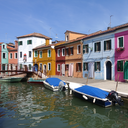
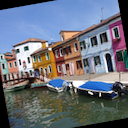
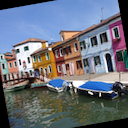
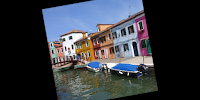
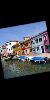


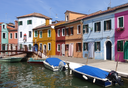
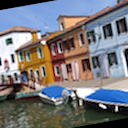
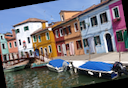
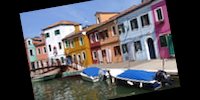
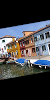

In [162]:
def experiment_rotate_image_about_center(scale=1.0) -> None:
  original = EXAMPLE_IMAGE
  for image in [original, original[20:108]]:
    new_shapes = [original.shape[:2], image.shape[:2], (100, 200), (100, 50)]
    images = {
        f'{i}: {new_shape}': rotate_image_about_center(
            image, np.radians(10), new_shape, scale=scale, boundary='constant')
        for i, new_shape in enumerate(new_shapes)
    }
    images = {'image': image, **images}
    media.show_images(images)

experiment_rotate_image_about_center()

In [163]:
# Export: outside library.

def overwrite_outside_circle(image: _NDArray, cval: Any = 0, margin: float = 0.0) -> _NDArray:
  shape = np.array(image.shape[:2])
  cval = np.broadcast_to(cval, image.shape[2])
  radius = min(shape) / 2 - margin
  mapped_radius = np.linalg.norm(np.indices(tuple(shape)).T + 0.5 - (shape / 2), axis=-1).T
  outside_circle = mapped_radius >= radius
  image = image.copy()
  image[outside_circle] = cval
  return image

# media.show_image(overwrite_outside_circle(EXAMPLE_IMAGE))


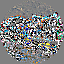
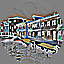
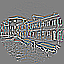
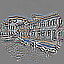
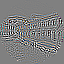
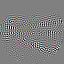
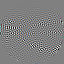
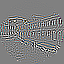
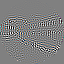
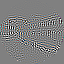
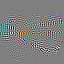
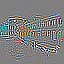
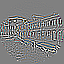
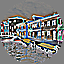
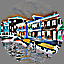
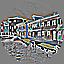

In [164]:
def experiment_compare_successive_rotations(num_rotations=7, gamma='identity') -> None:
  original = resize(EXAMPLE_IMAGE, np.array(EXAMPLE_IMAGE.shape[:2]) // 2)
  images = {}
  original = media.to_float01(original)  # not linear space
  original_cropped = overwrite_outside_circle(original)
  filters = [f for f in FILTERS if f not in 'box trapezoid narrowbox'.split()]
  for filter in filters:
    image = rotate_image_about_center(
        original, math.tau / num_rotations, num_rotations=num_rotations, filter=filter, gamma=gamma)
    image = overwrite_outside_circle(image)
    psnr = get_psnr(image, original_cropped)
    if 1:
      image = (image - original_cropped) * 5 + 0.5
    images[f'{filter}: {psnr:.1f} dB'] = image
  media.show_images(images, columns=6, ylabel=f'gamma={gamma}', height=original.shape[0] * 2)

experiment_compare_successive_rotations(gamma='identity')

if 0:
  # This may be more correct but in fact it reduces PSNR!
  # It may be that the signal squaring induces more aliasing.
  display_markdown('&nbsp;')
  experiment_compare_successive_rotations(gamma='power2')

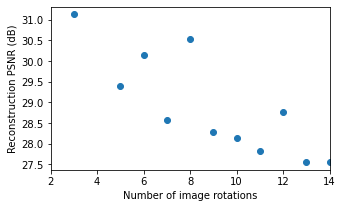

In [165]:
def experiment_plot_psnr_for_num_rotations(filter='lanczos5') -> None:
  original = resize(EXAMPLE_IMAGE, np.array(EXAMPLE_IMAGE.shape[:2]) // 2)
  _, ax = plt.subplots(figsize=(5, 3))
  x = [i for i in range(2, 15) if i not in [2, 4]]
  psnrs = []
  for num_rotations in x:
    image = rotate_image_about_center(
        original, math.tau / num_rotations, num_rotations=num_rotations, filter=filter)
    psnrs.append(get_psnr(overwrite_outside_circle(image), overwrite_outside_circle(original)))
  ax.scatter(x, psnrs)
  ax.set_xlim(left=2, right=14)
  ax.set_xlabel('Number of image rotations')
  ax.set_ylabel('Reconstruction PSNR (dB)')

experiment_plot_psnr_for_num_rotations()


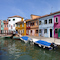
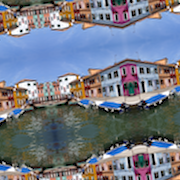
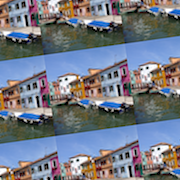
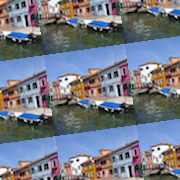
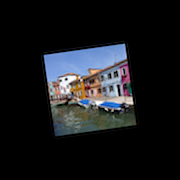
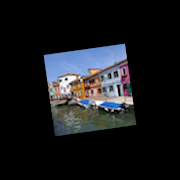
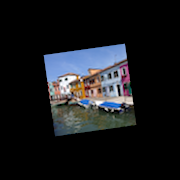
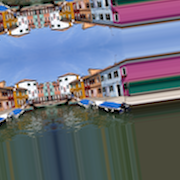
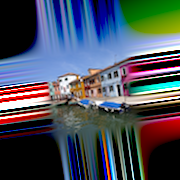

In [166]:
def experiment_visualize_rotation_boundaries(
    degrees=8, scale=2.2, src_size=60, dst_size=180) -> None:
  original_image = resize(EXAMPLE_IMAGE, (src_size,) * 2)
  matrix = rotation_about_center_in_2d(original_image.shape[:2], np.radians(degrees), scale=scale)
  images = {
      boundary: resample_affine(original_image, (dst_size,) * 2, matrix[:-1], boundary=boundary)
      for boundary in BOUNDARIES
  }
  images = {'original image': original_image, **images}
  assert all(image.dtype == np.uint8 for image in images.values())
  media.show_images(images, height=180, columns=5)

experiment_visualize_rotation_boundaries()

In [167]:
def experiment_with_boundary_antialiasing(degrees=8, scale=1.5, src_size=64, dst_size=128) -> None:
  original_image = resize(EXAMPLE_IMAGE, (src_size,) * 2)
  matrix = rotation_about_center_in_2d(original_image.shape[:2], np.radians(degrees), scale=scale)
  images = {}
  for boundary_antialiasing, gamma in [(False, 'power2'), (True, 'power2'), (True, 'identity')]:
    title = f'boundary_antialiasing={boundary_antialiasing} &nbsp; {gamma}'
    boundary = Boundary(override_value=UnitDomainOverrideExteriorValue(
        boundary_antialiasing=boundary_antialiasing))
    images[title] = resample_affine(original_image, (dst_size,) * 2, matrix[:-1],
                                    boundary=boundary, gamma=gamma)[:80]
  media.show_images(images, height=160)

experiment_with_boundary_antialiasing()

Conclusion: the middle result is best, with boundary antialiasing enabled,
and with filtering in linear space (after conversion from/to `power2` lightness space).

In [168]:
def experiment_zoom_image(original_image, num_frames=60) -> None:
  """Here we vary only the prefilter, keeping constant the default reconstruction filter."""
  videos = collections.defaultdict(list)
  for frame_index in range(num_frames):
    # scale = 0.7 + 0.35 * (frame_index + 0.5) / num_frames
    scale = 0.7 * (1.1 / 0.7)**((frame_index + 0.5) / num_frames)
    for filter in 'box trapezoid lanczos3'.split():
      new_image = resize(original_image, original_image.shape,
                         translate=(1 - scale) / 2, scale=scale, prefilter=filter)
      videos[f'resize filter={filter}'].append(new_image)
  media.show_videos(videos, height=original_image.shape[0] * 2, border=True, fps=10)

experiment_zoom_image(resize(EXAMPLE_IMAGE, (128, 128)))
experiment_zoom_image(0.1 + 0.8 * media.to_float01(
    example_vector_graphics_image())[220:980, 210:1240][490:, 470:][:80, :128])

# - minifying with 'box' has terrible temporal behavior!
# - 'trapezoid' is much better; however, for photos, 'lanczos3' is still best.
# try high-frequency test pattern image?

In [169]:
def experiment_zoom_rotate_image(src_size=128, dst_size=128, num_frames=60) -> None:
  """The `resampler` function lacks a prefilter, so shows aliasing during minification."""
  original_image = resize(EXAMPLE_IMAGE, (src_size,) * 2)
  videos = collections.defaultdict(list)
  for frame_index in range(num_frames):
    angle = (frame_index + 0.5) / num_frames * (0.02 * math.tau)
    # scale = 0.7 + 0.35 * (frame_index + 0.5) / num_frames
    # scale = 0.4 + 0.9 * (frame_index + 0.5) / num_frames
    scale = 0.4 * (1.4 / 0.4)**((frame_index + 0.5) / num_frames)
    matrix = rotation_about_center_in_2d(original_image.shape[:2], angle, scale=1.0 / scale)
    for filter in 'box lanczos3'.split():  # no 'trapezoid'
      new_image = resample_affine(
          original_image, (dst_size,) * 2, matrix[:-1], filter=filter, boundary='wrap')
      videos[f'resample filter={filter}'].append(new_image)
  media.show_videos(videos, height=dst_size * 2, border=True, fps=10)

if 1:
  experiment_zoom_rotate_image()

## <a name="Gradient-backpropagation"></a>Gradient backpropagation

- Tensorflow gradient-descent optimization:

In [170]:
def test_tensorflow_optimize_image_for_desired_upsampling(
    operation='resize', method='gradient_tape', num_steps=30, debug=False,
    src_shape=(8, 8, 3), dst_shape=(16, 16), filter='triangle') -> None:
  import tensorflow as tf
  array_np = np.full(src_shape, 0.5, dtype=np.float32)
  array = tf.Variable(tf.convert_to_tensor(array_np))
  desired = resize(EXAMPLE_IMAGE, dst_shape, gamma='identity', dtype=np.float32)
  coords = np.moveaxis(np.indices(dst_shape) + 0.5, 0, -1) / dst_shape

  def get_keras_resize_model() -> tf.keras.Model:
    x_in = tf.keras.Input(shape=src_shape, batch_size=1)
    x = tf.keras.layers.Lambda(lambda x: resize(
        x, (x.shape[0], *dst_shape[:2]), filter=filter))(x_in)
    return tf.keras.Model(inputs=x_in, outputs=x)

  keras_resize_model = get_keras_resize_model()
  # keras_resize_model.summary()

  def model(array) -> tf.Tensor:
    functions: Dict[str, Callable[[], tf.Tensor]] = {
        'resize': lambda: resize(array, dst_shape, filter=filter),
        'resample': lambda: resample(array, coords, filter=filter),
        'keras_resize': lambda: keras_resize_model(array[None])[0],
    }
    return functions[operation]()

  def compute_loss(upsampled) -> tf.Tensor:
    # The learning_rate must be adapted to the magnitude of the loss value,
    # which changes between reduce_sum() and reduce_mean().
    return tf.math.reduce_mean(tf.math.squared_difference(upsampled, desired))

  if method == 'gradient_tape':
    learning_rate = 1e2  # rms_loss=0.0622 after 100 steps
    for _ in range(num_steps):
      with tf.GradientTape() as tape:
        loss = compute_loss(model(array))
      gradient = tape.gradient(loss, array)
      array.assign_sub(learning_rate * gradient)
  elif method == 'adam':
    learning_rate = 1e-1  # rms_loss=0.0622 after 100 steps
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for _ in range(num_steps):
      opt.minimize(lambda: compute_loss(model(array)), [array])
  else:
    raise AssertionError(f'Unknown method {method}.')

  upsampled = model(array)
  rms = get_rms(upsampled, desired)
  if debug:
    print(f'rms_loss={rms:.4f}')
    images = {'optimized': array, 'upsampled': upsampled, 'desired': desired}
    media.show_images(images, height=80, border=True)
  assert rms < 0.07, (operation, method)

def test_tensorflow_optimize_image_for_desired_upsamplings() -> None:
  for operation in ['resize', 'resample', 'keras_resize']:
    for method in ['gradient_tape', 'adam']:
      test_tensorflow_optimize_image_for_desired_upsampling(operation=operation, method=method)

test_tensorflow_optimize_image_for_desired_upsamplings()

- Torch gradient-descent optimization:

In [171]:
def test_torch_optimize_image_for_desired_upsampling(
    src_shape=(8, 8, 3), dst_shape=(16, 16), num_steps=20) -> None:
  import torch

  configs = [
      ('resize', 'reflect', 'box', 'float32'),
      ('resample', 'border', 'cubic', 'float64'),
      ('resize', 'wrap', 'trapezoid', 'float64'),
      ('resample', 'reflect', 'omoms5', 'float32'),
      ('resize', 'quadratic', 'lanczos3', 'float32'),
      ('resample', 'constant', 'cardinal5', 'float64'),
      ('resize', 'clamp', 'impulse', 'float32'),
      ('resample', 'natural', 'cardinal3', 'float64'),
  ]
  for config in configs:
    operation, boundary, filter, dtype = config
    array_np = np.full(src_shape, 0.5, dtype=dtype)
    array = torch.tensor(array_np, requires_grad=True)
    desired = torch.as_tensor(resize(EXAMPLE_IMAGE, dst_shape, gamma='identity', dtype=dtype))
    coords = np.moveaxis(np.indices(dst_shape) + 0.5, 0, -1) / dst_shape

    def model(array) -> _TorchTensor:
      kwargs: Dict[str, Any] = dict(boundary=boundary, filter=filter, cval=(0.8, 0.5, 0.4))
      functions: Dict[str, Callable[[], Any]] = {
          'resize': lambda: resize(array, dst_shape, **kwargs),
          'resample': lambda: resample(array, coords, **kwargs),
      }
      return functions[operation]()

    def compute_loss(upsampled) -> _TorchTensor:
      return torch.linalg.norm(upsampled - desired)

    # https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
    learning_rate = 1e-1  # rms_loss=0.0622 after 100 steps
    optimizer = torch.optim.SGD([array], lr=learning_rate)
    for _ in range(num_steps):
      loss = compute_loss(model(array))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    upsampled = model(array).detach()
    rms = get_rms(upsampled, desired)
    assert rms < 0.08, (config, rms)

test_torch_optimize_image_for_desired_upsampling()

In [172]:
def test_torch_gradients_using_gradcheck(src_shape=(7, 7), dst_shape=(13, 13)) -> None:
  import torch
  for filter in ['cubic', 'cardinal3']:
    coords = np.moveaxis(np.indices(dst_shape) + 0.5, 0, -1) / dst_shape
    functions = [
        lambda array: resize(array, dst_shape, filter=filter),
        lambda array: resample(array, coords, filter=filter),
    ]
    array_np = np.random.random(src_shape).astype('float64', copy=False)
    array = torch.tensor(array_np, requires_grad=True)
    for function in functions:
      assert torch.autograd.gradcheck(function, [array], rtol=0, atol=1e-6)

test_torch_gradients_using_gradcheck()

- Use Tensorflow to solve for an image whose spiral upsampling
matches a desired image:


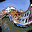
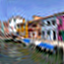
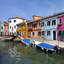


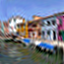
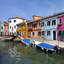

In [173]:
def experiment_image_optimized_for_spiral_resampling(
    num_steps=30, src_shape=(32, 32, 3), dst_shape=(64, 64),
    regularization_weight=0.0, smoothness_weight=0.0) -> None:
  import tensorflow as tf
  array_np = np.full(src_shape, 0.5, dtype=np.float32)
  array = tf.Variable(tf.convert_to_tensor(array_np))
  desired = resize(EXAMPLE_IMAGE, dst_shape, gamma='identity', dtype=np.float32)

  yx = ((np.indices(dst_shape).T + 0.5) / dst_shape - 0.5).T  # [-0.5, 0.5]^2
  radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
  angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
  coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5

  def model(array) -> tf.Tensor:
    return resample(array, coords)

  def compute_loss(array, upsampled) -> tf.Tensor:
    data_loss = tf.math.reduce_mean(tf.math.squared_difference(upsampled, desired))
    regularization_loss = regularization_weight * tf.math.reduce_mean(tf.norm(array, axis=-1))
    smoothness_loss = smoothness_weight * tf.image.total_variation(array) / (
        tf.size(array, out_type=tf.float32) / 3)
    return data_loss + regularization_loss + smoothness_loss

  learning_rate = 1e-1  # rms_loss=0.0622 after 100 steps
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  for _ in range(num_steps):
    opt.minimize(lambda: compute_loss(array, model(array)), [array])

  resampled = model(array)
  images = {'optimized': array, 'resampled': resampled, 'desired': desired}
  media.show_images(images, height=128, border=True)

# Regularization fills unconstrained regions with small values (black).
experiment_image_optimized_for_spiral_resampling(regularization_weight=1e-3)

# Smoothness fills unconstrained regions with diffused content.
experiment_image_optimized_for_spiral_resampling(smoothness_weight=1e-4)

## Block partition and timing

In [174]:
def test_blocking_using_image_rotation(max_block_size, src_size=64, dst_size=256) -> None:
  for arraylib in ARRAYLIBS:
    original_image = _make_array(resize(EXAMPLE_IMAGE, (src_size,) * 2), arraylib)

    def rotate_image(degrees=8, scale=2.2, **kwargs) -> _Array:
      matrix = rotation_about_center_in_2d(
          original_image.shape[:2], np.radians(degrees), scale=scale)
      return resample_affine(
          original_image, (dst_size,) * 2, matrix[:-1], boundary='reflect', **kwargs)

    reference = rotate_image()
    check_eq(_arr_arraylib(reference), arraylib)
    result = rotate_image(max_block_size=max_block_size)
    check_eq(_arr_numpy(result), _arr_numpy(reference))

if 1:
  test_blocking_using_image_rotation(max_block_size=1_000)

In [175]:
def experiment_find_the_best_max_block_size(src_size=64, dst_size=4096) -> None:
  original_image_numpy = resize(EXAMPLE_IMAGE, (src_size,) * 2)

  for arraylib in ARRAYLIBS:
    print(f'\n# {arraylib}:')
    original_image = _make_array(original_image_numpy, arraylib)

    sizes = [4_000, 10_000, 40_000, 100_000, 400_000, 800_000, 4_000_000]
    # sizes += [8_000_000, 0]  # Can lead to out-of-memory on this large test.
    for max_block_size in sizes:

      def rotate_image(degrees=8, scale=2.2) -> _Array:
        matrix = rotation_about_center_in_2d(
            original_image.shape[:2], np.radians(degrees), scale=scale)
        return resample_affine(original_image, (dst_size,) * 2, matrix[:-1],
                               boundary='reflect', max_block_size=max_block_size)

      elapsed = hh.get_time(rotate_image)
      print(f'# max_block_size={max_block_size:10_} {elapsed:.3f} s')

if EFFORT >= 2:
  experiment_find_the_best_max_block_size()
# 2021-11-05 Colab CPU (Intel Xeon CPU E5-2650 v4 @ 2.20GHz):
# max_block_size=     4_000 24.637 s
# max_block_size=    40_000 23.852 s
# max_block_size=   400_000 23.124 s
# max_block_size=   800_000 23.078 s
# max_block_size= 4_000_000 22.768 s
# max_block_size= 8_000_000 23.178 s
# max_block_size=         0 35.138 s
## Conclusion: it's a worthwhile improvement, with max_block_size = ~4_000_000.

# New 2022-07-09: memory seems higher now?  AMD Ryzen 9 5900X: best max_block_size = 40_000

# numpy:
# max_block_size=     4_000 11.148 s
# max_block_size=    10_000 10.682 s
# max_block_size=    40_000 10.301 s
# max_block_size=   100_000 11.423 s
# max_block_size=   400_000 12.285 s
# max_block_size=   800_000 12.772 s
# max_block_size= 4_000_000 13.195 s
# max_block_size= 8_000_000 13.930 s
# max_block_size=         0 14.481 s

# tensorflow:
# max_block_size=     4_000 12.112 s
# max_block_size=    10_000 9.869 s
# max_block_size=    40_000 8.055 s
# max_block_size=   100_000 8.761 s
# max_block_size=   400_000 11.052 s
# max_block_size=   800_000 10.833 s
# max_block_size= 4_000_000 12.151 s
# max_block_size= 8_000_000 13.554 s
# max_block_size=         0 14.521 s

# torch:
# max_block_size=     4_000 7.758 s
# max_block_size=    10_000 6.787 s
# max_block_size=    40_000 6.393 s
# max_block_size=   100_000 6.006 s
# max_block_size=   400_000 6.595 s
# max_block_size=   800_000 6.900 s
# max_block_size= 4_000_000 7.655 s
# max_block_size= 8_000_000 8.371 s
# max_block_size=         0 8.854 s

## Visualization of filters

The kernel is usually interpolating,
i.e., it has value $1$ at $x=0$ and value $0$ at all other integer coordinates.

TODO: more..

In [176]:
# pylint: disable-next=too-many-statements
def visualize_filters(filters: Mapping[str, Filter]) -> None:

  def analyze_filter(name: str, filter: Filter, ax=None) -> None:
    footnote = '*' if filter.requires_digital_filter else ''
    if isinstance(filter, TrapezoidFilter) and filter.radius == 0.0:
      filter = TrapezoidFilter(radius=0.75)  # Visualize some representative radius.
      footnote = '\u2020'
    radius = filter.radius
    # Mock that the filter is a partition of unity for accurate un-normalized integral
    # (e.g. 'lanczos3') and for raw interp_error (e.g. 'gaussian').
    filter_no_renorm = copy.copy(filter)
    filter_no_renorm.partition_of_unity = True

    if filter.name == 'impulse':
      interp_err = 0.0
      integral = 1.0
      x = np.array([-10.0, -0.01, 0.0, 0.01, 10.0])  # Fake for visualization.
      y = np.array([0.0, 0.0, 2.0, 0.0, 0.0])

    else:
      # Check that support radius is necessary and sufficient.
      assert filter(-radius + 0.1) != 0.0 and filter(radius - 0.1) != 0.0
      x = np.linspace(radius + 1e-6, radius + 3.0, 1_000)
      assert np.all(filter(x) == 0.0) and np.all(filter(-x) == 0.0)

      effective_radius = radius * (3 if filter.requires_digital_filter else 1)
      pad = math.ceil(effective_radius)
      src_size = pad * 2 + 1
      x = np.arange(-pad, pad + 1, dtype=np.float64)
      y = np.eye(src_size)[pad]
      scale = 25_000  # Dense enough for accurate integral.
      dst_size = pad * 2 * scale + 1
      x = resize(x, (dst_size,), gridtype='primal', filter='triangle')
      y = resize(y, (dst_size,), gridtype='primal', filter=filter_no_renorm)
      assert np.all(abs(y[[0, -1]]) < 1e-10)

      x_int = x[::scale]
      y_int = y[::scale]
      expected = np.where(x_int == 0.0, 1.0, 0.0)
      interp_err = abs(y_int - expected).sum()
      assert (interp_err < 1e-4) == filter.interpolating, interp_err
      interp_err = 0.0 if interp_err < 1e-7 else interp_err

      integral = y.sum() / (len(y) - 1) * 2.0 * pad
      # (Typically the discretized kernel is renormalized anyway.)
      assert (abs(integral - 1.0) < 1e-6) == filter.unit_integral, integral

      assert (abs(np.diff(y)) < 0.001).all() == filter.continuous

      num_plot_points = 1_001
      subsample = len(x) // num_plot_points
      x = np.concatenate(([-10.0], x[::subsample].tolist(), [10.0]))
      y = np.concatenate(([0.0], y[::subsample].tolist(), [0.0]))

    if ax is None:
      _, ax = plt.subplots(figsize=(5, 3))

    ax.plot(x, y)
    ax.set_xlim(-6.0, 6.0)
    ax.set_ylim(-0.25, 1.08)
    ax.yaxis.set_ticks([0.0, 1.0])
    ax.xaxis.set_ticks(np.arange(-6, 7, 2))
    info = [f'radius={radius:.2f}{footnote}',
            f'interp_err={interp_err:.4f}',
            f'integral={integral:.5f}']
    for i, line in enumerate(info):
      ax.text(0.9, 0.85 - 0.17 * i, line, fontsize=10.5)
    ax.set_title(f'{name}')

  media.set_max_output_height(2000)
  num_columns = 3
  num_rows = (len(filters) + num_columns - 1) // num_columns
  fig, axs = plt.subplots(num_rows, num_columns, figsize=(4.0 * num_columns, 2.5 * num_rows))
  for i, (name, filter) in enumerate(filters.items()):
    analyze_filter(name, filter, ax=axs.flat[i])
  for i in range(len(filters), len(axs.flat)):
    fig.delaxes(axs.flat[i])  # Or: axs.flat[i].axis('off').
  fig.tight_layout()
  plt.show()
  if any(filter.requires_digital_filter for filter in filters.values()):
    display_markdown(r'\* The effective radius is actually infinite due to the inverse convolution'
                     ' of the digital filter.')
  if any(isinstance(filter, TrapezoidFilter) and filter.radius == 0.0
         for filter in filters.values()):
    display_markdown('\u2020 The `trapezoid` radius is adjusted based on the scaling factor.')

In [177]:
# Export: outside library.
if 0:  # For debug.
  print(' '.join(FILTERS))
  visualize_filters({'hamming3': FILTERS['hamming3']})

<a name="Visualization-of-filters" id="Visualization-of-filters"></a>Visualization of filters:

In [178]:
# Export: outside library.
visualize_filters({**FILTERS, **OTHER_FILTERS})

\* The effective radius is actually infinite due to the inverse convolution of the digital filter.

† The `trapezoid` radius is adjusted based on the scaling factor.

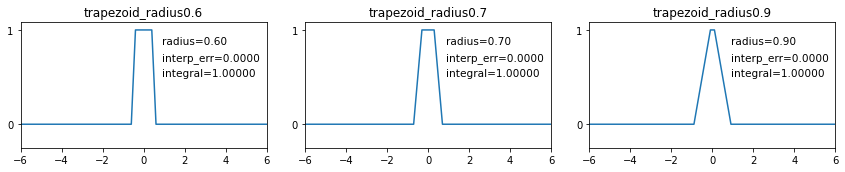

In [179]:
def visualize_trapezoid_filters() -> None:
  """This shows how the trapezoid filter morphs between the box and triangle filters."""
  filters = {f'trapezoid_radius{radius}': TrapezoidFilter(radius=radius)
             for radius in [0.6, 0.7, 0.9]}
  visualize_filters(filters)

visualize_trapezoid_filters()

In [180]:
def visualize_kaiser_filter_for_various_beta_values(radius=3.0) -> None:
  visualize_filters({f'kaiser_radius{radius}_beta{beta}': KaiserFilter(radius=radius, beta=beta)
                    for beta in [1.0, 2.0, 4.0, 7.0, 10.0, 20.0]})

visualize_kaiser_filter_for_various_beta_values()

In [181]:
def experiment_kaiser_filter_beta_parameters(n: int = 12, s: float = 2.0) -> None:
  # The two filter parameters are the number n of taps and the filter
  # half-width f_h.  The filter half-width f_h defines transition band;
  # high f_h in the low-res layers to maximize attenuation in the stopband;
  # low f_h in hig-res layers to recover image detail.
  for f_h in [s / 2, (np.sqrt(2) - 1) * (s / 2)]:
    # L is the spatial extent of the filter (2*radius); s is the sampling rate.
    # n is the number of discrete taps: odd for primal and even for dual.
    # L = 2 * radius = (n - 1) / s
    # Example: dual 2x upsampling; n=12; s=2; L=11/2; radius=11/4
    # Width of the transition band expressed as a fraction of s:
    delta_f = 2 * f_h / (s / 2)
    A = 2.285 * (n - 1) * np.pi * delta_f + 7.9  # Attenuation in dB.
    beta = (0.1102 * (A - 8.7) if A > 50 else
            0.5842 * (A - 21)**0.4 + 0.07886 * (A - 21) if 21 <= A <= 50 else
            0.0)
    hh.show(f_h, delta_f, A, beta)

experiment_kaiser_filter_beta_parameters()

f_h = 1.0, delta_f = 2.0, A = 165.8278626959589, beta = 17.315490469094673
f_h = 0.41421356237309515, delta_f = 0.8284271247461903, A = 73.31586260526218, beta = 7.120668059099892


In [182]:
def test_kaiser_filter_fractional_radius(radius=3, s=2.0, n=12, debug=False) -> None:
  i = np.arange(n, dtype=np.float64)
  x = (i - (n - 1) / 2) / s
  x = abs(x)
  beta = 4.0
  L = (n - 1) / s
  window = np.i0(beta * np.sqrt((1.0 - np.square(x / (L / 2))).clip(0.0, 1.0))) / np.i0(beta)
  f1 = np.where(x < radius, _sinc(x) * window, 0.0)
  f2 = KaiserFilter(radius=3, beta=beta)(x)
  f3 = KaiserFilter(radius=L/2, beta=beta)(x)  # L/2 == 2.75
  if debug:
    hh.show(np.i0([0.0, 4.0]))
    hh.show(i, x, L, window, f1, f2, f3)
  assert np.allclose(f1, f3)

test_kaiser_filter_fractional_radius()

## Best boundary rule for resize

In [183]:
def compare_boundary_rules_on_cropped_windows_of_images(
    images, scale, filter, num_windows, reference_filter='lanczos5', name='') -> None:
  """Determine the best boundary rule for resizing windows within images.

  The approach is to generate many random cropped windows from each image,
  obtain a groundtruth for the resized window from the *uncropped* content,
  and measure the MSE of the resized crop with respect to this groundtruth.

  All filtering is done in lightness space (i.e. with gamma='identity').
  """
  np.random.seed(1)
  # Note: 'linear' and 'linear_constant' are identical for resize() because the evaluated coordinate
  # is never outside the domain (even though the filter kernel does extend outside).
  boundaries = [b for b in BOUNDARIES
                if 'constant' not in b and b not in 'wrap tile reflect_clamp border'.split()]

  all_mse = collections.defaultdict(list)
  for image in images:
    for _ in range(num_windows):
      shape = 24, 48
      pad = 6 if scale == 5/6 else int(math.ceil(6 / min(scale, 1.0)))
      scaled_pad = must_be_int(pad * scale)
      broad_shape = shape[0] + pad * 2, shape[1] + pad * 2
      yx = (np.random.randint(image.shape[0] - broad_shape[0]),
            np.random.randint(image.shape[1] - broad_shape[1]))
      broad_window = image[tuple(slice(start, start + size)
                                for start, size in zip(yx, broad_shape))]
      window = broad_window[pad:-pad, pad:-pad]
      pixel_offset = 0 if scale != 1 else 0.25  # Quarter-pixel translation.

      new_broad_shape = must_be_int(np.array(broad_window.shape[:2]) * scale)
      reference = resize(broad_window, new_broad_shape, boundary='clamp',
                         filter=reference_filter, translate=(pixel_offset / new_broad_shape))
      reference = reference[scaled_pad:-scaled_pad, scaled_pad:-scaled_pad]

      images = {}
      for boundary in boundaries:
        new_shape = must_be_int(np.array(window.shape[:2]) * scale)
        resized = resize(window, new_shape, boundary=boundary, filter=filter,
                         translate=(pixel_offset / new_shape))
        with np.errstate(under='ignore'):
          mse = np.square(resized - reference).mean()
        all_mse[boundary].append(mse)

  mean_mse_boundary = sorted([(np.mean(mse), boundary) for boundary, mse in all_mse.items()])
  print(f'# Best rule for scale={scale:.3f} name={name} (PSNR):')
  for mean_mse, boundary in mean_mse_boundary:
    psnr = 10 * np.log10(1.0 / (mean_mse + 1e-20))
    print(f'# {boundary:15} {psnr:5.2f} dB')


def experiment_compare_accuracy_of_boundary_rules_using_cropped_windows(
    filters=('lanczos3',), num_windows=1_000, combined=True,
    scales=(2, 7/6, 1, 5/6, 1/2, 1/6)) -> None:
  images = {
      'photo1': media.to_float01(EXAMPLE_PHOTO),  # (480, 640)
      'vector1': media.to_float01(example_vector_graphics_image()),  # (3300, 2550)
  }
  for filter in filters:
    print(f'# Results for num_windows={num_windows} filter={filter}:\n')
    for scale in scales:
      kwargs = dict(scale=scale, filter=filter, num_windows=num_windows)
      if combined:
        compare_boundary_rules_on_cropped_windows_of_images(images.values(), name='all', **kwargs)
      else:
        for name, image in images.items():
          compare_boundary_rules_on_cropped_windows_of_images([image], name=name, **kwargs)
      print()


if EFFORT >= 2:
  experiment_compare_accuracy_of_boundary_rules_using_cropped_windows(
      filters=['lanczos3', 'cubic'])
else:
  experiment_compare_accuracy_of_boundary_rules_using_cropped_windows(
      num_windows=40, scales=[2, 7/6, 1, 5/6, 1/2])

# Results for num_windows=40 filter=lanczos3:

# Best rule for scale=2.000 name=all (PSNR):
# reflect         39.60 dB
# clamp           39.46 dB
# natural         39.36 dB
# linear          39.07 dB
# quadratic       38.00 dB

# Best rule for scale=1.167 name=all (PSNR):
# reflect         42.65 dB
# clamp           42.62 dB
# linear          42.41 dB
# natural         42.34 dB
# quadratic       41.81 dB

# Best rule for scale=1.000 name=all (PSNR):
# reflect         39.90 dB
# clamp           39.74 dB
# natural         39.64 dB
# linear          39.32 dB
# quadratic       38.22 dB

# Best rule for scale=0.833 name=all (PSNR):
# linear          43.47 dB
# clamp           43.47 dB
# natural         43.40 dB
# quadratic       43.38 dB
# reflect         43.26 dB

# Best rule for scale=0.500 name=all (PSNR):
# clamp           39.04 dB
# linear          38.84 dB
# reflect         38.81 dB
# natural         38.60 dB
# quadratic       37.63 dB



Conclusions (particularly from the slower results archived in the next cell):
- `'reflect'` is the best boundary rule for upsamping, and
- `'clamp'` is always among the best boundary rules for downsampling,
  especially for `'lanczos3'`.
- For downsampling with smaller filter kernels like `'cubic'`,
  the rules `'linear'` and `'reflect'` also work well.

In [184]:
# # Results for num_windows=2000 filter=lanczos3:

# Best rule for scale=6.000 name=all (PSNR):
# reflect         39.49 dB
# clamp           39.38 dB
# natural         39.33 dB
# linear          38.51 dB
# quadratic       36.58 dB

# Best rule for scale=2.000 name=all (PSNR):
# reflect         40.20 dB
# clamp           40.12 dB
# natural         40.01 dB
# linear          39.47 dB
# quadratic       38.05 dB

# Best rule for scale=1.167 name=all (PSNR):
# reflect         42.99 dB
# clamp           42.97 dB
# natural         42.73 dB
# linear          42.65 dB
# quadratic       41.89 dB

# Best rule for scale=1.000 name=all (PSNR):
# reflect         40.16 dB
# clamp           40.08 dB
# natural         39.97 dB
# linear          39.43 dB
# quadratic       38.07 dB

# Best rule for scale=0.833 name=all (PSNR):
# linear          43.95 dB
# clamp           43.95 dB
# quadratic       43.87 dB
# natural         43.86 dB
# reflect         43.70 dB

# Best rule for scale=0.500 name=all (PSNR):
# clamp           39.83 dB
# linear          39.64 dB
# reflect         39.41 dB
# natural         39.38 dB
# quadratic       38.39 dB

# Best rule for scale=0.167 name=all (PSNR):
# clamp           34.39 dB
# natural         33.43 dB
# reflect         33.15 dB
# linear          32.25 dB
# quadratic       22.78 dB

# # Results for num_windows=2000 filter=cubic:

# Best rule for scale=6.000 name=all (PSNR):
# reflect         35.94 dB
# natural         35.91 dB
# clamp           35.88 dB
# linear          35.66 dB
# quadratic       34.57 dB

# Best rule for scale=2.000 name=all (PSNR):
# reflect         36.11 dB
# natural         36.08 dB
# clamp           36.06 dB
# linear          35.96 dB
# quadratic       35.24 dB

# Best rule for scale=1.167 name=all (PSNR):
# reflect         37.11 dB
# clamp           37.11 dB
# natural         37.11 dB
# linear          37.11 dB
# quadratic       37.05 dB

# Best rule for scale=1.000 name=all (PSNR):
# reflect         36.01 dB
# natural         35.98 dB
# clamp           35.97 dB
# linear          35.87 dB
# quadratic       35.20 dB

# Best rule for scale=0.833 name=all (PSNR):
# quadratic       37.64 dB
# linear          37.60 dB
# reflect         37.59 dB
# clamp           37.58 dB
# natural         37.56 dB

# Best rule for scale=0.500 name=all (PSNR):
# linear          34.75 dB
# reflect         34.71 dB
# clamp           34.68 dB
# quadratic       34.68 dB
# natural         34.47 dB

# Best rule for scale=0.167 name=all (PSNR):
# clamp           31.95 dB
# reflect         31.59 dB
# linear          31.57 dB
# natural         31.34 dB
# quadratic       22.09 dB

## <a name="Best-filter-for-resize"></a>Best filter for resize

In [185]:
def experiment_best_downsampling_filter(scale=0.4, clip=False, debug=False) -> None:
  images = [
      media.to_float01(EXAMPLE_PHOTO),  # (480, 640)
      media.to_float01(example_vector_graphics_image())[220:980, 210:1240][:, :500],
      # (3300, 2550) -> (760, 1030) -> (760, 500)
  ]
  crop = [np.s_[100:120, 141:161], np.s_[531:551, 143:163]]
  filters = ('box trapezoid triangle mitchell cubic hamming3 '
             'cardinal3 lanczos3 omoms5 lanczos10').split()
  cropped: List[Dict[str, _NDArray]] = [{} for _ in range(len(images))]
  print('# PSNR and SSIM results for (1) natural photos and (2) vector graphics:')
  for filter in filters:
    all_mse, all_psnr, all_ssim = [], [], []
    for image_index, image in enumerate(images):
      new_shape = (np.array(image.shape[:2]) * scale + 0.5).astype(int)
      downsampled = resize(image, new_shape, filter=filter)
      if clip:
        downsampled = downsampled.clip(0.0, 1.0)
      reconstructed = resize(downsampled, image.shape[:2], filter='lanczos3')
      if clip:
        reconstructed = reconstructed.clip(0.0, 1.0)
      cropped[image_index][filter] = reconstructed[crop[image_index]]
      mse = np.square(reconstructed - image).mean()
      all_mse.append(mse)
      all_psnr.append(10 * np.log10(1.0 / (mse + 1e-20)))
      all_ssim.append(get_ssim(reconstructed, image))

    str_mse = ' '.join(f'{psnr:5.2f}' for psnr in all_psnr)
    mean_mse = np.mean(all_mse)
    mean_psnr = 10 * np.log10(1.0 / (mean_mse + 1e-20))
    str_ssim = ' '.join(f'{ssim:5.3f}' for ssim in all_ssim)
    mean_ssim = np.mean(all_ssim)
    print(f'# {filter:10} PSNR:({str_mse}) mean={mean_psnr:5.2f}'
          f'  SSIM:({str_ssim}) mean={mean_ssim:5.3f}')

  for image_dict in cropped:
    media.show_images(image_dict, border=True, height=100)
  if debug:
    GRAY_FROM_RGB = [0.2989, 0.5870, 0.1140]
    array = media.to_uint8(cropped[1]['lanczos10'] @ GRAY_FROM_RGB)
    show_grid_values(array, figsize=(10, 14))

experiment_best_downsampling_filter()

# PSNR and SSIM results for (1) natural photos and (2) vector graphics:
# box        PSNR:(23.89 18.29) mean=20.24  SSIM:(0.816 0.890) mean=0.853
# trapezoid  PSNR:(24.24 18.76) mean=20.69  SSIM:(0.824 0.898) mean=0.861
# triangle   PSNR:(23.87 18.02) mean=20.02  SSIM:(0.803 0.883) mean=0.843
# mitchell   PSNR:(23.97 18.22) mean=20.20  SSIM:(0.808 0.886) mean=0.847
# cubic      PSNR:(24.32 18.87) mean=20.79  SSIM:(0.827 0.897) mean=0.862
# hamming3   PSNR:(24.44 19.07) mean=20.97  SSIM:(0.833 0.896) mean=0.864
# cardinal3  PSNR:(24.46 19.10) mean=21.00  SSIM:(0.834 0.896) mean=0.865
# lanczos3   PSNR:(24.47 19.12) mean=21.02  SSIM:(0.836 0.894) mean=0.865
# omoms5     PSNR:(24.52 19.21) mean=21.10  SSIM:(0.838 0.892) mean=0.865
# lanczos10  PSNR:(24.53 19.22) mean=21.11  SSIM:(0.839 0.884) mean=0.862


Conclusions for downsampling (including several surprises):
- The `'lanczos10'` filter has the best PSNR and SSIM result on natural photos.
- However, on *vector* graphics, **`'trapezoid'` has the best SSIM score**,
  and `'lanczos10'` is terrible due to ringing.
- The `'trapezoid'` filter has a PSNR result that exceeds that of `'cubic'`,
  although it is not as good as `'lanczos3'`.
- The `'mitchell'` filter is inferior to `'cubic'` on all images, for both MSE and SSIM.
- Setting `clip=True` does not affect the photo.
  For the vector graphics, it reduces PSNR but helps SSIM.
- The cardinal B-spline and O-MOMS filters behave similar to Lanczos.
- Overall, `'trapezoid'` is best for vector graphics, and
  `'lanczos3'` is good for natural images like photos.

In [186]:
# Copy of results 2021-10-23:
# PSNR and SSIM results for (1) natural photos and (2) vector graphics:
# box        PSNR:(23.89 18.29) mean=20.24  SSIM:(0.816 0.890) mean=0.853
# trapezoid  PSNR:(24.24 18.76) mean=20.69  SSIM:(0.824 0.898) mean=0.861
# triangle   PSNR:(23.87 18.02) mean=20.02  SSIM:(0.803 0.883) mean=0.843
# mitchell   PSNR:(23.97 18.22) mean=20.20  SSIM:(0.808 0.886) mean=0.847
# cubic      PSNR:(24.32 18.87) mean=20.79  SSIM:(0.827 0.897) mean=0.862
# hamming3   PSNR:(24.44 19.07) mean=20.97  SSIM:(0.833 0.896) mean=0.864
# cardinal3  PSNR:(24.46 19.10) mean=21.00  SSIM:(0.834 0.896) mean=0.865
# lanczos3   PSNR:(24.47 19.12) mean=21.02  SSIM:(0.836 0.894) mean=0.865
# omoms5     PSNR:(24.52 19.21) mean=21.10  SSIM:(0.838 0.892) mean=0.865
# lanczos10  PSNR:(24.53 19.22) mean=21.11  SSIM:(0.839 0.884) mean=0.862

In [187]:
def experiment_best_upsampling_filter(scale=2.0, clip=False, debug=False) -> None:
  images = [
      media.to_float01(EXAMPLE_PHOTO),  # (480, 640)
      media.to_float01(example_vector_graphics_image())[220:980, 210:1240][:, :500],
      # (3300, 2550) -> (760, 1030) -> (760, 500)
  ]
  crop = [np.s_[100:120, 141:161], np.s_[531:551, 143:163]]
  filters = 'cubic hamming3 cardinal3 lanczos3 lanczos5 omoms5 lanczos10'.split()
  cropped: List[Dict[str, _NDArray]] = [{} for _ in range(len(images))]
  for filter in filters:
    all_mse, all_psnr, all_ssim = [], [], []
    for image_index, image in enumerate(images):
      new_shape = (np.array(image.shape[:2]) / scale + 0.5).astype(int)
      # As analyzed above, best prefilters for photos and vector graphics:
      prefilter = {0: 'lanczos5', 1: 'trapezoid'}[image_index]
      downsampled = resize(image, new_shape, filter=prefilter)
      if clip:
        downsampled = downsampled.clip(0.0, 1.0)
      reconstructed = resize(downsampled, image.shape[:2], filter=filter)
      if clip:
        reconstructed = reconstructed.clip(0.0, 1.0)
      cropped[image_index][filter] = reconstructed[crop[image_index]]
      mse = np.square(reconstructed - image).mean()
      all_mse.append(mse)
      all_psnr.append(10 * np.log10(1.0 / (mse + 1e-20)))
      all_ssim.append(get_ssim(reconstructed, image))

    str_mse = ' '.join(f'{psnr:5.2f}' for psnr in all_psnr)
    mean_mse = np.mean(all_mse)
    mean_psnr = 10 * np.log10(1.0 / (mean_mse + 1e-20))
    str_ssim = ' '.join(f'{ssim:5.3f}' for ssim in all_ssim)
    mean_ssim = np.mean(all_ssim)
    print(f'# {filter:10} PSNR:({str_mse}) {mean_psnr:5.2f}  SSIM:({str_ssim}) {mean_ssim:5.3f}')

  for image_dict in cropped:
    media.show_images(image_dict, border=True, height=100)
  if debug:
    GRAY_FROM_RGB = [0.2989, 0.5870, 0.1140]
    array = media.to_uint8(cropped[1]['lanczos10'] @ GRAY_FROM_RGB)
    show_grid_values(array, figsize=(10, 14))

experiment_best_upsampling_filter()

# cubic      PSNR:(25.60 20.54) 22.37  SSIM:(0.874 0.935) 0.905
# hamming3   PSNR:(25.84 20.93) 22.73  SSIM:(0.882 0.936) 0.909
# cardinal3  PSNR:(25.89 20.98) 22.77  SSIM:(0.884 0.935) 0.909
# lanczos3   PSNR:(25.90 21.05) 22.83  SSIM:(0.885 0.935) 0.910
# lanczos5   PSNR:(26.04 21.15) 22.94  SSIM:(0.888 0.930) 0.909
# omoms5     PSNR:(26.04 21.15) 22.94  SSIM:(0.888 0.930) 0.909
# lanczos10  PSNR:(26.09 21.11) 22.92  SSIM:(0.890 0.918) 0.904


Conclusions:
- For upsampling, the filters `'box'`, `'trapezoid'`, and `'mitchell'`
  perform so poorly that they are omitted in these results.
- On natural photos, `'lanczos10'` has the best PSNR and SSIM,
  although `'lanczos3'` is not far behind.
- On vector graphics, `'lanczos5'` has the best PSNR,
  and `'lanczos3'` has the best SSIM.
  The problem is that the higher-order Lanczos filters introduce
  too much ringing near step discontinuities.
- The cardinal B-spline and O-MOMS filters have similar behavior to Lanczos.
- Overall, `'lanczos3'` performs well on all images,
  although `'lanczos10'` is best if the images are known to be natural photos.

In [188]:
# Copy of results 2021-10-23:
# cubic      PSNR:(25.60 20.54) 22.37  SSIM:(0.874 0.935) 0.905
# hamming3   PSNR:(25.84 20.93) 22.73  SSIM:(0.882 0.936) 0.909
# cardinal3  PSNR:(25.89 20.98) 22.77  SSIM:(0.884 0.935) 0.909
# lanczos3   PSNR:(25.90 21.05) 22.83  SSIM:(0.885 0.935) 0.910
# lanczos5   PSNR:(26.04 21.15) 22.94  SSIM:(0.888 0.930) 0.909
# omoms5     PSNR:(26.04 21.15) 22.94  SSIM:(0.888 0.930) 0.909
# lanczos10  PSNR:(26.09 21.11) 22.92  SSIM:(0.890 0.918) 0.904

## Best gamma for resampling

In [189]:
def dither(image: _NDArray, num_levels: int, offsets: Iterable[Tuple[int, int]],
           weights: Iterable[float]) -> _NDArray:
  """Dither an image.

  From https://github.com/scikit-image/skimage-demos/blob/main/dither.py and
  https://github.com/SixLabors/ImageSharp/blob/master/src/ImageSharp/Processing/Processors/Dithering/DHALF.TXT

  Args:
    image: Source image with float type.
    num_levels: Number of quantization levels.
    offsets: Tuples (dy, dx) over which the quantization error is distributed.
    weights: Weights for the propagated error.

  Returns:
    A new image containing values [0, 1, ..., num_levels - 1].
  """
  image = np.array(image)  # Intentional copy.
  check_eq(image.ndim, 2)
  assert np.issubdtype(image.dtype, np.floating)
  offsets = tuple(offsets)
  weights = np.asarray(weights, dtype=np.float32)
  weights = tuple(weights / weights.sum())
  height, width = image.shape

  out = np.zeros_like(image, dtype=np.int32)
  for y in range(height):
    for x in range(width):
      # Quantize.
      out[y, x] = image[y, x] * (num_levels - np.finfo(float).eps)
      # Propagate the quantization residual.
      residual = image[y, x] - out[y, x] / (num_levels - 1)
      for (dy, dx), weight in zip(offsets, weights):
        yy, xx = y + dy, x + dx
        if yy < height and 0 <= xx < width:
          image[yy, xx] += residual * weight

  return out

def floyd_steinberg_dither(image: _NDArray, num_levels: int) -> _NDArray:
  offsets = [(0, 1), (1, -1), (1, 0), (1, 1)]
  weights = [7, 3, 5, 1]
  return dither(image, num_levels, offsets, weights)

def filter_lite_dither(image: _NDArray, num_levels: int) -> _NDArray:
  """Evaluate Sierra's "Filter Lite"."""
  offsets = [(0, 1), (1, -1), (1, 0)]
  weights = [2, 1, 1]
  return dither(image, num_levels, offsets, weights)

def experiment_visualize_dither() -> None:
  image = np.indices((64, 256))[1] / 255.0
  num_levels = 4
  sierra = filter_lite_dither(image, num_levels) / (num_levels - 1)
  floyd = floyd_steinberg_dither(image, num_levels) / (num_levels - 1)
  images = {'original': image, 'sierra': sierra, 'floyd': floyd}
  media.show_images(images, vmin=0, vmax=1, border=True)

if EFFORT >= 2:
  experiment_visualize_dither()


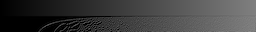

In [190]:
def experiment_gamma_downsample_image() -> None:
  new_shape = (32, 256)
  ramp = np.indices((64, 1024))[1] / 2047.0
  num_levels = 2
  dithered = floyd_steinberg_dither(ramp**2.0, num_levels) / (num_levels - 1)
  image = np.concatenate([ramp, dithered], axis=0)
  lightness_space = resize(image, new_shape, gamma='identity')
  linear_space = resize(image, new_shape, gamma='power2')
  images = {
      'lightness space - identity': lightness_space,
      'linear space - power2': linear_space,
  }
  media.show_images(images, vmin=0, vmax=1, border=True)

experiment_gamma_downsample_image()

Conclusion: For downsampling, the best approach is to convert the source image from lightness
to linear space (using `power2`), downsample, then convert back to lightness.

In [191]:
# Export: outside library.

def radial1(shape=(24, 48), frame_center=(0.75, 0.5), reference_shape=None) -> _NDArray:
  del reference_shape
  yx = (np.moveaxis(np.indices(shape), 0, -1) + (0.5, 0.5)) / min(shape)
  radius = np.linalg.norm(yx - frame_center, axis=-1)
  value = np.cos((radius + 0.1) ** 0.5 * 70.0) * 0.5 + 0.5
  return value  # linear space

media.show_image(radial1(), height=200)


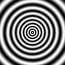
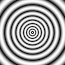
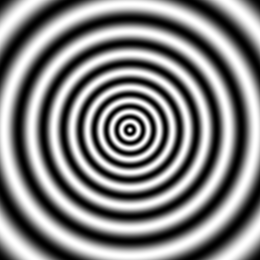

In [192]:
def chirp(shape=(65, 65), frame_center=(0.5, 0.5),
          period_at_center=2.0, period_at_border=4.0, reference_shape=None) -> _NDArray:
  reference_shape = reference_shape or shape
  yx = (np.moveaxis(np.indices(shape), 0, -1) + (0.5, 0.5)) / max(shape)
  radius = np.linalg.norm(yx - frame_center, axis=-1)
  t = radius / 0.5  # 0.0 at center, 1.0 at nearest original border
  period = (1.0 - t) * period_at_center + t * period_at_border
  value = np.cos(radius / period * math.tau * max(reference_shape)) * 0.5 + 0.5
  return value  # linear space

def visualize_chirps() -> None:
  images = {
      'chirp defined in lightness space': chirp(),
      'linear chirp to lightness': PowerGamma(2).encode(chirp(), np.dtype('f')),
      'higher resolution': chirp(shape=(260, 260), reference_shape=(65, 65)),
      '25x50 off-center': chirp(shape=(25, 50), frame_center=(0.37, 0.25)),
  }
  media.show_images(images, height=260)

visualize_chirps()


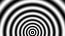
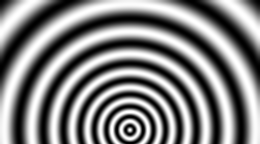
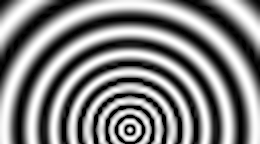


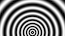
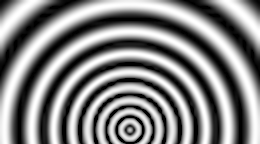


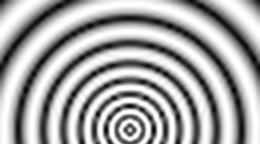
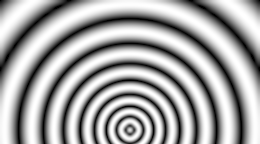

In [193]:
def experiment_visualize_gamma_upsample_image(**kwargs) -> None:

  def try_gamma_upsample(func, shape, frame_center, supersample=1, source_pow=1) -> None:
    supersample_shape = np.array(shape) * supersample
    supersampled = func(supersample_shape, frame_center, reference_shape=shape)**source_pow
    # or: supersampled = PowerGamma(2).encode(supersampled, supersampled.dtype)
    image = resize(supersampled, shape, filter='lanczos10', src_gamma='power2', dst_gamma='power2')
    new_shape = np.array(shape) * 4  # Or, "* 8".

    def resize_gamma(gamma: str) -> _NDArray:
      return resize(image, new_shape, filter='lanczos10', gamma=gamma)

    identity = resize_gamma('identity')
    power2 = resize_gamma('power2')
    images = {'original': image, 'identity': identity, 'power2': power2}
    images = {name: image[:image.shape[0] * 5 // 9] for name, image in images.items()}
    media.show_images(images, vmin=0, vmax=1, border=True, width=new_shape[1],
                      ylabel=f'supersample={supersample} source_pow={source_pow}')

  try_gamma_upsample(**kwargs)
  try_gamma_upsample(**kwargs, source_pow=0.5)
  try_gamma_upsample(**kwargs, supersample=32)
  try_gamma_upsample(**kwargs, supersample=32, source_pow=0.5)

media.set_max_output_height(3000)
experiment_visualize_gamma_upsample_image(func=chirp, shape=(65, 65), frame_center=(0.5, 0.5))

In [194]:
def experiment_visualize_gamma_upsample_video(shape=(24, 48), source_pow=1) -> None:
  new_shape = np.array(shape) * 8
  yx = (np.moveaxis(np.indices(shape), 0, -1) + (0.5, 0.5)) / min(shape)
  original, identity, power2 = [], [], []
  for angle in np.linspace(0.0, math.tau, 60, endpoint=False):
    center = (0.75, 0.5) + np.array([np.cos(angle), np.sin(angle)]) * 0.05
    radius = np.linalg.norm(yx - center, axis=-1)
    image = (np.cos((radius + 0.1) ** 0.5 * 70.0) * 0.5 + 0.5)**source_pow

    def resize_gamma(gamma: str) -> _NDArray:
      return resize(image, new_shape, filter='lanczos3', gamma=gamma)

    original.append(image)
    identity.append(resize_gamma('identity'))
    power2.append(resize_gamma('power2'))

  videos = {'original': original, 'identity': identity, 'power2': power2}
  media.show_videos(videos, border=True, fps=10, height=shape[0]*8,
                    ylabel=f'source_pow={source_pow}', codec='gif')

if EFFORT >= 2:
  experiment_visualize_gamma_upsample_video()
  experiment_visualize_gamma_upsample_video(source_pow=0.5)

Conclusions:

Nehab and Hoppe [2014] suggest that for upsampling,
the best approach may be to upsample directly in the lightness space of the source image.
These experiments indicate otherwise.

The problem is that the example source image (sampled from chirp) is
bandlimited in lightness space (where it is stored),
but is not bandlimited when converted to linear space (where it is operated on)
due to the nonlinear squaring operation.
This aliased reconstruction can be prevented in one of two ways:
1. Define a different analytic function that is in fact bandlimited in linear
  space.  A trivial way is to use chirp in linear space.
2. Prefilter the linear-space function such that it is bandlimited.  A simple
  approach is to supersample it.  As seen in the image results, the
  coarse image looks similar, and its upsampling no longer exhibits
  aliasing artifacts.

## Higher diagonal frequencies

On a regular Cartesian 2D grid, the representable frequencies are given
by a square region in the frequency domain.
Therefore, the 45$^\circ$ diagonal is able to represent higher frequencies
(by a factor of $\sqrt{2}$) than the two axial directions.
As an experiment, we supersample axis-aligned rasterized text on grids
that are rotated by various angles (from $0^\circ$ to $90^\circ$)
and measure the reconstruction accuracy.


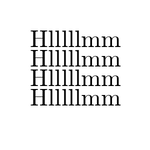
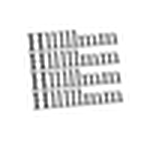
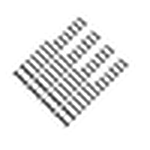
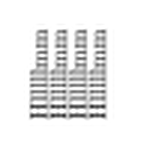

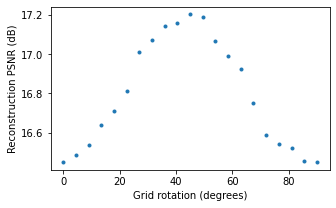

In [195]:
def _get_pil_font(font_size: int, font_name: str = 'cmr10') -> Any:

  def find(dir_pattern: str) -> Optional[str]:
    file_pattern = pathlib.Path(dir_pattern).expanduser() / f'{font_name}.ttf'
    return next(glob.iglob(str(file_pattern), recursive=True), None)

  FONT_DIR_PATTERNS = [
      '/usr/local/lib/python*/dist-packages/matplotlib/mpl-data/fonts/ttf/',
      '~/.local/lib/python*/site-packages/matplotlib/mpl-data/fonts/ttf/',
      '/opt/conda/lib/python*/site-packages/matplotlib/mpl-data/fonts/ttf/',
      '/usr/local/lib/**/',
  ]
  font_file = next(filter(None, (find(dir_pattern) for dir_pattern in FONT_DIR_PATTERNS)))
  import PIL.ImageFont
  return PIL.ImageFont.truetype(font_file, font_size)


def rasterize_text(shape: Tuple[int, int], text: str, *,
                   pad_xy: Tuple[int, int] = (10, 10),
                   background: int = 255, foreground: int = 0,
                   font_size: int = 48) -> _NDArray:
  import PIL.Image
  import PIL.ImageDraw
  pil_font = _get_pil_font(font_size)
  pil_image = PIL.Image.fromarray(np.full(shape, background, dtype=np.uint8))
  draw = PIL.ImageDraw.Draw(pil_image)
  draw.text(pad_xy, text, fill=foreground, spacing=5, font=pil_font)
  return np.array(pil_image)

def get_text_image(shape=(200,) * 2) -> _NDArray:
  return rasterize_text(shape, 'Hlllllmm\n' * 4)

def experiment_rotated_grid_has_higher_fidelity_for_text(num_rotations=21) -> None:
  original = crop_array(get_text_image() / 255.0, -50, 1.0)

  def generate_image_pair(degree) -> Tuple[_NDArray, _NDArray]:
    reference = rotate_image_about_center(original, np.deg2rad(degree), boundary='clamp')
    reference = resize(reference, np.array(original.shape[:2]) // 2)
    downsampled = resize(reference, np.array(reference.shape[:2]) // 3)
    reconstructed = resize(downsampled, reference.shape[:2])
    return reference, reconstructed

  images = {'original': original}
  for degree in [0, 5, 45, 90]:
    reference, reconstructed = generate_image_pair(degree)
    psnr = get_psnr(reconstructed, reference)
    images[f'degree={degree}  psnr={psnr:.2f}'] = reconstructed
  media.show_images(images, vmin=0, vmax=1, border=True, height=reconstructed.shape[0])

  degrees = np.linspace(0.0, 90.0, num_rotations)
  psnrs = [get_psnr(*generate_image_pair(degree)) for degree in degrees]
  _, ax = plt.subplots(figsize=(5, 3))
  ax.plot(degrees, psnrs, '.')
  ax.set_xlabel('Grid rotation (degrees)')
  ax.set_ylabel('Reconstruction PSNR (dB)')

experiment_rotated_grid_has_higher_fidelity_for_text()

The conclusion is that, indeed, a regular grid is able to
reconstruct higher frequencies along the 45-degree diagonal direction.
For axis-aligned text, there is a small blip at the zero-degree direction,
likely due to avoiding the initial rotational resampling.

## Prefiltering of a discontinuity

Let us examine the effect of different prefiltering filters on the downsampling
of a step function.

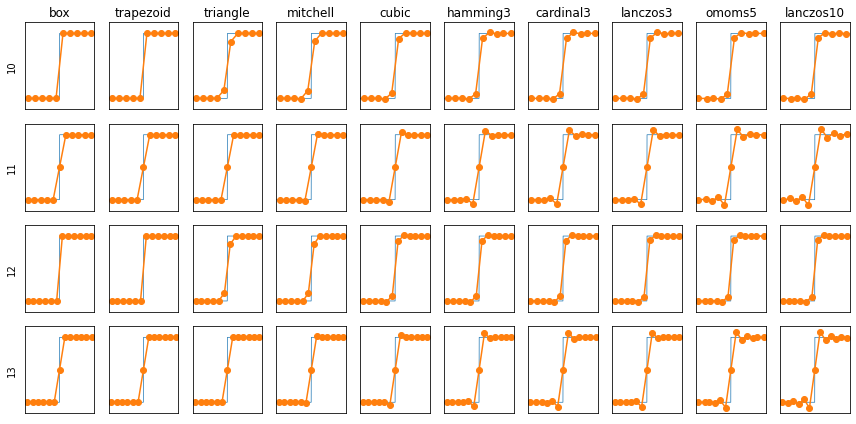

In [196]:
def visualize_prefiltering_a_discontinuity_in_1D(size=400, x_step=0.5) -> None:
  x = (np.arange(size) + 0.5) / size
  array = np.where(x < x_step, 0.0, 1.0)
  new_sizes = [10, 11, 12, 13]  # range(10, 21)
  filters = ('box trapezoid triangle mitchell cubic '
             'hamming3 cardinal3 lanczos3 omoms5 lanczos10').split()
  fig, axs = plt.subplots(len(new_sizes), len(filters), figsize=(12, 6))
  for row_index, new_size in enumerate(new_sizes):
    for col_index, filter in enumerate(filters):
      def downsample(a: _NDArray) -> _NDArray:
        return resize(a, (new_size,), filter=filter)
      ax = axs[row_index][col_index]
      ax.plot(x, array, '-', linewidth=0.7)
      ax.plot(downsample(x), downsample(array), 'o-')
      _ = ax.set_xlim(0.0, 1.0), ax.set_ylim(-0.17, 1.17)
      _ = ax.xaxis.set_ticks([]), ax.yaxis.set_ticks([])
      ax.set_ylabel(f'{new_size}' if col_index == 0 else None)
      ax.set_title(filter if row_index == 0 else None)
  fig.tight_layout()

visualize_prefiltering_a_discontinuity_in_1D()

Conclusions:
- Ringing is most evident with `'lanczos10'`.
- There is slight ringing with `'lanczos3'` although it is localized.
- The `'hamming3'` filter behaves much like `'lanczos3'`.

We now consider the same situation in 2D using a sharply defined circle:


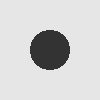

In [197]:
def visualize_prefiltering_a_discontinuity_in_2D(
    shape=(100, 100), radius=0.2, new_shape=(20, 20)) -> None:
  mapped_radius = np.linalg.norm((np.indices(shape).T + 0.5) / np.array(shape) - 0.5, axis=-1).T
  outside_circle = mapped_radius >= radius
  array = np.where(outside_circle, 0.9, 0.2)
  filters = ('box trapezoid triangle mitchell cubic '
             'hamming3 cardinal3 lanczos3 omoms5 lanczos10').split()
  images = {'original': array}
  for filter in filters:
    images[filter] = resize(array, new_shape, filter=filter)
  media.show_images(images, border=True, height=shape[0], vmin=0, vmax=1)

visualize_prefiltering_a_discontinuity_in_2D()

Conclusions:
- Again, ringing artifacts are most evident with `'lanczos10'`.
- The ringing is much reduced in `'lanczos3'`, which is again nearly identical to `'hamming3'`.
- Ringing is avoided altogether in `'mitchell'` (and of course `'box'` and `'trapezoid'`).

We saw in 1D that ringing artifacts are scale-dependent.
Here we generate videos to show the effect of continuously changing the scale:

In [198]:
def visualize_prefiltering_as_scale_is_varied(
    shape=(100, 100), radius=0.2, new_shape=(20, 20)) -> None:
  mapped_radius = np.linalg.norm((np.indices(shape).T + 0.5) / np.array(shape) - 0.5, axis=-1).T
  outside_circle = mapped_radius >= radius
  array = np.where(outside_circle, 0.9, 0.2)
  filters = 'box trapezoid mitchell cubic cardinal3 lanczos3 omoms5 lanczos10'.split()
  videos = collections.defaultdict(list)
  for filter in filters:
    for scale in np.linspace(0.9, 1.1, 61):
      videos[filter].append(resize(array, new_shape, scale=scale, filter=filter)[3:-3, 3:-3])
  media.show_videos(videos, border=True, height=shape[0]*1.5, qp=14, fps=20)

visualize_prefiltering_as_scale_is_varied()

Conclusions:
- There is definite *temporal shimmering* for `'lanczos10'`,
  particularly in the circle interior.
- Although the `'cubic'` and `'lanczos3'` results show halos, there is little shimmering.

## Prefilter convolution

In [199]:
# Export: outside library.
def _torch_symmetric_pad(array: Any, padding: Iterable[int]) -> _TorchTensor:
  """Use reflection to pad each dimension."""
  # See https://github.com/pytorch/pytorch/issues/46240 and
  # https://discuss.pytorch.org/t/symmetric-padding/19866/3.
  import torch
  array = torch.as_tensor(array)
  padding = tuple(padding)
  if len(padding) != array.ndim:
    raise ValueError(f'Padding {padding} does not match ndim of {array.shape}.')
  if any(pad < 0 for pad in padding):
    raise ValueError(f'Padding {padding} has negative values.')

  dim_indices: List[_NDArray] = []
  for dim in range(array.ndim):
    pad = padding[dim]
    if pad == 0 and not dim_indices:
      # The prefix of unmodified dimensions is accounted for by an Ellipsis.
      continue
    width = array.shape[dim]
    index = np.arange(-pad, width + pad)
    if pad > 0:
      index = np.mod(index, width * 2)
      index = np.where(index < width, index, 2 * width - 1 - index)
    dim_indices.append(index)

  grid_indices = np.meshgrid(*dim_indices, indexing='ij')
  return array[(..., *grid_indices)]

In [200]:
def experiment_with_convolution() -> None:  # pylint: disable=too-many-statements
  # https://laurentperrinet.github.io/sciblog/posts/2017-09-20-the-fastest-2d-convolution-in-the-world.html

  def scipy_convolve(array, filter, reflect=False) -> _NDArray:
    assert array.ndim >= filter.ndim
    while filter.ndim < array.ndim:
      filter = filter[..., None]
    if reflect:
      pad = tuple(np.array(filter.shape) // 2)
      array = np.pad(array, tuple(zip(pad, pad)), 'symmetric')
    mode = 'valid' if reflect else 'same'
    return scipy.signal.convolve(array, filter, mode=mode)

  def scipy_oaconvolve(array, filter, reflect=False) -> _NDArray:
    # Faster than fftconvolve when one array is much larger than the other.
    # https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method
    assert array.ndim >= filter.ndim
    while filter.ndim < array.ndim:
      filter = filter[..., None]
    if reflect:
      pad = tuple(np.array(filter.shape) // 2)
      array = np.pad(array, tuple(zip(pad, pad)), 'symmetric')
    mode = 'valid' if reflect else 'same'
    return scipy.signal.oaconvolve(array, filter, mode=mode, axes=range(filter.ndim))

  def scipy_sepfir2d(array, filter1d) -> _NDArray:
    if array.ndim > 2:
      return np.stack([scipy_sepfir2d(array[..., i], filter1d)
                       for i in range(array.shape[-1])], axis=-1)
    return scipy.signal.sepfir2d(array, filter1d, filter1d)

  def numpy_fftconvolve(array, filter) -> _NDArray:
    assert array.ndim >= filter.ndim
    while filter.ndim < array.ndim:
      filter = filter[..., None]
    result = np.fft.irfftn(np.fft.rfftn(array) * np.fft.rfftn(filter, s=array.shape),
                           s=array.shape)  # (Always np.float64.)
    result = np.roll(result, -(np.array(filter.shape) // 2), axis=range(array.ndim))
    return result

  def ndimage_convolve(array, filter) -> _NDArray:
    assert array.ndim >= filter.ndim
    while filter.ndim < array.ndim:
      filter = filter[..., None]
    return scipy.ndimage.convolve(array, filter, mode='reflect')

  def tensorflow_convolve(array, filter, reflect=False) -> _NDArray:
    """Convolve the array [*dims, *sample_shape] with the filter [*dims]."""
    import tensorflow as tf
    array = tf.convert_to_tensor(array)
    filter = tf.convert_to_tensor(filter)
    conv_ndim = filter.ndim
    assert conv_ndim in (1, 2, 3)
    assert array.ndim >= conv_ndim
    if reflect:
      pad = (*(np.array(filter.shape) // 2), *(0,) * (array.ndim - conv_ndim))
      array = tf.pad(array, tuple(zip(pad, pad)), mode='SYMMETRIC')
    filter = filter[..., None, None]  # WCO, HWCO, or THWCO.
    padding = 'VALID' if reflect else 'SAME'

    def recurse(array) -> tf.Tensor:
      if array.ndim > conv_ndim:
        return tf.stack([recurse(array[..., i]) for i in range(array.shape[-1])], axis=-1)
      array = array[None, ..., None]  # BWC, BHWC, or BTHWC.
      return tf.nn.conv2d(array, filter, strides=1, padding=padding)[0, ..., 0]

    # Note: separable_conv2d() might be simpler but is much slower on CPU.
    return recurse(array).numpy()

  def torch_convolve(array, filter, reflect=False) -> _NDArray:
    """Convolve the array [*dims, *sample_shape] with the filter [*dims]."""
    import torch
    array = torch.as_tensor(array)
    filter = torch.as_tensor(filter)
    conv_ndim = filter.ndim
    assert conv_ndim in (1, 2, 3)
    assert array.ndim >= conv_ndim
    sample_shape = array.shape[conv_ndim:]
    padding: Any = tuple(np.array(filter.shape) // 2)
    array = array.view(1, *array.shape[:conv_ndim], -1)  # BWC, BHWC, or BTHWC.
    array = array.moveaxis(-1, 1)  # BCW, BCHW , or BCTHW.
    while filter.ndim < array.ndim:
      filter = filter[None]
    filter = filter.expand((array.shape[1], 1, *filter.shape[2:]))  # OCW, OCHW, or OCTHW.
    if reflect:
      array = _torch_symmetric_pad(array, (0, 0, *padding))
      padding = 0
    conv = {
        1: torch.nn.functional.conv1d,
        2: torch.nn.functional.conv2d,
        3: torch.nn.functional.conv3d,
    }[conv_ndim]
    result = conv(array, filter, padding=padding, groups=array.shape[1])
    result = result[0]  # CW, CHW, or CTHW.
    result = result.moveaxis(0, -1)  # WC, HWC, or THWC.
    result = result.view(*result.shape[:conv_ndim], *sample_shape)
    return result.numpy()

  # shape = 17, 17
  shape = 17, 17, 3
  array = np.zeros(shape, dtype=np.float32)
  array[tuple(np.array(shape[:2]) // 2)] = 1.0
  array[2, 0] = 1.0
  filter1d = resize(
      [0.0, 0.0, 1.0, 0.0, 0.0], (11,), gridtype='primal', filter='cubic', dtype=np.float32)
  filter1d /= filter1d.sum()
  filter = np.outer(filter1d, filter1d)
  functions: Dict[str, Callable[[], _NDArray]] = {
      'scipy_convolve':  # zero-padding
          lambda: scipy_convolve(array, filter),
      'scipy_convolve_r':
          lambda: scipy_convolve(array, filter, reflect=True),
      'scipy.oaconvolve':  # zero-padding
          lambda: scipy_oaconvolve(array, filter),
      'scipy_oaconvolve_r':
          lambda: scipy_oaconvolve(array, filter, reflect=True),
      'scipy.sepfir2d':  # reflect
          lambda: scipy_sepfir2d(array, filter1d),
      'numpy_fftconvolve':  # periodic
          lambda: numpy_fftconvolve(array, filter),
      'ndimage.convolve':  # selectable
          lambda: ndimage_convolve(array, filter),
      'tf_convolve':  # zero-padding
          lambda: tensorflow_convolve(array, filter),
      'tf_convolve_r':
          lambda: tensorflow_convolve(array, filter, reflect=True),
      # 'torch_convolve':  # zero-padding
      #     lambda: torch_convolve(array, filter),
      'torch_convolve_r':
          lambda: torch_convolve(array, filter, reflect=True),
  }
  if 1:
    visualization = {}
    for name, function in functions.items():
      result = function()
      if name != 'numpy_fftconvolve':  # It always computes np.float64.
        check_eq(result.dtype, array.dtype)
      sum_ = result.sum() / array.sum()
      # print(f'{name:22} {result.shape!s:14} {sum_:.4f}')
      assert 0.85 <= sum_ <= 1.001, name
      visualization[f'{name}<br/>sum={sum_:5.3f}'] = 1 - (array + result)
    media.show_images(visualization, height=120, border=True, columns=6)

  if 1:
    shape = 500, 500, 3
    print(f'For shape = {shape}:')
    array = np.zeros(shape, dtype=np.float32)
    for name, function in functions.items():
      elapsed = hh.get_time(function, max_time=0.2)
      print(f'{name:25}: {elapsed:.3f} s')

  if EFFORT >= 2:  # For 10x downsampling, convolution on source grid is 10x slower.
    array = np.ones((1000, 2000, 3), dtype=np.float32)
    filter = np.ones((61, 61), dtype=np.float32)
    # (resize to (100, 200) lanczos3 39 ms)
    # (resample to (100, 200) lanczos3 30 ms but aliased)
    hh.print_time(lambda: scipy_convolve(array, filter, reflect=False))  # 309 ms
    hh.print_time(lambda: scipy_convolve(array, filter, reflect=True))  # 325 ms

  if EFFORT >= 2:  # Convolution on source grid is 8-12x slower than resize().
    array = np.ones((2000, 2000, 3), dtype=np.float32)
    for downscale in [1, 2, 3, 4, 8]:
      filter = np.ones((2 * 3 * downscale + 1,) * 2, dtype=np.float32)
      print(array.shape, filter.shape)
      # hh.print_time(lambda: scipy_convolve(array, filter, reflect=False))
      hh.print_time(lambda: scipy_convolve(array, filter, reflect=True))
      hh.print_time(lambda: resize(array, np.array(array.shape[:2]) // downscale))

if EFFORT >= 1:
  experiment_with_convolution()

For shape = (500, 500, 3):
scipy_convolve           : 0.006 s
scipy_convolve_r         : 0.007 s
scipy.oaconvolve         : 0.008 s
scipy_oaconvolve_r       : 0.008 s
scipy.sepfir2d           : 0.006 s
numpy_fftconvolve        : 0.022 s
ndimage.convolve         : 0.037 s
tf_convolve              : 0.013 s
tf_convolve_r            : 0.012 s
torch_convolve_r         : 0.002 s


Conclusions:
- `scipy.ndimage.convolve`: nice flexible boundary conditions, but slower.
- `sepfir2d`: fast and supports `'reflect'` boundaries,
  but only operates in 2D and using the same filter for both axes.
- `tf.nn.separable_conv2d` is horribly slow on the CPU.
- `torch.nn.functional.conv2d` with padding is slow; instead we implement it ourselves.
- `scipy.convolve` and `torch.conv2d` are both fast!
- However, all these convolutions are ~10x slower than the "strided convolution" in the
  `resize()` operation.
  It does seem wasteful to be computing the convolution on all source pixels
  when the smaller output will just subsample the result.

## Generalized sampling

In [201]:
# pylint: disable-next=too-many-branches disable-next=too-many-statements
def test_banded(debug=False) -> None:
  # [On band circulant matrices in the periodic spline interpolation theory]:
  # https://www.sciencedirect.com/science/article/pii/0024379585901533
  np.random.seed(1)
  array = np.array([3.0, 4.0, 1.0, 2.0, 7.0, 6.0])
  # array = np.random.randint(1, 10, 100).astype(np.float64)
  size = len(array)
  if 0:
    array = np.broadcast_to(array[..., None], array.shape + (2,))
  filter = BsplineFilter(degree=5)  # 3 or 5
  boundary = 'reflect'
  boundary = 'wrap'
  # We use the notation (l, ab) from scipy.linalg.solve_banded().  l == u.
  l = math.ceil(filter.radius) - 1
  x = np.arange(-l, l + 1)
  values = filter(x)
  if debug:
    print(x, values)  # degree3: [1, 4, 1]/6; degree5: [1, 26, 66, 26, 1]/120
  UNDEFINED = math.nan

  if 1 and l == 1 and boundary == 'reflect':
    ab = np.empty((2 * l + 1, size))
    ab[:] = values[:, None]
    ab[1, 0] = ab[1, 0] + ab[0, 0]
    ab[0, 0] = UNDEFINED
    ab[1, -1] = ab[1, -1] + ab[-1, -1]
    ab[-1, -1] = UNDEFINED
    new = scipy.linalg.solve_banded((l, l), ab, array, check_finite=False)
    print('solve_banded', new)
    offsets = range(l, -l - 1, -1)
    matrix = scipy.sparse.dia_matrix((ab, offsets), shape=(size, size))
    if debug:
      print(matrix.toarray(), matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1:
    src_index = np.arange(size)[:, None] + np.arange(len(values)) - l
    weight = np.broadcast_to(values[None], (size, len(values)))
    src_position = np.broadcast_to(0.5, len(values))
    src_gridtype = GRIDTYPES['dual']
    src_index, weight = BOUNDARIES[boundary].apply(
        src_index, weight, src_position, size, src_gridtype)
    data = weight.reshape(-1)
    row_ind = np.arange(size).repeat(src_index.shape[1])
    col_ind = src_index.reshape(-1)
    matrix = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=(size, size))
    assert scipy.sparse.linalg.norm(matrix - matrix.T, np.inf) < 1e-10
    if boundary == 'wrap':
      # Transpose of (symmetric) csr_matrix because splu() desires csc_matrix.
      lu = scipy.sparse.linalg.splu(matrix.transpose(), permc_spec='NATURAL')
      check_eq(lu.perm_c, range(size))
      check_eq(lu.perm_r, range(size))
      assert lu.L.nnz == lu.U.nnz <= size * len(values)  # Sparse.
      new = lu.solve(array)
    else:
      matrix = matrix.todia()
      check_eq(matrix.offsets, range(-l, l + 1))
      new = scipy.linalg.solveh_banded(matrix.data[-1:l-1:-1], array, check_finite=False)
    if debug:
      print('boundary', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1 and l == 1 and boundary == 'reflect':
    ab = np.empty((l + 1, size))
    ab[:] = values[:l+1, None]
    ab[1, 0] = ab[1, 0] + ab[0, 0]
    ab[0, 0] = UNDEFINED
    ab[1, -1] = ab[1, -1] + ab[0, -1]
    new = scipy.linalg.solveh_banded(ab, array, check_finite=False)
    if debug:
      print('solveh_banded', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1 and l == 1 and boundary == 'reflect':
    lu = scipy.sparse.linalg.splu(matrix.tocsc(), permc_spec='NATURAL')
    assert lu.L.nnz <= size * 2 and lu.U.nnz <= size * 2  # Nicely sparse.
    check_eq(lu.perm_c, range(size))
    check_eq(lu.perm_r, range(size))
    # print(lu.shape, lu.L.nnz, lu.U.nnz)
    # print(lu.perm_c, lu.perm_r, lu.L, lu.U)
    new = lu.solve(array)
    if debug:
      print('lu', new)

  if 1 and l in [1, 2]:
    # causal/anticausal filters:
    # https://github.com/scipy/scipy/blob/master/scipy/ndimage/src/ni_interpolation.c#L145
    # https://github.com/scipy/scipy/blob/master/scipy/ndimage/src/ni_splines.c
    # Drawbacks: not as precise; only Bspline (no OMOMS); limited boundaries.
    new = _spline_filter1d(array, order=l * 2 + 1, axis=0, mode=boundary, output=array.dtype)
    if debug:
      print('ndimage', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1 and l == 1 and boundary == 'reflect':
    # It applies lfilter() twice (once on reversed array).
    # It always produces np.float64, except with method='gust'.
    # https://www.dsprelated.com/showthread/comp.dsp/368362-2.php
    # a = [1 2-sqrt(3)]; b = sum(a);
    # c = filtfilt(f,b,a);
    a = np.array([1.0, 2.0 - math.sqrt(3)])
    b = a.sum()
    new = scipy.signal.filtfilt(b, a, array, axis=0, method='gust')
    if debug:
      print('filtfilt', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 1 and l == 1 and boundary == 'reflect':
    import tensorflow as tf
    # tensorflow does not support general banded solver.
    # tf.linalg.banded_triangular_solve(): only upper or only lower diagonals.
    # tf.linalg.tridiagonal_solve(): 1 lower diagonal and 1 upper diagonal.
    # Possibly the matrix can be factored into a sequence of the above.
    # tf.linalg.LinearOperatorCirculant().inverse() uses FFT (dense).
    # For TF2: https://stackoverflow.com/a/63583413
    # For splu using TF1: https://stackoverflow.com/a/46913675
    # For tf.keras: https://stackoverflow.com/a/62921079
    # Limitation of tf.py_function: the resulting model cannot be serialized!

    ab = np.empty((2 * l + 1, size))
    ab[:] = values[:, None]
    ab[1, 0] = ab[1, 0] + values[0]
    ab[0, -1] = UNDEFINED
    ab[1, -1] = ab[1, -1] + values[2]
    ab[-1, 0] = UNDEFINED
    ab = tf.convert_to_tensor(ab)
    array = tf.convert_to_tensor(array)
    new = tf.linalg.tridiagonal_solve(ab, array, partial_pivoting=False)
    if debug:
      print('tf.tridiagonal', new, matrix.dot(new))
    assert np.allclose(matrix.dot(new), array)

  if 0:
    # import torch
    # torch.linalg lacks solvers for banded, circulant, or sparse matrices.
    pass

  # wrap boundary:
  # scipy lacks efficient solvers for "circulant banded linear systems".
  # scipy.solve_banded() does not support the circulant corners.
  # scipy.solve_circulant() assumes a dense matrix and uses FFT.
  # solution: scipy.sparse LU factorization does remain sparse.


if 1:
  test_banded()

In [202]:
def test_inverse_convolution_2d(  # pylint: disable=too-many-statements
    scale=2.0, degree=3, gridtype='dual', boundary='reflect', dtype=np.float32) -> None:
  filter = BsplineFilter(degree=degree)
  l = math.ceil(filter.radius) - 1
  x = np.arange(-l, l + 1)
  values = filter(x)
  UNDEFINED = 1e20
  mode = {
      'dual': {'reflect': 'reflect', 'wrap': 'wrap', 'clamp': 'nearest'},
      'primal': {'reflect': 'mirror', 'wrap': 'n/a', 'clamp': 'nearest'},
  }[gridtype][boundary]

  def run_spline_filter1d(array: _NDArray) -> _NDArray:
    array = array.copy()
    for dim in range(2):
      _spline_filter1d(array, order=degree, axis=dim, mode=mode, output=array)
    return array

  def run_general(array: _NDArray) -> _NDArray:
    for dim in range(2):
      array_dim = np.moveaxis(array, dim, 0)
      size = array_dim.shape[0]
      src_index = np.arange(size)[:, None] + np.arange(len(values)) - l
      weight = np.full((size, len(values)), values, dtype=array.dtype)
      src_position = np.broadcast_to(0.5, len(values))
      src_gridtype = GRIDTYPES[gridtype]
      src_index, weight = BOUNDARIES[boundary].apply(
          src_index, weight, src_position, size, src_gridtype)
      if gridtype == 'primal' and boundary == 'wrap':
        # Overwrite redundant last row to preserve unreferenced last sample.
        src_index[-1] = [size - 1] + [0] * (src_index.shape[1] - 1)
        weight[-1] = [1.0] + [0.0] * (weight.shape[1] - 1)
      data = weight.reshape(-1)
      row_ind = np.arange(size).repeat(src_index.shape[1])
      col_ind = src_index.reshape(-1)
      matrix = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape=(size, size))
      if boundary == 'wrap':
        lu = scipy.sparse.linalg.splu(matrix.tocsc(), permc_spec='NATURAL')
        assert lu.L.nnz == lu.U.nnz <= size * len(values)  # Sparse.
        array_flat = array_dim.reshape(array_dim.shape[0], -1)
        array_flat = lu.solve(array_flat)
        array_dim = array_flat.reshape(array_dim.shape)
      else:
        matrix = matrix.todia()
        check_eq(matrix.offsets, range(-l, l + 1))
        options = dict(check_finite=False, overwrite_ab=True, overwrite_b=True)
        if _is_symmetric(matrix):
          array_dim = scipy.linalg.solveh_banded(matrix.data[-1:l-1:-1], array_dim, **options)
        else:
          array_dim = scipy.linalg.solve_banded((l, l), matrix.data[::-1], array_dim, **options)
      array = np.moveaxis(array_dim, 0, dim)
    return array

  def run_solveh_banded(array: _NDArray) -> _NDArray:
    for dim in range(2):
      array_dim = np.moveaxis(array, dim, 0)
      size = array_dim.shape[0]
      ab = np.empty((l + 1, size), dtype=array.dtype)
      ab[:] = values[:l+1, None]
      ab[1, 0] = ab[1, 0] + ab[0, 0]
      ab[0, 0] = UNDEFINED
      ab[1, -1] = ab[1, -1] + ab[0, -1]
      array_dim = scipy.linalg.solveh_banded(
          ab, array_dim, check_finite=False, overwrite_ab=True, overwrite_b=True)
      array = np.moveaxis(array_dim, 0, dim)
    return array

  def run_splu(array: _NDArray) -> _NDArray:
    for dim in range(2):
      array_dim = np.moveaxis(array, dim, 0)
      size = array_dim.shape[0]
      ab = np.empty((2 * l + 1, size), dtype=array.dtype)
      ab[:] = values[:, None]
      ab[1, 0] = ab[1, 0] + ab[0, 0]
      ab[0, 0] = UNDEFINED
      ab[1, -1] = ab[1, -1] + ab[-1, -1]
      ab[-1, -1] = UNDEFINED
      offsets = range(l, -l - 1, -1)
      matrix = scipy.sparse.dia_matrix((ab, offsets), shape=(size, size))
      lu = scipy.sparse.linalg.splu(matrix.tocsc(), permc_spec='NATURAL')
      array_flat = array_dim.reshape(array_dim.shape[0], -1)
      array_flat = lu.solve(array_flat)
      array_dim = array_flat.reshape(array_dim.shape)
      array = np.moveaxis(array_dim, 0, dim)
    return array

  def run_filtfilt(array: _NDArray) -> _NDArray:
    for dim in range(2):
      a = np.array([1.0, 2.0 - math.sqrt(3)], dtype=array.dtype)
      b = a.sum()
      with np.errstate(under='ignore'):
        array = scipy.signal.filtfilt(b, a, array, axis=dim, method='gust')
    return array

  # (480, 640, 3)
  array = media.to_float01(EXAMPLE_PHOTO).astype(dtype, copy=False)
  if np.issubdtype(dtype, np.complexfloating):
    array = array + 0.5j * (array + 0.2)
  functions = {
      'general': run_general,
      'spline_filter1d': run_spline_filter1d,
  }
  if gridtype == 'dual' and boundary == 'reflect' and degree == 3:
    new_shape = (np.array(array.shape[:2]) * scale + 0.5).astype(int)
    hh.print_time(lambda: resize(array, new_shape, filter='cubic'))  # 20 ms
    hh.print_time(lambda: resize(array, new_shape, filter='lanczos5'))  # 35 ms
    functions = {
        **functions,
        'solveh_banded': run_solveh_banded,
        'splu': run_splu,
        'filtfilt': run_filtfilt,
    }
  with warnings.catch_warnings():
    warnings.filterwarnings(action='error', category=np.ComplexWarning)
    for name, function in functions.items():
      if (np.issubdtype(dtype, np.complexfloating) and
          name in ['spline_filter1d', 'filtfilt']):
        continue
      elapsed, new = hh.get_time_and_result(lambda: function(array), max_repeat=5)
      check_eq(new.dtype, dtype)
      if 1 or not np.issubdtype(dtype, np.complexfloating):
        filter2d = np.outer(values, values)[..., None]
        convolved = np.empty_like(new)
        convolved.real = scipy.ndimage.convolve(new.real, filter2d, mode=mode)
        if np.issubdtype(dtype, np.complexfloating):
          convolved.imag = scipy.ndimage.convolve(new.imag, filter2d, mode=mode)
        max_error = abs(convolved - array).max()
        print(f'{name:16}: {elapsed:5.3f} s  (max_error:{max_error:9.2e})')
        assert max_error <= 1e-6

if 1:
  test_inverse_convolution_2d()
if EFFORT >= 2:
  test_inverse_convolution_2d(dtype=np.complex128)
  test_inverse_convolution_2d(degree=5)
  test_inverse_convolution_2d(degree=5, gridtype='primal')
  test_inverse_convolution_2d(gridtype='dual', boundary='wrap')
  # test_inverse_convolution_2d(gridtype='primal', boundary='wrap')  # scipy.ndimage.convolve does not match this.
  # test_inverse_convolution_2d(boundary='clamp')  # bug in spline_filter1d
# 0.027 s
# 0.040 s
# general         : 0.026 s  (max_error: 2.98e-07)
# spline_filter1d : 0.026 s  (max_error: 1.19e-07)
# solveh_banded   : 0.023 s  (max_error: 2.98e-07)
# splu            : 0.065 s  (max_error: 2.38e-07)
# filtfilt        : 0.215 s  (max_error: 5.96e-07)
# 0.059 s
# 0.105 s
# general         : 0.045 s  (max_error: 3.04e-07)
# solveh_banded   : 0.040 s  (max_error: 3.04e-07)
# splu            : 0.131 s  (max_error: 2.67e-07)
# general         : 0.064 s  (max_error: 2.38e-07)
# spline_filter1d : 0.042 s  (max_error: 1.19e-07)
# general         : 0.053 s  (max_error: 2.98e-07)
# spline_filter1d : 0.042 s  (max_error: 1.19e-07)
# general         : 0.072 s  (max_error: 2.98e-07)
# spline_filter1d : 0.037 s  (max_error: 1.19e-07)

8.29 ms
12.4 ms
general         : 0.012 s  (max_error: 2.98e-07)
spline_filter1d : 0.009 s  (max_error: 1.19e-07)
solveh_banded   : 0.009 s  (max_error: 2.98e-07)
splu            : 0.022 s  (max_error: 2.38e-07)
filtfilt        : 0.075 s  (max_error: 5.96e-07)


Conclusions:
- Unfortunately, all these digital-filter implementations take
  about the same time as the direct `resize()` operation.
- E.g., for 2x upsampling, just running the `degree=3` digital filter takes
  as much time as resizing with a `radius=3` filter.
- The digital filter becomes worthwhile if the upscaling
  (or downscaling) factor is 4.0 or greater.
- `scipy.linalg.solveh_banded` gives the fastest time,
  but it does not support `boundary='wrap'`.
- I tried running on just `dim = 0` (to simulate applying the digital
  filter to `array_flat`) and the speedup is very small.

## Other

The 2D continuous `'gaussian'` kernel is the only separable filter
that is rotationally symmetric.
However, it is not rotationally symmetric when used in upsampling,
as seen below,
due to the weight re-normalization performed over the few nonzero entries
in the reconstruction window.
The discretized Gaussian filter becomes more rotationally symmetric when
used as a prefilter with a significant downsampling factor.
In either case (upsampling or downsampling), the Gaussian filter introduces
unnecessary blur and is not recommended.


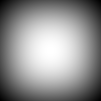

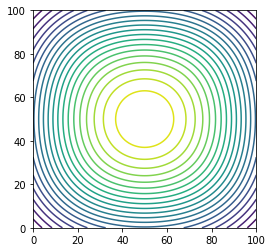

In [203]:
def visualize_rotational_symmetry_of_gaussian_filter(size1=11, size2=1001) -> None:
  gauss = GaussianFilter()
  # Because the continuous filter is rotationally symmetric, its value at a
  # distance 1.0 along a diagonal equals its value at a distance 1.0 along
  # an axis.
  assert np.allclose(gauss(2.0**-0.5)**2.0, gauss(1.0) * gauss(0.0))

  array = np.zeros((size1, size1))
  array[size1 // 2, size1 // 2] = 1
  image = resize(array, filter='gaussian', shape=(size2, size2))
  media.show_image(crop_array(image, int(size2 * .45)), border=True)
  _, ax = plt.subplots(figsize=(4, 4))
  ax.contour(crop_array(image, int(size2 * .45)), 20)
  # The upsampled signal does not have exact rotational symmetry.

visualize_rotational_symmetry_of_gaussian_filter()

# <a name="Creation-of-figure-images"></a>Creation of figure images

Images for "Example usage" section:


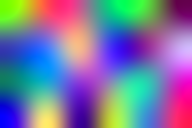


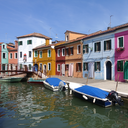

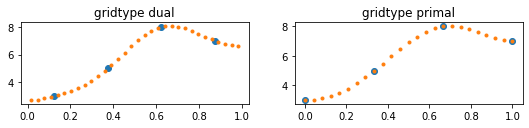


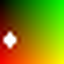
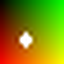
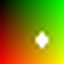


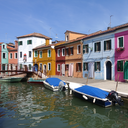


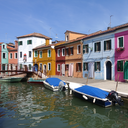

In [236]:
def generate_graphics_for_example_usage() -> None:
  array: Any

  rng = np.random.default_rng(seed=1)
  array = rng.random((4, 6, 3))  # 4x6 RGB image.
  upsampled = resize(array, (128, 192))  # To 128x192 resolution.
  media.show_images({'4x6': array, '128x192': upsampled}, height=128)

  image = media.read_image('https://github.com/hhoppe/data/raw/main/image.png')
  downsampled = resize(image, (32, 32))
  media.show_images({'128x128': image, '32x32': downsampled}, height=128)

  array = [3.0, 5.0, 8.0, 7.0]
  new_dual = resize(array, (32,))  # (default gridtype='dual') 8x resolution.
  new_primal = resize(array, (25,), gridtype='primal')  # 8x resolution.
  _, axs = plt.subplots(1, 2, figsize=(9, 1.5))
  axs[0].set_title('gridtype dual')
  axs[0].plot((np.arange(len(array)) + 0.5) / len(array), array, 'o')
  axs[0].plot((np.arange(len(new_dual)) + 0.5) / len(new_dual), new_dual, '.')
  axs[1].set_title('gridtype primal')
  axs[1].plot(np.arange(len(array)) / (len(array) - 1), array, 'o')
  axs[1].plot(np.arange(len(new_primal)) / (len(new_primal) - 1), new_primal, '.')
  plt.show()

  batch_size = 4
  batch_of_images = media.moving_circle((16, 16), batch_size)
  spacer = np.ones((64, 16, 3))
  upsampled = resize(batch_of_images, (batch_size, 64, 64))
  media.show_images([*batch_of_images, spacer, *upsampled], border=True, height=64)

  new = resize(image, (128, 512), boundary=('natural', 'reflect'), cval=(0.2, 0.7, 0.3),
               filter=('lanczos3', 'omoms5'), gamma='identity', scale=(0.8, 0.25),
               translate=(0.1, 0.35), precision='float64', dtype='float32')
  media.show_images({'image': image, 'new': new})

  shape = image.shape[:2]
  yx = ((np.indices(shape).T + 0.5) / shape - 0.5).T  # [-0.5, 0.5]^2
  radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
  angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
  coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5
  resampled = resample(image, coords, boundary='constant')
  media.show_images({'image': image, 'resampled': resampled})

generate_graphics_for_example_usage()


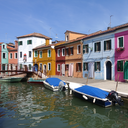
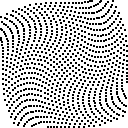
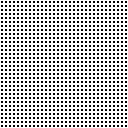
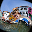

In [205]:
def generate_graphics_warp_samples() -> None:
  image = EXAMPLE_IMAGE
  shape = 32, 32
  yx = ((np.indices(shape).T + 0.5) / shape - 0.5).T  # [-0.5, 0.5]^2
  radius, angle = np.linalg.norm(yx, axis=0), np.arctan2(*yx)
  angle += (0.8 - radius).clip(0, 1) * 2.0 - 0.6
  coords = np.dstack((np.sin(angle) * radius, np.cos(angle) * radius)) + 0.5
  src_shape = 128, 128
  coords_image = np.full(src_shape, 1.0)
  for coord in coords.reshape(-1, 2):
    coord = (coord * src_shape + 0.5).astype(int)
    if np.all((coord >= 0) & (coord + 1 < src_shape)):
      coords_image[tuple(slice(coord[c], coord[c] + 2) for c in range(2))] = 0
  dst_image = resize(np.zeros(shape), src_shape, filter=NarrowBoxFilter(radius=0.15), cval=1)
  resampled = resample(image, coords, boundary='constant')
  images = {
      'source': image,
      'coords in source': coords_image,
      'destination grid': dst_image,
      'resampled': resampled
  }
  media.show_images(images, height=128, border=True)

generate_graphics_warp_samples()

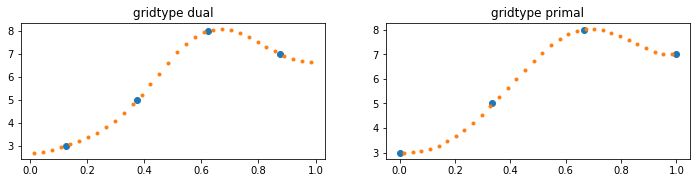

In [206]:
def generate_graphics_unused() -> None:
  array = [3.0, 5.0, 8.0, 7.0]
  upsampled = resize(array, (32,))
  _, ax = plt.subplots(figsize=(6, 2.5))
  ax.plot((np.arange(len(array)) + 0.5) / len(array), array, 'o')
  ax.plot((np.arange(len(upsampled)) + 0.5) / len(upsampled), upsampled, '.')

  array = [3.0, 5.0, 8.0, 7.0]

  def upsample_1d(ax, gridtype, ordinates) -> None:
    upsampled = resize(array, (32,), gridtype=gridtype)
    ax.plot(ordinates(array), array, 'o')
    ax.plot((np.arange(len(upsampled)) + 0.5) / len(upsampled), upsampled, '.')
    ax.set_title(f'gridtype {gridtype}')

  _, axs = plt.subplots(1, 2, figsize=(12, 2.5))
  upsample_1d(axs[0], 'dual', lambda x: (np.arange(len(x)) + 0.5) / len(x))
  upsample_1d(axs[1], 'primal', lambda x: np.arange(len(x)) / (len(x) - 1))

generate_graphics_unused()

Images for figures:


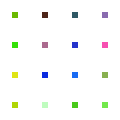
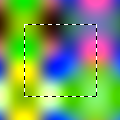
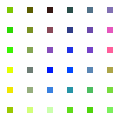

In [207]:
def generate_graphics_reconstruction_and_sampling() -> None:
  np.random.seed(1)
  array = np.random.rand(4, 4, 3)
  new = resize(array, (6, 6))
  images = {
      'samples': array,
      'sample_squares': resize(array, (120, 120), boundary='constant', cval=1.0,
                               filter=NarrowBoxFilter(radius=0.099)),
      'reconstruction': resize(array, (120, 120), boundary='constant', cval=1.0,
                               filter='lanczos3'),
      'wide_reconstruction': resize_showing_domain_boundary(array, (120, 120)),
      'new_samples': resize(new, (120, 120), boundary='constant', cval=1.0,
                            filter=NarrowBoxFilter(radius=0.128)),
  }
  media.show_images(images, border=False, height=120)

generate_graphics_reconstruction_and_sampling()

In [208]:
def generate_graphics_filters(num=1_001) -> None:
  filters = 'impulse box trapezoid triangle cubic lanczos3 lanczos10'.split()
  fig, axs = plt.subplots(1, len(filters), figsize=(12, 1.8))

  for index, filter_name in enumerate(filters):
    ax = axs.flat[index]
    filter = FILTERS[filter_name]
    if filter_name == 'lanczos3':
      filter_name += ' (def.)'  # Default filter.
    if filter_name == 'trapezoid':
      filter = TrapezoidFilter(radius=0.75)  # Some representative shape.

    x = resize(np.arange(-10.0, 11.0), (num,), gridtype='primal', filter='triangle')
    y = resize([0.0] * 10 + [1.0] + [0.0] * 10, (num,), gridtype='primal', filter=filter)
    if filter.name == 'impulse':
      y = (np.arange(num) == num // 2) * 100.0

    ax.plot(x, y)
    ax.set_xlim(-6.0, 6.0)
    ax.set_ylim(-0.30, 1.1)
    ax.yaxis.set_ticks([0.0, 1.0] if index == 0 else [])
    ax.xaxis.set_ticks(np.arange(-6, 7, 1))
    ax.tick_params(axis='x', labelbottom=False, direction='in')
    ax.set_title(f'{filter_name}')

  fig.tight_layout()


generate_graphics_filters()

**Grid type: `dual`**

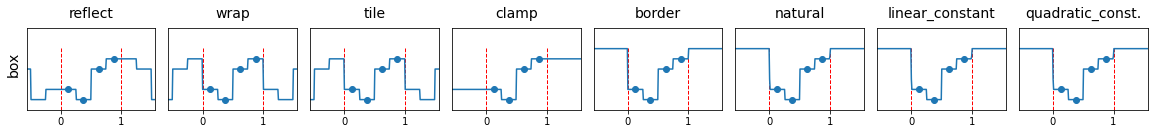

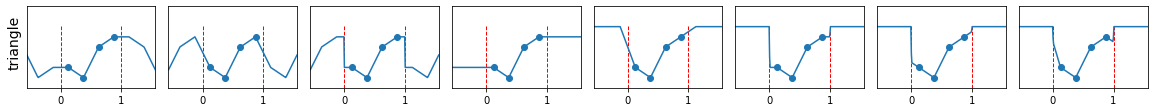

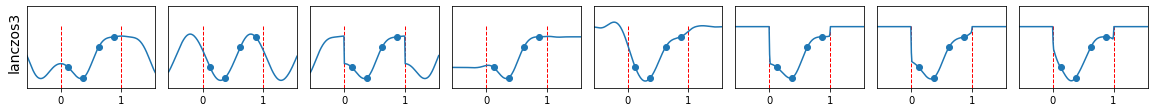

&emsp; &emsp; Graphics
    [texture sampling](https://www.khronos.org/opengl/wiki/Sampler_Object)
    supports a `dual` grid with the `box` or `triangle` filter, using the
    `reflect`, `wrap`, `clamp`, `reflect_clamp`, or `border` boundary.
  

<br/>**Grid type: `primal`**

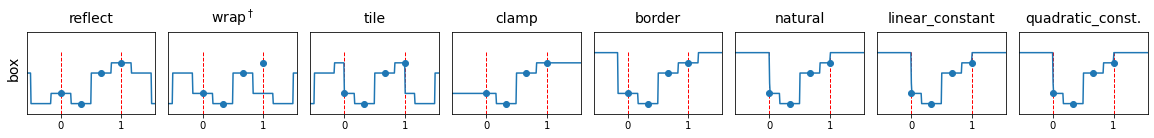

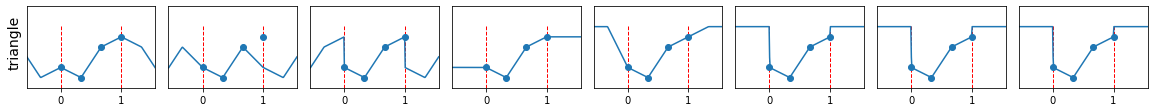

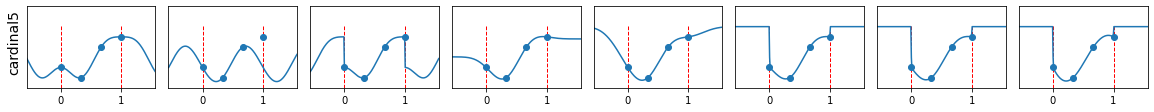

&emsp; &emsp; ${}^\dagger$To create a continuous periodic
    reconstruction, the last sample is ignored for the `wrap` boundary rule
    on a `primal` grid.
  

<br/>**For filters_summary figure:**

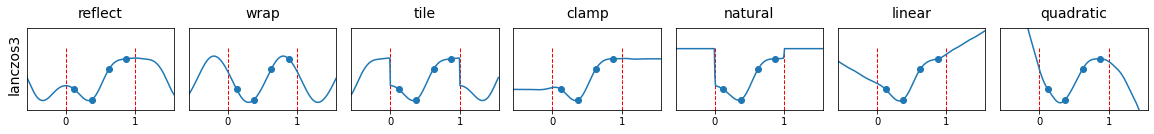

In [209]:
def visualize_boundary_rules_in_1d(*, scale=0.47) -> None:
  """Create 1D boundary rule plots similar to
  https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html#ndimage-interpolation-modes"""

  def visualize_gridtype(gridtype, boundaries=None, num_samples=250,
                         filters=('box', 'triangle', 'lanczos3', 'cardinal5')) -> None:
    boundaries = _OFTUSED_BOUNDARIES if boundaries is None else boundaries
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    for row_index, filter in enumerate(filters):
      fig, axs = plt.subplots(1, len(boundaries), figsize=(18, 1.5))
      fig.subplots_adjust(wspace=0.1)
      array = np.array([0.6, 0.5, 0.8, 0.9])
      for column_index, boundary in enumerate(boundaries):
        ax = axs.flat[column_index]
        for x_value in [0.0, 1.0]:
          ax.axvline(x=x_value, ymin=0.0, ymax=0.77, color='red',
                     linestyle='--', linewidth=1)
        resized = resize(array, (num_samples,), src_gridtype=gridtype, dst_gridtype='dual',
                         boundary=boundary, cval=1.0, filter=filter,
                         scale=scale, translate=(1 - scale) / 2)
        offset = (1 - scale) / 2 / scale
        x = (np.arange(len(resized)) + 0.5) / len(resized) / scale - offset
        ax.plot(x, resized, '-', color=color, label=boundary)
        x = np.arange(len(array))
        x = GRIDTYPES[gridtype].point_from_index(x, len(array))
        ax.plot(x, array, 'o', color=color)
        ax.set_xlim(-offset, 1.0 + offset)
        ax.set_ylim(0.4, 1.2)
        ax.set_xticks([0, 1])
        ax.set_yticks([])
        title_replacement = {'quadratic_constant': 'quadratic_const.'}
        title = title_replacement.get(boundary, boundary)
        dagger = r'$^\dagger$' if gridtype == 'primal' and boundary == 'wrap' else ''
        if row_index == 0:
          ax.set_title(f'{title}{dagger}', x=0.5, y=1.05, fontsize=14)
      plt.subplots_adjust(left=0.035)
      plt.gcf().text(0.02, 0.55, filter, fontsize=14,
                     rotation='vertical', verticalalignment='center')
      plt.show()

  media.set_max_output_height(3000)

  display_markdown('**Grid type: `dual`**')
  visualize_gridtype('dual')
  display_markdown("""&emsp; &emsp; Graphics
    [texture sampling](https://www.khronos.org/opengl/wiki/Sampler_Object)
    supports a `dual` grid with the `box` or `triangle` filter, using the
    `reflect`, `wrap`, `clamp`, `reflect_clamp`, or `border` boundary.
  """)

  display_markdown('<br/>**Grid type: `primal`**')
  visualize_gridtype('primal')
  display_markdown(r"""&emsp; &emsp; ${}^\dagger$To create a continuous periodic
    reconstruction, the last sample is ignored for the `wrap` boundary rule
    on a `primal` grid.
  """)

  display_markdown('<br/>**For filters_summary figure:**')
  boundaries = 'reflect wrap tile clamp natural linear quadratic'.split()
  visualize_gridtype('dual', filters=['lanczos3'], boundaries=boundaries)


visualize_boundary_rules_in_1d()

**Upsampling of a 2D grid (`dual` in $y$ and `primal` in $x$)**


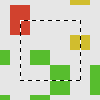
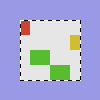


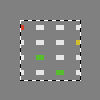
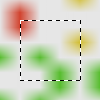
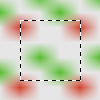
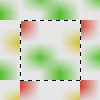
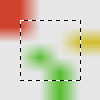
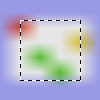
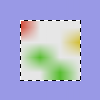
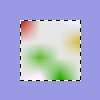
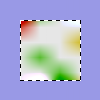


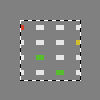
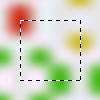
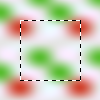
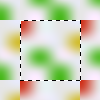
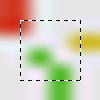
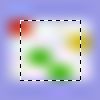
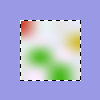
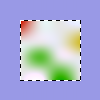
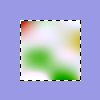


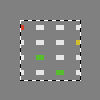
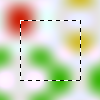
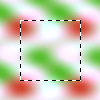
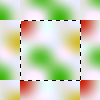
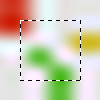
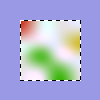
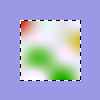
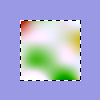

<br/>**Wider view of the same results**


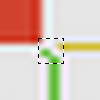
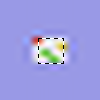
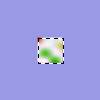

In [210]:
def visualize_boundary_rules_in_2d(*, scale=0.6, src_gridtype=('dual', 'primal'),
                                   cval=(0.6, 0.6, 0.9)) -> None:
  media.set_max_output_height(2000)
  shape = (120, 120) if hh.in_colab() else (100, 100)
  if 1:
    # In Colab, the defined HTML style is local to each cell (iframe), whereas in jupyter the
    # style is global across all cells.
    s = """
      <style>
        table.show_images2 { font-size: FONT-SIZE; }
        table.show_images2 div div:nth-of-type(2) { padding-top: 5px; }
        .show_images2 td { padding:1px; }
      </style>
    """.replace('FONT-SIZE', 'medium' if hh.in_colab() else 'small')
    display_html(s)
  # array = np.array([[1.0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0], [0, 1, 0, 0]])
  # array = np.indices((4, 4), dtype=np.float64).sum(axis=0) / 6.0
  # array = np.dstack((array,) * 3)
  o, a, b, c = (0.0, 0.0, 0.0), (1.0, 0.3, 0.2), (0.4, 1.0, 0.2), (0.8, 0.7, 0.1)
  o, a, b, c = (1.0, 1.0, 1.0), (0.9, 0.2, 0.1), (0.3, 0.8, 0.1), (0.9, 0.8, 0.1)
  array = np.array([[a, o, o, o], [o, o, o, c], [o, b, o, o], [o, o, b, o]])
  # array = array * 0.5 + 0.25
  array = array * 0.8 + 0.1

  def show_row(show_titles, scale=scale) -> None:
    kwargs = dict(shape=shape, src_gridtype=src_gridtype,
                  dst_gridtype='dual', scale=scale, translate=(1 - scale) / 2)
    title_replacement = {'quadratic_constant': 'quadratic_const.'}
    images = {
        title_replacement.get(boundary, boundary):
            resize_showing_domain_boundary(
                array, boundary=boundary, cval=cval, filter=filter, **kwargs)
        for boundary in _OFTUSED_BOUNDARIES
    }
    image_samples = resize_showing_domain_boundary(
        array, boundary='constant', cval=0.5, filter='narrowbox', **kwargs)
    images = {'(samples)': image_samples, **images}
    images2 = images if show_titles else images.values()
    # Benefit of show_images() over matplotlib.imshow() is no pixel resampling.
    media.show_images(images2, ylabel=filter, html_class='show_images2')

  display_markdown('**Upsampling of a 2D grid (`dual` in $y$ and `primal` in $x$)**')
  for row_index, filter in enumerate('box triangle cubic lanczos3'.split()):
    show_row(show_titles=(row_index == 0))

  display_markdown('<br/>**Wider view of the same results**')
  filter = 'lanczos3'
  show_row(show_titles=True, scale=0.25)


visualize_boundary_rules_in_2d()

# Comparisons with other libraries

In [211]:
# Useful references:
# https://stackoverflow.com/questions/48097941/strided-convolution-of-2d-in-numpy
# https://docs.scipy.org/doc/scipy/reference/sparse.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [212]:
# Other image resampling libraries, with their parameter names and values:

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html
#  boundary='fill'  # or 'wrap', 'symm'.
#  fillvalue=0  # used for 'fill'.
#  Only convolution; not strided; therefore no resizing.

# https://numpy.org/doc/stable/reference/generated/numpy.pad.html
#  mode='constant'  # or 'edge', 'linear_ramp', 'maximum', 'mean', 'median',
#                   #   'minimum', 'reflect', 'symmetric', 'warp', 'empty'.
#  reflect_type='even'  # or 'odd'; for 'reflect' and 'symmetric'.

# TODO: Compare with my results and verify the assumptions on the parameters.

<font size="+1">**Comparison table:**</font>

| Library | `ndim` | Array type | Data type | Grid type | Upsample | Antialiased downsample | Boundary rule | Speed | Native code | Grad &nabla; |
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| `resampler.resize` | any | `np`, `tf`, `torch` | any | dual, primal | any filter | any filter | many | fast | none | yes |
| `PIL.Image.resize` | 2D | custom | `float32`, `uint8` | dual | up to `lanczos3` | good | `natural` | average | C | no |
| `cv.resize` | 2D | custom | `float32` | dual | up to `lanczos4` | `trapezoid` (AREA) | several | fast | C++ | no |
| `scipy.ndimage` | any | `np` | any | ~dual, primal | cardinal B-splines | aliased &#9785; | several | slow | C | no |
| `skimage.transform` | any | `np` | any | dual, primal | cardinal B-splines | Gaussian &#9785; | several | slow | Cython | no |
| `tf.image.resize` | 2D | `tf` | `float32` | dual | up to `lanczos5` | `linear`, `cubic`? | `natural` | average | C++ | yes |
| `torch.nn.functional.` &nbsp;`interpolate` | 1D-3D | `torch` | `float32`, `float64` | dual | up to cubic | `trapezoid`, `linear`, `cubic` | `?` | average | C++ | yes |
| `torchvision.transforms.` &nbsp;`functional.resize` | 2D | `tf` | most | dual | up to cubic | `linear`, `cubic` | `?` | average | C++ | yes |

The `resampler` library does not involve any new native code;
it instead leverages existing sparse matrix representations and operations.

What about support for general resampling (not just resize)?

## <a name="Test-other-libraries"></a>Test other libraries

## Upsampling comparison

float32 src_shape=(100, 200, 3) strides=(2400, 12, 4) dst_shape=(200, 400)



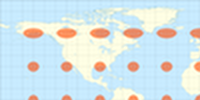
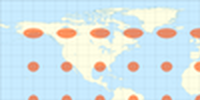
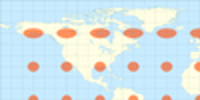
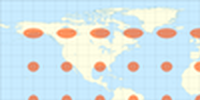
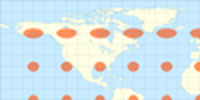
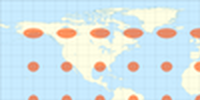
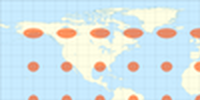
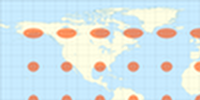
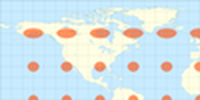
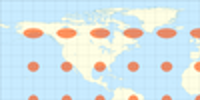
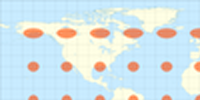
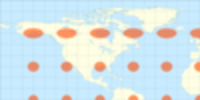
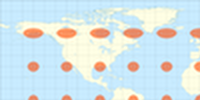

In [213]:
def experiment_compare_upsampling_with_other_libraries(scale=2.0, shape=(200, 400)) -> None:
  # All filtering is done in lightness space (i.e. with gamma='identity').
  original = resize(media.to_float01(example_tissot_image()), shape,
                    filter='trapezoid', dtype=np.float32)  # Was 'lanczos5'.
  downsampled_shape_2d = (np.array(shape) / scale + 0.5).astype(int)
  array = resize(original, downsampled_shape_2d, filter='lanczos5')
  if 1:
    array = np.ascontiguousarray(array)  # Compactify, removing cropped X and Y.
  if 0:
    array = np.swapaxes(np.swapaxes(array, 0, 1).copy(), 0, 1)  # Transpose memory layout.
  print(f'{array.dtype} src_shape={array.shape} strides={array.strides} dst_shape={shape}')

  coords = ((np.indices(original.shape).T + 0.5) / (scale, scale, 1) - 0.5).T

  # This matrix and offset are inexact for dual grid resize.
  matrix = np.diag([1 / scale, 1 / scale, 1])
  offset = 0
  shape3 = shape + original.shape[2:]

  import tensorflow as tf
  import cv2 as cv

  funcs = {
      'original': lambda: original,
      # 'resize lanczos4': lambda: resize(array, shape, filter=LanczosFilter(radius=4)),
      # 'resample lanczos5': lambda: resize_using_resample(array, shape, filter='lanczos5'),
      'resize lanczos5': lambda: resize(array, shape, filter='lanczos5'),
      'resize lanczos3': lambda: resize(array, shape, filter='lanczos3'),
      'resize cardinal3': lambda: resize(array, shape, filter='cardinal3'),
      'resize cubic': lambda: resize(array, shape, filter='cubic'),
      'resize linear': lambda: resize(array, shape, filter='triangle'),
      'resize_in_tensorflow lanczos3': lambda: resize_in_tensorflow(array, shape, filter='lanczos3'),
      'resize_in_torch lanczos3': lambda: resize_in_torch(array, shape, filter='lanczos3'),
      'resample lanczos3': lambda: resize_using_resample(array, shape, filter='lanczos3'),
      'PIL.Image.resize lanczos3': lambda: pil_image_resize(array, shape, 'lanczos3'),
      'PIL.Image.resize cubic': lambda: pil_image_resize(array, shape, 'cubic'),
      # 'ndimage.zoom': lambda: scipy.ndimage.zoom(array, (scale, scale, 1.0)),
      # 'ndimage.affine_transform': lambda: scipy.ndimage.affine_transform(array, matrix, offset, shape3),
      'map_coordinates order=3': lambda: scipy.ndimage.map_coordinates(array, coords, order=3, mode='reflect'),
      'skimage.transform.resize': lambda: skimage.transform.resize(array, shape, order=3, mode='symmetric'),
      'tf.resize lanczos5': lambda: tf.image.resize(array, shape, method='lanczos5'),
      'tf.resize lanczos3': lambda: tf.image.resize(array, shape, method='lanczos3'),
      # 'tf.resize cubic new': lambda: tf.image.resize(array, shape, method='bicubic', antialias=True),  # newer: resize_with_scale_and_translate('keyscubic')
      'tf.resize cubic (aa False)': lambda: tf.image.resize(array, shape, method='bicubic', antialias=False),  # older: gen_image_ops.resize_bicubic()
      'torch.nn.interp sharpcubic': lambda: torch_nn_resize(array, shape, 'sharpcubic'),
      'torch.nn.interpolate linear': lambda: torch_nn_resize(array, shape, 'triangle'),
      # 'torch.nn.interp cubic AA': lambda: torch_nn_resize(array, shape, 'sharpcubic', antialias=True),
      # 'torch.nn.interp linear AA': lambda: torch_nn_resize(array, shape, 'triangle', antialias=True),
      # 'torchvision sharpcubic': lambda: torchvision_resize(array, shape, 'sharpcubic'),
      # 'torchvision linear': lambda: torchvision_resize(array, shape, 'triangle'),
      # 'torchvision sharpcubic AA': lambda: torchvision_resize(array, shape, 'sharpcubic', antialias=True),
      # 'torchvision linear AA': lambda: torchvision_resize(array, shape, 'triangle', antialias=True),
      'cv.resize lanczos4': lambda: cv.resize(array, shape[::-1], interpolation=cv.INTER_LANCZOS4),
      'cv.resize (sharp)cubic': lambda: cv.resize(array, shape[::-1], interpolation=cv.INTER_CUBIC),
  }
  del matrix, offset, shape3
  images = {}
  for name, func in funcs.items():
    elapsed, image = hh.get_time_and_result(func, max_time=0.05)
    image = _arr_numpy(image)
    check_eq(image.dtype, np.float32)
    s = 0  # 0 or 2.  (Recall that boundary rules are broken in scipy 1.4.1.)
    crop = s, s, 0
    psnr = get_psnr(crop_array(image, crop), crop_array(original, crop))
    name = f'{name}  psnr:{psnr:.2f} dB  ({elapsed * 1000:.2f} ms)'
    images[name] = image

  if 1:  # Optionally crop the images
    images = {name: image[:100, :200] for name, image in images.items()}
  media.set_max_output_height(2000)
  # with media.set_show_save_dir('/tmp'):
  show_args = dict(width=400, columns=5) if hh.in_colab() else dict(width=300, columns=3)
  media.show_images(images, **show_args)
  # media.show_video([upsampled3, upsampled4], fps=1, height=400, codec='gif')

experiment_compare_upsampling_with_other_libraries()
# experiment_compare_upsampling_with_other_libraries(scale=1.9)

Conclusions for upsampling:
- `ndimage` has broken boundary rules in `scypi 1.4.1`.
- Ignoring the boundaries, the cardinal spline of `order=3` does as well as
  `lanczos3`.
- `tf.resize` using `lanczos5` and `boundary='natural'` is slightly worse
  than `resize` using `lanczos5` and `boundary='reflect'` near the boundary.
- `resize` is generally very fast, but is not as fast as OpenCV for
  cubic upsampling.

## Downsampling comparison

float32 src_shape=(1000, 2000, 3) strides=(24000, 12, 4) dst_shape=(100, 200)



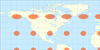
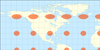
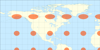
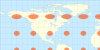
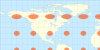
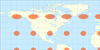
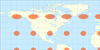
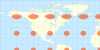
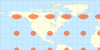
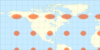
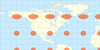
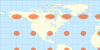
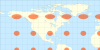
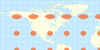
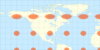
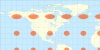

In [214]:
def experiment_compare_downsampling_with_other_libraries(scale=0.1, shape=(100, 200)) -> None:
  # All filtering is done in lightness space (i.e. with gamma='identity').
  original_shape_2d = (np.array(shape) / scale + 0.5).astype(int)
  original = resize(media.to_float01(example_tissot_image()), original_shape_2d,
                    filter='lanczos5', dtype=np.float32)
  if 1:
    original = np.ascontiguousarray(original)  # Compactify, removing cropped X and Y.
  if 0:
    original = np.swapaxes(np.swapaxes(original, 0, 1).copy(), 0, 1)  # Transpose memory layout.
  array = original
  print(f'{array.dtype} src_shape={array.shape} strides={array.strides} dst_shape={shape}')

  # scipy.ndimage default is order=3, mode='constant'.
  shape3 = shape + original.shape[2:]
  coords = ((np.indices(shape3).T + 0.5) / (scale, scale, 1) - 0.5).T

  matrix = np.diag([1 / scale, 1 / scale, 1])
  # offset = 0
  offset = 0.5, 0.5, 0  # Closer to the result of zoom() but still different.

  import tensorflow as tf
  import cv2 as cv

  funcs: Dict[str, Callable[[], _NDArray]] = {
      # 'resize lanczos5': lambda: resize(array, shape, filter='lanczos5'),
      'resize lanczos3': lambda: resize(array, shape),
      'resize cardinal3': lambda: resize(array, shape, filter='cardinal3'),
      'resize cubic': lambda: resize(array, shape, filter='cubic'),
      'resize linear': lambda: resize(array, shape, filter='triangle'),
      'resize trapezoid': lambda: resize(array, shape, filter='trapezoid'),
      'resize box': lambda: resize(array, shape, filter='box'),
      'resize_in_tensorflow lanczos3': lambda: resize_in_tensorflow(array, shape),
      'resize_in_tensorflow trapezoid': lambda: resize_in_tensorflow(array, shape, filter='trapezoid'),
      'resize_in_torch lanczos3': lambda: resize_in_torch(array, shape),
      'resize_in_torch trapezoid': lambda: resize_in_torch(array, shape, filter='trapezoid'),
      'resample lanczos3': lambda: resize_using_resample(array, shape, filter='lanczos3'),
      'PIL.Image.resize lanczos3': lambda: pil_image_resize(array, shape, 'lanczos3'),
      # 'PIL.Image.resize cubic': lambda: pil_image_resize(array, shape, 'cubic'),
      'PIL.Image.resize box': lambda: pil_image_resize(array, shape, 'box'),
      # 'ndimage.zoom': lambda: scipy.ndimage.zoom(array, (scale, scale, 1.0)),
      # 'ndimage.affine_transform': lambda: scipy.ndimage.affine_transform(array, matrix, offset, shape3),
      'map_coordinates order=3': lambda: scipy.ndimage.map_coordinates(array, coords, order=3),
      'skimage.transform.resize': lambda: skimage.transform.resize(array, shape, order=3, mode='symmetric', anti_aliasing=True),
      'tf.resize lanczos3': lambda: tf.image.resize(array, shape, method='lanczos3', antialias=True),
      # alias=True),
      'tf.resize trapezoid': lambda: tf.image.resize(array, shape, method='area', antialias=True),
      # 'torch.nn.interpolate cubic': lambda: torch_nn_resize(array, shape, 'sharpcubic'),
      # 'torch.nn.interpolate linear': lambda: torch_nn_resize(array, shape, 'triangle'),
      'torch.nn.interp trapezoid': lambda: torch_nn_resize(array, shape, 'trapezoid'),  # 'area' is already AA.
      'torch.nn.interp cubic AA': lambda: torch_nn_resize(array, shape, 'sharpcubic', antialias=True),
      'torch.nn.interp linear AA': lambda: torch_nn_resize(array, shape, 'triangle', antialias=True),
      # 'torchvision (sharp)cubic': lambda: torchvision_resize(array, shape, 'sharpcubic'),
      # 'torchvision linear': lambda: torchvision_resize(array, shape, 'triangle'),
      # 'torchvision (sharp)cubic AA': lambda: torchvision_resize(array, shape, 'sharpcubic', antialias=True),
      # 'torchvision linear AA': lambda: torchvision_resize(array, shape, 'triangle', antialias=True),
      # torchvision does not have differentiable box/trapezoid.
      # 'cv.resize lanczos4': lambda: cv.resize(array, shape[::-1], interpolation=cv.INTER_LANCZOS4),  # Aliased.
      'cv.resize trapezoid': lambda: cv.resize(array, shape[::-1], interpolation=cv.INTER_AREA),
  }
  del matrix, offset
  images = {}
  for name, func in funcs.items():
    if name == 'resize trapezoid':
      func()  # Precompile the code.
    elapsed, image = hh.get_time_and_result(func, max_time=0.05)
    image = _arr_numpy(image)
    upsampled = _original_resize(image, original.shape[:2], filter='lanczos5')
    s = 0  # 0 or 2.  (Recall that boundary rules are broken in scipy 1.4.1.)
    crop = s, s, 0
    psnr = get_psnr(crop_array(upsampled, crop), crop_array(original, crop))
    name = f'{name}  psnr:{psnr:.2f} dB  ({elapsed * 1000:.2f} ms)'
    images[name] = image

  if 1:  # Optionally crop the images
    images = {name: image[:50, :100] for name, image in images.items()}
  media.set_max_output_height(2000)
  # with media.set_show_save_dir('/tmp'):
  show_args = dict(width=400, columns=5) if hh.in_colab() else dict(width=300, columns=3)
  media.show_images(images, **show_args)

experiment_compare_downsampling_with_other_libraries()
# experiment_compare_downsampling_with_other_libraries(scale=1/8)
# experiment_compare_downsampling_with_other_libraries(scale=0.1007)

In [215]:
def test_downsample_timing() -> None:
  """Check that we account for strides in _best_order_in_which_to_process_dimensions()."""
  for with_copy in [False, True]:
    for shape in [(1000, 2000), (900, 1800), (800, 1600)]:
      array = resize(media.to_float01(example_tissot_image()),
                     shape, filter='lanczos5', dtype=np.float32)
      if with_copy:
        array = np.ascontiguousarray(array)  # Like copy(), it keeps a stride of 4.
      print(array.dtype, array.shape, array.strides)
      hh.print_time(lambda: resize(array, (100, 200), filter='lanczos3', boundary='reflect'),
                    max_time=0)

test_downsample_timing()

float32 (1000, 2000, 3) (24000, 12, 4)
9.18 ms
float32 (900, 1800, 3) (12, 10800, 4)
8.43 ms
float32 (800, 1600, 3) (12, 9600, 4)
7.37 ms
float32 (1000, 2000, 3) (24000, 12, 4)
8.38 ms
float32 (900, 1800, 3) (21600, 12, 4)
7.95 ms
float32 (800, 1600, 3) (19200, 12, 4)
6.72 ms


Conclusions for downsampling:
- The `ndimage`, `torch.nn`, and `torchvision` libraries do not apply
  prefiltering when downsampling, and therefore introduce aliasing.
- With `ndimage`, it is difficult to create the right transform / coords to
  exactly resize a dual grid.  The `zoom()` in the more recent `scipy` has new
  `grid_mode='True'` to assist with this.
- Using `anti_aliasing=True` in `skimage.transform.resize` introduces a
  Gaussian prefilter which prevents aliasing but is blurry.
- `torchvision.transforms.functional.resize` seems to produce identical results to
  `torch.nn.functional.interpolate`, but a little slower and
  with slightly less functionality (no antialiased 'area' downsampling).
- OpenCV's best downsampling is `AREA`, which is slightly inferior.
- The `resize` box-filtering (using `numba`) is as fast as the C++
  `tf.image.resize` and `OpenCV` implementations.
- The `resize` Lanczos prefilter is also the fastest antialiased version.

# Export Python

In [216]:
# Export: end.

In [217]:
def get_notebook_code(filename: str) -> Iterator[str]:
  """Yield notebook code cells as multiline strings."""

  def code_cells_from_notebook(notebook: Dict[str, Any]) -> Iterator[str]:
    """Yield notebook code cells from a JSON notebook."""
    for cell in notebook['cells']:
      if cell['cell_type'] == 'code':
        yield ''.join(cell['source'])

  # Yield code cells as they are currently defined in a Colab notebook.
  try:
    import google.colab
  except ModuleNotFoundError:
    pass
  else:
    # Load the notebook JSON; takes ~10 s.
    # pylint: disable-next=protected-access
    nb = google.colab._message.blocking_request('get_ipynb', timeout_sec=60)
    yield from code_cells_from_notebook(nb['ipynb'])
    return

  # Yield code cells as they were last saved by jupytext.
  try:
    import jupytext
    notebook = jupytext.read(filename)
  except (ModuleNotFoundError, FileNotFoundError):
    pass
  else:
    yield from code_cells_from_notebook(notebook)
    return

  # Yield code cells as they were first ran within the notebook.
  only_ran_once = sum('def save_notebook_inputs' in text for text in In) == 1
  if only_ran_once:
    assert 'In' in globals()
    for cell in In[1:]:
      yield cell
    return

  raise AssertionError('No access to notebook cell contents.')

In [218]:
def save_notebook_inputs_to_python_files(filename: str) -> None:

  def contains_only_comments(cell: str) -> bool:
    return not re.sub(r'(?m)^ *#.*$', r'', cell).strip()

  within_notebook_definitions = False
  text_lib = []
  text_all = []
  for cell in get_notebook_code(filename):
    if cell == '# Export: end.':
      break
    if '# Export: none.' in cell:
      continue
    if cell == '# Export: begin notebook definitions.':
      within_notebook_definitions = True
      continue
    if cell == '# Export: end notebook definitions.':
      within_notebook_definitions = False
      continue

    cell = re.sub(r'""";$', '"""', cell)

    outside_lib = within_notebook_definitions or contains_only_comments(cell) or any(
        s in cell for s in ['# Export: outside library.', 'def test', 'def experiment',
                            'def visualize', 'def generate_graphics'])
    if not outside_lib:
      text_lib.append(cell)

    cell = cell.replace('# End-of-notebook-imports.\n',
                        'matplotlib.use("PDF")\n'
                        'media.set_max_output_height = lambda x: None\n')
    cell = re.sub(r'# Export: outside library.\n+', '', cell)
    text_all.append(cell)

  text = '\n\n\n'.join(text_lib) + '\n'
  text += '\n\n# For Emacs:\n# Local Variables: *\n# fill-column: 100 *\n# End: *\n'
  hh.run('mkdir -p ./resampler')
  pathlib.Path('resampler/__init__.py').write_text(text)

  text = '\n\n\n'.join(text_all) + '\n'
  pathlib.Path('resampler_all.py').write_text(text)

save_notebook_inputs_to_python_files('resampler_notebook.py')

In [219]:
def run_doctest(filename: str, debug: bool = False) -> None:
  hh.run(f'python3 -m doctest{" -v" if debug else ""} {filename}')

run_doctest('resampler/__init__.py')

In [220]:
def run_spell_check(filename: str, commit_new_words: bool = False) -> None:
  """Look for misspelled words in notebook."""
  path = pathlib.Path(filename)
  if path.is_file():
    # -Fxvif: fixed_string, match_whole_line, invert_match, case_insensitive, patterns_from_file.
    find = f"""cat {path} | perl -pe "s@https?:/.*?[)> ]@@g; s/'/ /g" | spell | \
               sort -u | grep -Fxvif {path.stem}.spell"""
    if commit_new_words:
      hh.run(f'{find} >v.spell; cat v.spell >>{path.stem}.spell && rm v.spell')
    else:
      hh.run(f'{find} || true')

run_spell_check('resampler_notebook.py')

In [221]:
if 0:  # To commit new words to local dictionary.
  run_spell_check('resampler_notebook.py', commit_new_words=True)

In [222]:
def run_lint(filename: str, strict: bool = False) -> None:
  """Run checks on *.py notebook code (saved using jupytext or from menu)."""
  if not pathlib.Path(filename).is_file():
    return
  mypy_args = '--strict --ignore-missing-imports'
  s = '' if strict else 'type annotation for one or more arguments|'
  mypy_grep = f'egrep -v "{s}gradgradcheck|Untyped decorator|Name .In| errors? in 1 file"'
  autopep8_args = '-aaa --max-line-length 100 --indent-size 2 --diff --ignore'
  autopep8_ignore = 'E265,E121,E125,E128,E129,E131,E226,E302,E305,E703'  # E501
  pylint_disabled = ('C0301,C0302,W0125,C0114,R0913,W0301,R0902,W1514,R0914,C0103,C0415'
                     ',R0903,W0622,W0640,W0511,C0116,R1726,R1727,C0411,C0412')
  pylint_args = f'--indent-string="  " --disable={pylint_disabled}'
  pylint_grep = (' | egrep -v "E1101: Module .(torch|cv2)|Undefined variable .In|Method .(jvp|vjp)'
                 '|W0221.*(forward|backward)|colab"' +
                 ("" if strict else " | grep -v 'Missing function or method docstring'"))
  hh.run(f'echo mypy; mypy {mypy_args} "{filename}" | {mypy_grep} || true')
  hh.run(f'echo autopep8; autopep8 {autopep8_args} {autopep8_ignore} "{filename}"')
  hh.run(f'echo pylint; pylint {pylint_args} "{filename}" {pylint_grep} || echo Error.')
  # hh.run(f'echo doctest; python3 -m doctest -v "{filename}"')
  print('All ran.')

In [223]:
if EFFORT >= 2 or 0:
  run_lint('resampler_notebook.py')

In [224]:
if EFFORT >= 2 or 0:
  run_lint('resampler/__init__.py', strict=True)

In [225]:
if EFFORT >= 2 or 0:
  run_lint('resampler_all.py')

From Windows Emacs, `compile` command:
```shell
c:/windows/sysnative/wsl -e bash -lc 'f=resampler_notebook.py; echo mypy; env mypy --strict --ignore-missing-imports "$f" | egrep -v "type annotation for one or more arguments|gradgradcheck|Untyped decorator|Name .In| errors? in 1 file"; echo autopep8; autopep8 -aaa --max-line-length 100 --indent-size 2 --ignore E265,E121,E125,E128,E129,E131,E226,E302,E305,E703 --diff "$f"; echo pylint; pylint --indent-string="  " --disable=C0103,C0302,C0415,R0902,R0903,R0913,R0914,W0640,W0125,C0413,W1514 --disable=C0301,C0114,W0301,R0903,W0622,W0640,W0511,C0116,R1726,R1727,C0411,C0412 "$f" | egrep -v "E1101: Module .(torch|cv2)|Undefined variable .In|Method .(jvp|vjp)|W0221.*(forward|backward)|colab"; echo All ran.'
```

From Windows Emacs, `compile` command:
```shell
c:/windows/sysnative/wsl -e bash -lc 'f=resampler/__init__.py; echo mypy; env mypy --strict --ignore-missing-imports "$f" | egrep -v "gradgradcheck|Untyped decorator| errors? in 1 file"; echo autopep8; autopep8 -aaa --max-line-length 100 --indent-size 2 --ignore E265,E121,E125,E128,E129,E131,E226,E302,E305,E703 --diff "$f"; echo pylint; pylint --indent-string="  " --disable=C0103,C0301,C0302,R0903,R0913,R0914,W0125,W0301,W0511,W0622,W0640 "$f" | egrep -v "E1101: Module .(torch|cv2)|Method .(jvp|vjp)|W0221.*(forward|backward)|C0415.*(tensorflow|torch|PIL|cv2)"; echo All ran.'
```

In [226]:
def run_exported_python_code() -> None:
  hh.run('pip install -qU matplotlib')  # Was necessary (+restart).
  hh.run('python3 resampler/__init__.py')
  hh.run('python3 resampler_all.py')

if 0 and EFFORT >= 3:  # Doubles the already slow runtime.
  run_exported_python_code()

In [227]:
if 0:
  # hh.run('(apt update && apt install -y python3.7-venv)')  # To get "ensurepip".
  # hh.run('(apt update && apt install -y python3.10-venv)')  # To get "ensurepip".
  # hh.run('pip install -q build twine')
  hh.run('git clone -q https://github.com/hhoppe/resampler')
  hh.run('(cd resampler; python3 -m build)')  # Creates dist/*.
  hh.run('(cd resampler; python3 -m twine upload dist/*)')  # Uploads to pypi.org.
  hh.run('echo "Update should be visible soon at https://pypi.org/project/resampler/."')

In [228]:
if 0:
  # hh.run('git clone -q https://github.com/google/mediapy')
  hh.run('(apt update && apt install -y python3.7-venv)')  # To get "ensurepip".
  # hh.run('pip install -q build twine')
  hh.run('(cd mediapy; python -m build)')  # Creates dist/*.
  hh.run('(cd mediapy; python -m twine upload dist/*)')  # Uploads to pypi.org.

In [229]:
def make_pdoc() -> None:
  """Create pdoc HTML documentation."""
  # hh.run('pip install -q pdoc3')  # try pdoc instead?
  # hh.run('mkdir -p pdoc/resampler')
  # hh.run('cp -p resampler/__init__.py pdoc/resampler/__init__.py')
  # hh.run('pdoc --html --force pdoc')
  hh.run('pdoc -html --force .')  # ?
  hh.run('ls -al html/resampler.html')

if 0:  # Run within a docker or other container.
  make_pdoc()

In [230]:
def test_pdoc() -> None:
  hh.run('mkdir -p test1/test1')
  hh.run(
      "(echo 'from typing import Union';"
      " echo 'def test1_func(arg: Union[None, str, int]) -> None:';"
      " echo '  return') > test1/test1/__init__.py")
  hh.run('cat test1/test1/__init__.py')
  hh.run('pdoc --html --force test1')
  hh.run('pdoc --version')

if 0:  # For debug.
  test_pdoc()
# It shows:
# def test1_func(arg: Union[ForwardRef(None), str, int]) -> None
# https://github.com/pdoc3/pdoc/issues/395

In [231]:
# Publish pdoc to GitHub.
_ = r"""
tmp_dir=$(mktemp -d)
cd "${tmp_dir}"
git clone -q --branch=main https://github.com/hhoppe/resampler resampler
(cd resampler; pdoc --html --force --template-dir=pdoc_template resampler)
git clone -q --branch=gh-pages https://github.com/hhoppe/resampler gh-pages
cd gh-pages
git config user.email "hhoppe@gmail.com"
git config user.name "Hugues Hoppe"
cp ../resampler/html/resampler/index.html .
git add index.html
git commit --amend -m "Update documentation in branch gh-pages."
git push -f -q origin gh-pages
cd /
rm -rf "${tmp_dir}"
echo "Update should be visible soon at https://hhoppe.github.io/resampler/."
"""

# Epilog

In [232]:
hh.analyze_lru_caches(globals())

# example_tissot_image                      1/inf        0.875 hit=            7 miss=            1
# example_vector_graphics_image             1/inf        0.750 hit=            3 miss=            1


In [233]:
def show_added_global_variables_sorted_by_type() -> None:
  for typename, name in sorted(
      (type(value).__name__, name) for name, value in globals().items()):
    if not any((
        name in _ORIGINAL_GLOBALS,
        name.startswith(('_', 'test_', 'visualize_')),
        typename in ['_GenericAlias', '_SpecialGenericAlias',
                     'type', 'function', '_lru_cache_wrapper', 'CPUDispatcher'],
        len(name) >= 6 and name.upper() == name,
        name in ''.split(),
    )):
      print(f'# {typename:24} {name}')

show_added_global_variables_sorted_by_type()

In [234]:
print(f'EFFORT={EFFORT}')
hh.show_notebook_cell_top_times()

EFFORT=1
# Total time: 49.28 s
# In[220] def run_spell_check(filename: str, commit_new_words: bool =  3.542 s
# In[159] def test_profile_downsampling(shape, new_shape, filter='     3.122 s
# In[214] def experiment_compare_downsampling_with_other_libraries(    2.877 s
# In[202] def test_inverse_convolution_2d(  # pylinX: disable=too-     2.761 s
# In[168] def experiment_zoom_image(original_image, num_frames=60) ->  2.582 s
# In[213] def experiment_compare_upsampling_with_other_libraries(      2.523 s
# In[200] def experiment_with_convolution() -> None:  # pylinX:        2.501 s
# In[198] def visualize_prefiltering_as_scale_is_varied(\n    shape=(  2.178 s
# In[178] # Export: outside library.\nvisualize_filters({**FILTERS, *  2.108 s
# In[183] def compare_boundary_rules_on_cropped_windows_of_images(\n   1.708 s
# In[209] def visualize_boundary_rules_in_1d(*, scale=0.47) -> None:   1.615 s
# In[ 46] def test_downsample_in_2d_using_box_filter() -> None:\n      1.540 s
# In[195] def _get_pi

In [235]:
# EFFORT=1:
# Total time: 41.09 s
# In[184] def test_downsample_timing() -> None:\n  for with_copy in [  3.435 s
# In[101] def test_profile_downsampling(shape, new_shape, filter='     3.191 s
# In[162] def test_inverse_convolution_2d(  # pylinX: disable=too-     2.705 s
# In[180] def experiment_compare_upsampling_with_other_libraries(      2.553 s
# In[109] def experiment_with_convolution() -> None:  # pylinX:        2.468 s
# In[140] # Export: outside library.\nvisualize_filters(FILTERS)       1.850 s
# In[145] def compare_boundary_rules_on_cropped_windows_of_images(\n   1.650 s
# In[169] def visualize_boundary_rules_in_1d(*, scale=0.47) -> None:   1.632 s
# In[ 46] def test_downsample_in_2d_using_box_filter() -> None:\n      1.539 s
# In[ 50] def experiment_preload_arraylibs_for_accurate_timings() ->   1.402 s
# In[157] def _get_pil_font(font_size: int, font_name: str = 'cmr10')  1.387 s
# In[131] def experiment_zoom_image(original_image, num_frames=60) ->  1.119 s
# In[ 91] def test_order_of_dimensions_does_not_affect_resize_         0.993 s
# In[102] def test_profile_upsampling(shape, new_shape, filter='       0.981 s
# In[147] def experiment_best_downsampling_filter(scale=0.4, clip=     0.875 s
# In[183] def experiment_compare_downsampling_with_other_libraries(    0.801 s
# In[132] def experiment_zoom_rotate_image(src_size=128, dst_size=128  0.795 s
# In[149] def experiment_best_upsampling_filter(scale=2.0, clip=       0.785 s
# In[136] def experiment_image_optimized_for_spiral_resampling(\n      0.753 s
# In[133] def test_tensorflow_optimize_image_for_desired_upsampling(   0.699 s

# EFFORT=2:
# Total time: 647.77 s
# In[138] def experiment_find_the_best_max_block_size(src_size=64,    196.382 s
# In[ 98] def test_best_dimension_ordering_for_resize_timing(dtype=   165.904 s
# In[145] def compare_boundary_rules_on_cropped_windows_of_images(\n  92.452 s
# In[ 99] def experiment_with_resize_timing() -> None:\n\n  def run(  67.719 s
# In[101] def test_profile_downsampling(shape, new_shape, filter='    28.924 s
# In[ 75] def test_gamma_conversion_from_and_to_uint8_timings() ->    23.645 s
# In[109] def experiment_with_convolution() -> None:  # pylinX:       14.962 s
# In[124] def test_profile_resample() -> None:\n  def run(src_shape,   8.767 s
# In[100] def test_compare_timing_of_resize_and_media_show_image() ->  4.752 s
# In[102] def test_profile_upsampling(shape, new_shape, filter='       4.579 s
# In[162] def test_inverse_convolution_2d(  # pylinX: disable=too-     4.233 s
# In[118] def test_that_all_resize_and_resample_agree(shape=(3, 2, 2)  3.671 s
# In[184] def experiment_compare_upsampling_with_other_libraries(      2.590 s
# In[140] # Export: outside library.\nvisualize_filters(FILTERS)       2.125 s
# In[ 44] def test_cached_sampling_of_1d_function(radius=2.0) ->       1.821 s
# In[169] def visualize_boundary_rules_in_1d(*, scale=0.47) -> None:   1.776 s
# In[156] def experiment_visualize_gamma_upsample_video(shape=(24, 48  1.743 s
# In[ 47] def test_downsample_in_2d_using_box_filter() -> None:\n      1.575 s
# In[ 51] def experiment_preload_arraylibs_for_accurate_timings() ->   1.528 s
# In[157] def _get_pil_font(font_size: int, font_name: str = 'cmr10')  1.459 s

# EFFORT=3
# Total time: 668.15 s

# End

<!-- For Emacs:
Local Variables: *
fill-column: 100 *
End: *
-->